# Packages

## Import

In [1]:
import serial
import re
import numpy as np
import matplotlib.tri as tri
import matplotlib as mpl
mpl.rc('font',family='Arial')

import time
from struct import *
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
import tensorflow as tf
# import pygimppot.dynamixel
# import sys
# import pyqtgraph as pg
# import cv2

# from PyQt5 import QtGui, QtCore
# from scipy import optimize

# import nidaqmx
# import atiiaftt

import io
import socket
import struct
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.tri as tri
import os
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.interpolate import griddata


%matplotlib notebook


from scipy.optimize import curve_fit
import math
plt.rcParams["font.family"] = "Arial"
csfont = {'fontname':'Arial'}

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/is/sg/shuanbo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/is/sg/shuanbo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/is/sg/shuanbo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/is/sg/shuanbo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
# \definecolor{ourred}{rgb}{0.923,0.386,0.209} % "#eb6235" 
# \definecolor{ourgreen}{rgb}{0.56,0.692,0.195} % "#8fb032"
# \definecolor{ourblue}{rgb}{0.368,0.507,0.71} % "#5e81b5"
# \definecolor{ourdarkgreen}{rgb}{0.572,0.586,0.} % "#929600"
# \definecolor{ourlightblue}{rgb}{0.364,0.619,0.782} % "#5d9ec7"
# \definecolor{ourorange}{rgb}{0.881,0.611,0.142} % "#e19c24"
# \definecolor{ourviolet}{rgb}{0.528,0.471,0.701} % "#8778b3" 
# \definecolor{ourbrown}{rgb}{0.772,0.432,0.102} % "#c56e1a"
colors = [(0.368, 0.507, 0.71), (0.881, 0.611, 0.142),
          (0.56, 0.692, 0.195), (0.923, 0.386, 0.209),
          (0.528, 0.471, 0.701), (0.772, 0.432, 0.102),
          (0.364, 0.619, 0.782), (0.572, 0.586, 0.) ]  # the last one is a darker green
ourblue = colors[0]
ourgreen=colors[2]
ourred=colors[3]
ourbrown=colors[5]
ourviolet = colors[4]
def darker(color,factor=0.87):
    r,g,b = color
    return (min(r*factor,1),min(g*factor,1),min(b*factor,1))
rainbow = ['#eb6235','#F17D1F','#f69709','#cbdd50','#97DD49','#62dd42','#23e096','#23DEB9','#23dcdc','#0066ff','#2444EE','#4722dd','#b329d6','#C925B4','#df2092','black']

In [3]:
[0.923*256, 0.386*256, 0.209*256],[0.56*256, 0.692*256, 0.195*256],[0.368*256, 0.507*256, 0.71*256]

([236.288, 98.816, 53.504],
 [143.36, 177.152, 49.92],
 [94.208, 129.792, 181.76])

## DIY

In [4]:
def attenuation_power(x, a, b, c, d):
    return a * (np.abs(x-b))**c + d

def force_grid_intepolation(position, force, resolution):
    position_start = np.min(position)
    position_end = np.max(position)
    position_grid = np.linspace(position_start,position_end,resolution)
    force_grid = np.zeros((resolution))
    for i in range(resolution):
        index = np.argsort(abs(position_grid[i] - position))[:2]
        if (position[index[1]]-position[index[0]]) == 0:
            force_grid[i] = (force[index[1]]+force[index[0]])/2.0
        else:
            force_grid[i] = (force[index[1]]-force[index[0]])/(position[index[1]]-position[index[0]])*(position_grid[i]-position[index[0]])+force[index[0]]
    return position_grid, force_grid

def initialization():
    testbed.flush()
    text = '0.0,'+str(1e-6)+','+str(1e-6)+','+str(1e-6)
    testbed.write(text)
    time.sleep(0.01)

def goto_position(x,y,z,speed):
    testbed.flush()
    text = '1.0,'+str(x+1e-6)+','+str(y+1e-6)+','+str(z+1e-6)+','+str(speed+1e-6)
    testbed.write(text)
    time.sleep(0.01)

def get_position():
    testbed.flush()
    text = '2.0,0.000001,0.000001,0.000001'
    testbed.write(text)
    time.sleep(0.1)
    msg = np.array(testbed.readline().encode("utf-8").split(" ")[1:4],dtype=float)
    return(msg)

def get_SG():
    msg = []
    for i in range(20):
        text = '?'
        SGData.write(text)
        time.sleep(0.001)
        msg.append(np.array(SGData.readline().encode("utf-8").split(","),dtype=float))
    return(np.mean(msg))

def get_BM():
    msg_p = []
    msg_t = []
    for i in range(20):
        text = '?'
        BMData.write(text)
        time.sleep(0.001)
        msg = np.array(BMData.readline().encode("utf-8").split(","),dtype=float)
        msg_p.append(msg[0])
        msg_t.append(msg[1])
    return(np.median(msg_p),np.median(msg_t))

def get_AC():
    msg_x = []
    msg_y = []
    msg_z = []
    for i in range(20):
        text = '?'
        ACData.write(text)
        time.sleep(0.001)
        msg = np.array(ACData.readline().encode("utf-8").split(","),dtype=float)
        msg_x.append(msg[0])
        msg_y.append(msg[1])
        msg_z.append(msg[2])
    return(np.mean(msg_x),np.mean(msg_y),np.mean(msg_z))

def get_Baro():
    msg = []
    for i in range(10):
        text = '?'
        BMData.write(text)
        time.sleep(0.001)
        msg += np.array(BMData.readline().encode("utf-8").split(","),dtype=float).tolist()
    msg = np.reshape(msg,(10,16))
    msg = np.median(msg,axis=0).tolist()
    return(msg)

In [5]:
def initialization():
    testbed.flush()
    text = '0.0,'+str(1e-6)+','+str(1e-6)+','+str(1e-6)
    testbed.write(text)
    time.sleep(0.01)

def goto_position(x,y,z,speed):
    testbed.flush()
    text = '1.0,'+str(x+1e-6)+','+str(y+1e-6)+','+str(z+1e-6)+','+str(speed+1e-6)
    testbed.write(text)
    time.sleep(0.01)

def get_position():
    testbed.flush()
    text = '2.0,0.000001,0.000001,0.000001'
    testbed.write(text)
    time.sleep(0.1)
    msg = np.array(testbed.readline().encode("utf-8").split(" ")[1:4],dtype=float)
    return(msg)

def get_SG():
    msg = []
    for i in range(20):
        text = '?'
        SGData.write(text)
        time.sleep(0.001)
        msg.append(np.array(SGData.readline().encode("utf-8").split(","),dtype=float))
    return(np.mean(msg))

# def get_BM():
#     msg_p = []
#     msg_t = []
#     for i in range(20):
#         text = '?'
#         BMData.write(text)
#         time.sleep(0.001)
#         msg = np.array(BMData.readline().encode("utf-8").split(","),dtype=float)
#         msg_p.append(msg[0])
#         msg_t.append(msg[1])
#     return(np.median(msg_p),np.median(msg_t))

def get_AC():
    msg_x = []
    msg_y = []
    msg_z = []
    for i in range(20):
        text = '?'
        ACData.write(text)
        time.sleep(0.001)
        msg = np.array(ACData.readline().encode("utf-8").split(","),dtype=float)
        msg_x.append(msg[0])
        msg_y.append(msg[1])
        msg_z.append(msg[2])
    return(np.mean(msg_x),np.mean(msg_y),np.mean(msg_z))

# def get_Baro():
#     BMData.flush()
#     msg = []
#     for i in range(5):
#         text = '?'
#         BMData.write(text)
#         time.sleep(0.001)
#         msg += np.array(BMData.readline().encode("utf-8").split(","),dtype=float).tolist()
#     msg = np.reshape(msg,(5,16))
#     msg = np.median(msg,axis=0).tolist()
#     return(msg)

def get_Baro():
    BMData.flush()
    msg = []
    for i in range(20):
        text = '?'
        BMData.write(text)
        time.sleep(0.001)
        msg += np.array(BMData.readline().encode("utf-8").split(","),dtype=float).tolist()
    msg = np.reshape(msg,(20,32))
#     msg = np.median(msg,axis=0).tolist()
#     msg = np.median(msg)
    return(msg)

def get_BaroShear():
    BMData.flush()
    msg = []
    for i in range(5):
        text = '?'
        BMData.write(text)
        time.sleep(0.001)
        msg += np.array(BMData.readline().encode("utf-8").split(","),dtype=float).tolist()
    msg = np.reshape(msg,(5,32))
#     msg = np.median(msg,axis=0).tolist()
#     msg = np.median(msg)
    return(msg)

def get_BM():
    BMData.flush()
    msg = []
    for i in range(10):
        text = '?'
        BMData.write(text)
        time.sleep(0.001)
        msg += np.array(BMData.readline().encode("utf-8").split(","),dtype=float).tolist()
#     msg = np.reshape(msg,(5,16))
    msg = np.median(msg)
    return(msg)

# Data Collection

## Communication

In [ ]:
port = pypot.dynamixel.get_available_ports()
print('ports found',port)

In [ ]:
## COM4 COM8: [0][1]
## COM8 COM4: [1][0]

motor = pypot.dynamixel.DxlIO(port[3],115200,use_sync_read=False)
testbed = serial.Serial(port[2],115200)
# SGData = serial.Serial(port[0],115200)
BMData = serial.Serial(port[0],115200)
# ACData = serial.Serial(port[3],115200)

In [ ]:
task = nidaqmx.Task()
for i in range(6):
    task.ai_channels.add_ai_voltage_chan('Dev1/ai'+str(i))   
DAQ_bias = []
for i in range(10):
    DAQ_bias.append(task.read())
    
ATI_Mini = atiiaftt.FTSensor()
ATI_Mini.createCalibration('TestBed1/ATI/ATI_CD/Calibration/FT29670.cal',1)
ATI_Mini.setToolTransform([0,0,41,0,0,0],atiiaftt.FTUnit.DIST_MM,atiiaftt.FTUnit.ANGLE_DEG)
ATI_Mini.bias(np.mean(DAQ_bias,axis=0).tolist())

def get_force():
    force = np.zeros((10,6))
    for i in range(10):
        force[i,:] = ATI_Mini.convertToFt(task.read())
    return np.mean(force,axis=0).tolist()

## TestBed Initialization

In [ ]:
initialization()
motor.set_goal_position_speed_load({1:(0,0.001,100)})
motor.set_goal_position_speed_load({2:(0,0.001,100)})
# get_Baro(),get_force()

In [ ]:
get_Baro(),get_force()

In [ ]:
goto_position(124.3,159,36,1)

In [ ]:
goto_position(144,441,204.5,1)

In [ ]:
goto_position(144,441,205,1)

## Collection

### 7.2 middle

In [ ]:
# x0 = 144
# y0 = 441
# z0 = 207.5
x0 = 230
y0 = 260
z0 = 195
goto_position(x0,y0,z0-10,1)
force_ground = get_force()
bm_ground = get_BM()
bm_ground

In [ ]:
bmp_data = []
bmt_data = []
force_data = []
position_data = []
for y in range(-50,50,1):
    z0= 195.0
    goto_position(x0,y0+y,z0-3,1)
    time.sleep(2)
    force_ground = get_force()
    bm_ground = get_BM()
    bmp_data.append(bm_ground)
#     bmt_data.append(bm_ground[1])
    force_data.append(force_ground)
    goto_position(x0,y0+y,z0-1,1)    
    time.sleep(1)
    while np.linalg.norm((np.subtract(get_force(),force_ground))[:3])<0.02:
        z0 += 0.05
        goto_position(x0,y0+y,z0,1)
    for z in range(0,15,1):
        goto_position(x0,y0+y,z0+z/5.0,1)
        bmp_data.append(np.subtract(get_BM(),bm_ground))
#         bmt_data.append(np.subtract(get_BM()[1],bm_ground[1]))
        force_data.append(np.subtract(get_force(),force_ground))
        position_data.append([x0,y,z])
        time.sleep(1)

In [ ]:
np.save("Data/Experiment1_7.2_middle/01_bmpH.npy",bmp_data)
np.save("Data/Experiment1_7.2_middle/01_bmtH.npy",bmt_data)
np.save("Data/Experiment1_7.2_middle/01_forceH.npy",force_data)
np.save("Data/Experiment1_7.2_middle/01_positionH.npy",position_data)

In [ ]:
bmp_data = []
bmt_data = []
force_data = []
position_data = []
for x in range(-50,50,1):
    z0= 195.0
    goto_position(x0+x,y0,z0-3,1)
    time.sleep(2)
    force_ground = get_force()
    bm_ground = get_BM()
    bmp_data.append(bm_ground)
#     bmt_data.append(bm_ground[1])
    force_data.append(force_ground)
    goto_position(x0+x,y0,z0-1,1)    
    time.sleep(1)
    while np.linalg.norm((np.subtract(get_force(),force_ground))[:3])<0.02:
        z0 += 0.05
        goto_position(x0+x,y0,z0,1)
    for z in range(0,15,1):
        goto_position(x0+x,y0,z0+z/5.0,1)
        bmp_data.append(np.subtract(get_BM(),bm_ground))
#         bmt_data.append(np.subtract(get_BM()[1],bm_ground[1]))
        force_data.append(np.subtract(get_force(),force_ground))
        position_data.append([x,y0,z])
        time.sleep(1)

In [ ]:
np.save("Data/Experiment1_7.2_middle/02_bmpV.npy",bmp_data)
np.save("Data/Experiment1_7.2_middle/02_bmtV.npy",bmt_data)
np.save("Data/Experiment1_7.2_middle/02_forceV.npy",force_data)
np.save("Data/Experiment1_7.2_middle/02_positionV.npy",position_data)

### 7.2 bottom

In [ ]:
# x0 = 144
# y0 = 441
# z0 = 207.5
x0 = 230
y0 = 260
z0 = 195
goto_position(x0,y0,z0-10,1)
force_ground = get_force()
bm_ground = get_BM()
bm_ground

In [ ]:
bmp_data = []
bmt_data = []
force_data = []
position_data = []
for y in range(-50,50,1):
    z0= 195.0
    goto_position(x0,y0+y,z0-3,1)
    time.sleep(2)
    force_ground = get_force()
    bm_ground = get_BM()
    bmp_data.append(bm_ground)
#     bmt_data.append(bm_ground[1])
    force_data.append(force_ground)
    goto_position(x0,y0+y,z0-1,1)    
    time.sleep(1)
    while np.linalg.norm((np.subtract(get_force(),force_ground))[:3])<0.02:
        z0 += 0.05
        goto_position(x0,y0+y,z0,1)
    for z in range(0,15,1):
        goto_position(x0,y0+y,z0+z/5.0,1)
        bmp_data.append(np.subtract(get_BM(),bm_ground))
#         bmt_data.append(np.subtract(get_BM()[1],bm_ground[1]))
        force_data.append(np.subtract(get_force(),force_ground))
        position_data.append([x0,y,z])
        time.sleep(1)

In [ ]:
np.save("Data/Experiment2_7.2_bottom/01_bmpH.npy",bmp_data)
# np.save("Data/Experiment2_7.2bottom/01_bmtH.npy",bmt_data)
np.save("Data/Experiment2_7.2_bottom/01_forceH.npy",force_data)
np.save("Data/Experiment2_7.2_bottom/01_positionH.npy",position_data)

In [ ]:
bmp_data = []
bmt_data = []
force_data = []
position_data = []
for x in range(-50,50,1):
    z0= 195.0
    goto_position(x0+x,y0,z0-3,1)
    time.sleep(2)
    force_ground = get_force()
    bm_ground = get_BM()
    bmp_data.append(bm_ground)
#     bmt_data.append(bm_ground[1])
    force_data.append(force_ground)
    goto_position(x0+x,y0,z0-1,1)    
    time.sleep(1)
    while np.linalg.norm((np.subtract(get_force(),force_ground))[:3])<0.02:
        z0 += 0.05
        goto_position(x0+x,y0,z0,1)
    for z in range(0,15,1):
        goto_position(x0+x,y0,z0+z/5.0,1)
        bmp_data.append(np.subtract(get_BM(),bm_ground))
#         bmt_data.append(np.subtract(get_BM()[1],bm_ground[1]))
        force_data.append(np.subtract(get_force(),force_ground))
        position_data.append([x,y0,z])
        time.sleep(1)

In [ ]:
np.save("Data/Experiment2_7.2_bottom/02_bmpH.npy",bmp_data)
# np.save("Data/Experiment2_7.2bottom/01_bmtH.npy",bmt_data)
np.save("Data/Experiment2_7.2_bottom/02_forceH.npy",force_data)
np.save("Data/Experiment2_7.2_bottom/02_positionH.npy",position_data)

### 4.2 bottom

In [ ]:
x0 = 144
y0 = 441
z0 = 208
# x0 = 144
# y0 = 441
# z0 = 204.5
goto_position(x0,y0,z0-10,1)
force_ground = get_force()
bm_ground = get_BM()
bm_ground

In [ ]:
bmp_data = []
bmt_data = []
force_data = []
position_data = []
for y in range(-50,50,1):
    goto_position(x0,y0+y,z0-5,1)
    time.sleep(2)
    force_ground = get_force()
    bm_ground = get_BM()
    bmp_data.append(bm_ground[0])
    bmt_data.append(bm_ground[1])
    force_data.append(force_ground)
    goto_position(x0,y0+y,z0-3,1)    
    time.sleep(1)
    for z in range(0,15,1):
        goto_position(x0,y0+y,z0+z/5.0,1)
        bmp_data.append(np.subtract(get_BM()[0],bm_ground[0]))
        bmt_data.append(np.subtract(get_BM()[1],bm_ground[1]))
        force_data.append(np.subtract(get_force(),force_ground))
        position_data.append([x0,y,z])
        time.sleep(1)

In [ ]:
np.save("Data/Experiment3_4.2_bottom/01_bmpH.npy",bmp_data)
np.save("Data/Experiment3_4.2_bottom/01_bmtH.npy",bmt_data)
np.save("Data/Experiment3_4.2_bottom/01_forceH.npy",force_data)
np.save("Data/Experiment3_4.2_bottom/01_positionH.npy",position_data)

In [ ]:
goto_position(x0-50,y0,z0-10.0,1)
time.sleep(15)

In [ ]:
bmp_data = []
bmt_data = []
force_data = []
position_data = []
for x in range(-50,50,1):
    goto_position(x0+x,y0,z0-5.0,1)
    time.sleep(2)
    force_ground = get_force()
    bm_ground = get_BM()
    bmp_data.append(bm_ground[0])
    bmt_data.append(bm_ground[1])
    force_data.append(force_ground)
    goto_position(x0+x,y0,z0-2,1)    
    time.sleep(1)
    for z in range(0,15,1):
        goto_position(x0+x,y0,z0+z/5.0,1)
        bmp_data.append(np.subtract(get_BM()[0],bm_ground[0]))
        bmt_data.append(np.subtract(get_BM()[1],bm_ground[1]))
        force_data.append(np.subtract(get_force(),force_ground))
        position_data.append([x,y0,z])
        time.sleep(1)

In [ ]:
np.save("Data/Experiment3_4.2_bottom/01_bmpV.npy",bmp_data)
np.save("Data/Experiment3_4.2_bottom/01_bmtV.npy",bmt_data)
np.save("Data/Experiment3_4.2_bottom/01_forceV.npy",force_data)
np.save("Data/Experiment3_4.2_bottom/01_positionV.npy",position_data)

### BaroDome

#### Coordinate

In [ ]:
position = np.loadtxt("../Data/Position.txt",skiprows=1)
position_post = np.copy(position)
position_post[:,2] = position[:,3]
position_post[:,3] = position[:,2]
np.save("../Data/Position_post.npy",position_post)

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz(testbed);8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface.
# 0,1,2,3: Node ID and Position xyz in[mm]
shape_size = position_post.shape[0]
indentation_info = np.zeros((shape_size,14))
indentation_info[:,:4] = position_post
indentation_info[:,1:4] = indentation_info[:,1:4]*1000.0
sort_index = np.argsort(indentation_info[:,3])
indentation_info = indentation_info[sort_index,:]

# 4: Sampling ID
indentation_info[:,4] = np.linspace(0,shape_size-1,shape_size)

# 8:M1
for i in range(shape_size):
    if indentation_info[i,1]!=0.0:
        indentation_info[i,8] = np.arctan2(indentation_info[i,1],indentation_info[i,2])/np.pi*180.0-np.sign(indentation_info[i,1])*180.0
    elif indentation_info[i,2]<0.0:
        indentation_info[i,8] = 0.0
    else:
        indentation_info[i,8] = 180.0

# 9:M2        
for i in range(shape_size):
    if indentation_info[i,3]<16.0:
        indentation_info[i,9] = -90.0+2.2892699
    else:
        indentation_info[i,9] = np.arcsin((indentation_info[i,3]-16.0)/10.0)/np.pi*180.0 - 90.0

# 5,6,7:Testbed Position xyz in [mm]
indentation_info[:,5] = 125.3
for i in range(shape_size):
    indentation_info[i,6] = 159 - (161-26-36 + indentation_info[i,3]) * np.sin(-indentation_info[i,9]/180.0*np.pi)+np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.cos(-indentation_info[i,9]/180.0*np.pi)
    indentation_info[i,7] = 161 - (161-26-36 + indentation_info[i,3])*np.cos(-indentation_info[i,9]/180.0*np.pi) - np.sqrt(indentation_info[i,1]**2+indentation_info[i,2]**2)*np.sin(-indentation_info[i,9]/180.0*np.pi)

# 10,11,12: Indentation Transform 
for i in range(shape_size):    
    alpha = np.arctan2(indentation_info[i,2],indentation_info[i,1])
    if indentation_info[i,3]<16:
        sita = 2.2892699/180.0*np.pi
    else:
        sita = np.arcsin((indentation_info[i,3]-16.0)/10.0) 

    indentation_info[i,10] = 2 * np.cos(sita) * np.cos(alpha) + indentation_info[i,1]
    indentation_info[i,11] = 2 * np.cos(sita) * np.sin(alpha) + indentation_info[i,2]
    indentation_info[i,12] = 2 * np.sin(sita) +indentation_info[i,3] - 26

np.save("DataCollection/Experiment3_Dome/00_OuterSurface_info.npy",indentation_info)

#### Visualization

In [ ]:
indentation_info = np.load("../Data/Experiment0_BaroDome/00_OuterSurface_info.npy")

# Fig
fig = plt.figure(figsize=(5,5))
fig.canvas.draw()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(indentation_info[:,1],indentation_info[:,2],indentation_info[:,3],s=3,c='gray')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_box_aspect([1,1,1])
plt.grid("off")
plt.axis("off")
ax.view_init(5,-105)
plt.show()
plt.subplots_adjust(0,0,1,1)
plt.savefig("../Figure/Figure1C.png",transparent=True)

In [ ]:
i = 612
motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,10)})
motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,10)})
time.sleep(1)
goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-5,1)

#### BaroDome Normal Force

In [ ]:
def get_Baro():
    BMData.flush()
    msg = []
    for i in range(20):
        text = '?'
        BMData.write(text)
        time.sleep(0.001)
        msg += np.array(BMData.readline().encode("utf-8").split(","),dtype=float).tolist()
    msg = np.reshape(msg,(20,32))
#     msg = np.median(msg,axis=0).tolist()
#     msg = np.median(msg)
    return(msg)

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface;14:z compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
sampling_count = 0
folderfile_count = 0.0
folder = 0

for i in range(1868,-1,-1):
    print(i)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-5,1)
# step(v)
    step_z = 0.1
    step_xy = 0.1

    # init(v)
    time.sleep(1)
    force_original = get_force()
    barom_original = get_Baro()
    time.sleep(1)
    force_lable = np.zeros((1,28))
    force_info = force_original
    barom_info = barom_original
    indentation_info[i,9] = indentation_info[i,9]-0.8
# motor(v)    
    motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,8])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,9]>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break
    
# xy(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-1.0,1)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,5]-get_position()[0])>1.0 or abs(indentation_info[i,6]-get_position()[1])>1.0 or abs(indentation_info[i,7]-1.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-1.0,1)
            time.sleep(0.1)
        else:
            print("xy done")
            break
# z(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7],1)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,7]-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7],1)
            time.sleep(0.1)
        else:
            print("z done")
            time.sleep(0.1)
            break
# contact(v)
    m2_buffer = 0.0
    while(True):
        ffff = np.subtract(np.mean(get_force(),axis=0)[:3],np.mean(force_original,axis=0)[:3])
        if np.linalg.norm(ffff)<0.02:
            m2_buffer += 0.1
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer,1)
            time.sleep(0.1)
        else:
            print("contact established")
            break

# collection
    indentation_info[i,7] += m2_buffer
    count = 0
    print("Collecting")
    while(True):
        force_buffer = np.zeros((28))
        count += 1.0
        
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(2)
        barom_marker = get_Baro()
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.mean(np.subtract(force_marker,force_original),axis=0)
        force_buffer[27] = sampling_count
        sampling_count += 1
        barom_info = np.vstack((barom_info,barom_marker))
        force_info = np.vstack((force_info,force_marker))
        force_lable = np.vstack((force_lable,force_buffer))
        
        if count>30.0:
            break
        
    print("force:"+str(force_buffer[18:21]))
    print("sampling_count"+str(sampling_count))
    np.save("DataCollection/RSS_Experiment_Dome_Normal/barom"+str(i)+".npy",barom_info)
    np.save("DataCollection/RSS_Experiment_Dome_Normal/force"+str(i)+".npy",force_info)
    np.save("DataCollection/RSS_Experiment_Dome_Normal/force_lable"+str(i)+".npy",force_lable)
    
# figure(v)
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

# left(v)
    goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-3.0,1)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,5]-get_position()[0])>1 or abs(indentation_info[i-1,6]-get_position()[1])>1.0 or abs(indentation_info[i-1,7]-3.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-2.0,1)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    time.sleep(0.2)

#### BaroDome Shear Force

In [ ]:
def get_BaroShear():
    BMData.flush()
    msg = []
    for i in range(5):
        text = '?'
        BMData.write(text)
        time.sleep(0.001)
        msg += np.array(BMData.readline().encode("utf-8").split(","),dtype=float).tolist()
    msg = np.reshape(msg,(5,32))
#     msg = np.median(msg,axis=0).tolist()
#     msg = np.median(msg)
    return(msg)

In [ ]:
# 0:node;123:xyz;4:SamplingID;567:xyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transnform;13:Contact Surface;14:z compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
sampling_count = 0
folderfile_count = 0.0
folder = 0

for i in range(612,-1,-1):
    print(i)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-5,1)
# step(v)
    step_z = 0.1
    step_xy = 0.1

    # init(v)
    time.sleep(1)
    force_original = get_force()
    barom_original = get_BaroShear()
    time.sleep(1)
    force_lable = np.zeros((1,28))
    force_info = force_original
    barom_info = barom_original
    indentation_info[i,9] = indentation_info[i,9]-0.8
# motor(v)    
    motor.set_goal_position_speed_load({1:(indentation_info[i,8],0.001,100)})
    motor.set_goal_position_speed_load({2:(indentation_info[i,9],0.001,100)})
    while(True):
        if abs(motor.get_present_position([1])-indentation_info[i,8])>1.0 or abs(motor.get_present_position([2])-indentation_info[i,9]>1.0):
            time.sleep(0.1)
        else:
            print("motor done")
            break
    
# xy(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-1.0,1)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,5]-get_position()[0])>1.0 or abs(indentation_info[i,6]-get_position()[1])>1.0 or abs(indentation_info[i,7]-1.0-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]-1.0,1)
            time.sleep(0.1)
        else:
            print("xy done")
            break
# z(v)
    goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7],1)
    time.sleep(0.1)
    while(True):
        if abs(indentation_info[i,7]-get_position()[2])>1.0:
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7],1)
            time.sleep(0.1)
        else:
            print("z done")
            time.sleep(0.1)
            break
# contact(v)
    m2_buffer = 0.0
    while(True):
        ffff = np.subtract(np.mean(get_force(),axis=0)[:3],np.mean(force_original,axis=0)[:3])
        if np.linalg.norm(ffff)<0.02:
            m2_buffer += 0.1
            goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+m2_buffer,1)
            time.sleep(0.1)
        else:
            print("contact established")
            break

# collection
    indentation_info[i,7] += m2_buffer
    count = 0
    print("Collecting")
    while(True):
        force_buffer = np.zeros((28))
        count += 1.0
        
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(2)
        barom_marker = get_BaroShear()
        force_marker = get_force()
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.mean(np.subtract(force_marker,force_original),axis=0)
        force_buffer[27] = sampling_count
        sampling_count += 1
        barom_info = np.vstack((barom_info,barom_marker))
        force_info = np.vstack((force_info,force_marker))
        force_lable = np.vstack((force_lable,force_buffer))
        
        goto_position(indentation_info[i,5]+count*step_xy,indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(2)
        barom_marker = get_BaroShear()
        force_marker = get_force()
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.mean(np.subtract(force_marker,force_original),axis=0)
        force_buffer[27] = sampling_count
        sampling_count += 1
        barom_info = np.vstack((barom_info,barom_marker))
        force_info = np.vstack((force_info,force_marker))
        force_lable = np.vstack((force_lable,force_buffer))
        
        goto_position(indentation_info[i,5]-count*step_xy,indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(2)
        barom_marker = get_BaroShear()
        force_marker = get_force()
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.mean(np.subtract(force_marker,force_original),axis=0)
        force_buffer[27] = sampling_count
        sampling_count += 1
        barom_info = np.vstack((barom_info,barom_marker))
        force_info = np.vstack((force_info,force_marker))
        force_lable = np.vstack((force_lable,force_buffer))
        
        goto_position(indentation_info[i,5],indentation_info[i,6],indentation_info[i,7]+count*step_z,1)
        time.sleep(1)
        
        goto_position(indentation_info[i,5],indentation_info[i,6]+count*step_xy,indentation_info[i,7]+count*step_z,1)
        time.sleep(1.5)
        barom_marker = get_BaroShear()
        force_marker = get_force()
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.mean(np.subtract(force_marker,force_original),axis=0)
        force_buffer[27] = sampling_count
        sampling_count += 1
        barom_info = np.vstack((barom_info,barom_marker))
        force_info = np.vstack((force_info,force_marker))
        force_lable = np.vstack((force_lable,force_buffer))
        
        goto_position(indentation_info[i,5],indentation_info[i,6]-count*step_xy,indentation_info[i,7]+count*step_z,1)
        time.sleep(4.5)
        barom_marker = get_BaroShear()
        force_marker = get_force()
        force_buffer[0:14] = indentation_info[i,:]
        force_buffer[14] = m2_buffer
        position_marker = get_position()
        force_buffer[15:18] = np.subtract(position_marker, indentation_info[i,5:8])
        force_marker = get_force()
        force_buffer[18:24] = np.mean(np.subtract(force_marker,force_original),axis=0)
        force_buffer[27] = sampling_count
        sampling_count += 1
        barom_info = np.vstack((barom_info,barom_marker))
        force_info = np.vstack((force_info,force_marker))
        force_lable = np.vstack((force_lable,force_buffer))
        
        if count>30.0:
            break
        
    print("force:"+str(force_buffer[18:21]))
    print("sampling_count"+str(sampling_count))
    np.save("DataCollection/RSS_Experiment_Dome_Shear/barom"+str(i)+".npy",barom_info)
    np.save("DataCollection/RSS_Experiment_Dome_Shear/force"+str(i)+".npy",force_info)
    np.save("DataCollection/RSS_Experiment_Dome_Shear/force_lable"+str(i)+".npy",force_lable)
    
# figure(v)
    ax.scatter(indentation_info[i,1],indentation_info[i,2],indentation_info[i,3],s=20,c='b')
    fig.canvas.draw()

# left(v)
    goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-3.0,1)
    time.sleep(0.2)
    while(True):
        if abs(indentation_info[i-1,5]-get_position()[0])>1 or abs(indentation_info[i-1,6]-get_position()[1])>1.0 or abs(indentation_info[i-1,7]-3.0-get_position()[2])>1.0:
            goto_position(indentation_info[i-1,5],indentation_info[i-1,6],indentation_info[i-1,7]-2.0,1)
            time.sleep(0.2)
        else:
            print("contact left")
            break
    time.sleep(0.2)

# Data Processing

## Figure 1: Depth Comparison

In [9]:
bm_data_42H = np.load("../Data/Experiment2_42_bottom/01_bmpH.npy")
bm_data_42V = np.load("../Data/Experiment2_42_bottom/02_bmpV.npy")
force_data_42H = np.linalg.norm(np.load("../Data/Experiment2_42_bottom/01_forceH.npy")[:,:3],axis=1)
force_data_42V = np.linalg.norm(np.load("../Data/Experiment2_42_bottom/02_forceV.npy")[:,:3],axis=1)

bm_data_72H = np.load("../Data/Experiment1_72_bottom/01_bmpH.npy")
bm_data_72V = np.load("../Data/Experiment1_72_bottom/02_bmpV.npy")
force_data_72H = np.linalg.norm(np.load("../Data/Experiment1_72_bottom/01_forceH.npy")[:,:3],axis=1)
force_data_72V = np.linalg.norm(np.load("../Data/Experiment1_72_bottom/02_forceV.npy")[:,:3],axis=1)

bm_data_72MH = np.load("../Data/Experiment3_72_middle/01_bmpH.npy")
bm_data_72MV = np.load("../Data/Experiment3_72_middle/02_bmpV.npy")
force_data_72MH = np.linalg.norm(np.load("../Data/Experiment3_72_middle/01_forceH.npy")[:,:3],axis=1)
force_data_72MV = np.linalg.norm(np.load("../Data/Experiment3_72_middle/02_forceV.npy")[:,:3],axis=1)

### 4.2 bottom

In [ ]:
bm = np.reshape(bm_data_42H,(100,16))[34:70,1:]
fc = np.reshape(force_data_42H,(100,16))[34:70,1:]

fig = plt.figure(figsize=(6,4))
for i in range(12):
    plt.plot(np.linspace(-16.5,18.5,36),bm[:,i],label=str(np.round((i+1)*0.2,1)),linewidth=4,c=rainbow[i])
plt.legend(fontsize=16,ncol=6,handlelength=0.3,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0)
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(0.0,0,42000, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(-4.5,0,42000, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(4.3,0,42000, linestyles='dashed',color='gray',linewidth=2)
plt.yticks(np.arange(0,60001,30000),['0','30','60'],fontsize=20)
plt.xlim(-16,16)
# plt.ylim(-1000,40100)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.xlabel('Position [mm]',fontsize=20)
plt.ylabel('Barometer [kPa]',fontsize=20)
plt.yticks(rotation=90)
plt.subplots_adjust(0.15,0.25,0.99,0.92)
# plt.savefig("../Figure/Figure2_5bottom_bmvalue_L.png",transparent=True)

fig = plt.figure(figsize=(6,4))
for i in range(10):
    plt.plot(np.linspace(-16,19,36),fc[:,i],label=str(i+1)+' mm',linewidth=4,c=rainbow[i])
# plt.legend(fontsize=16,ncol=4,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper right',framealpha=0.0)
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(0.5,0,1.5, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(-4,0,1.5, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(4.8,0,1.5, linestyles='dashed',color='gray',linewidth=2)
plt.yticks(np.arange(0,1.6,1.5),['0','1.5'],fontsize=20)
plt.xlim(-16,16)
plt.ylim(-0.05,1.6)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.xlabel('Position [mm]',fontsize=20)
plt.ylabel('Force [N]',fontsize=20)
plt.yticks(rotation=90)
plt.subplots_adjust(0.15,0.25,0.99,0.92)
# plt.savefig("../Figure/Figure2_5bottom_fcvalue_L.png",transparent=True)

SG = []
FC = []
for i in range(10):
    for j in range(100):
        if i ==0:
            SG += (bm[:,i]*j/100.0).tolist()
            FC += (fc[:,i]*j/100.0).tolist()
        else:
            SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
            FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
bm = np.reshape(SG,(1000,36))
fc = np.reshape(FC,(1000,36))
SG = []
FC = []
for i in range(35):
    for j in range(100):
        SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
        FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
bm = np.reshape(SG,(3500,1000))
fc = np.reshape(FC,(3500,1000))

fig = plt.figure(figsize=(6,4))
ii = 0
for j in [-100,500,1000,2000,3000,4000,5000,6000,7000,8000]:
    force = []
    position = []
    cross = np.ones(3500)*j
    for i in range(1000):
        idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
        position += (idx/100.0-16.5).tolist()
        force += fc[:,i][idx].tolist()
    plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii])
    ii += 1
plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(0,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(-4.5,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(4.3,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.yticks(np.arange(0,1.6,1.5),['0','1.5'],fontsize=20)
plt.xlim(-16,16)
plt.ylim(-0.05,1.6)
plt.xticks(fontsize=20)
plt.xlabel('Position [mm]',fontsize=20)
plt.ylabel('Force [N]',fontsize=20)
plt.yticks(rotation=90)
plt.subplots_adjust(0.15,0.25,0.99,0.92)
# plt.savefig("../Figure/Figure2_5bottom_TVI_L.png",transparent=True)

### 7.2 bottom

In [ ]:
bm = np.reshape(bm_data_72V,(100,16))[34:70,1:]
fc = np.reshape(force_data_72V,(100,16))[34:70,1:]

fig = plt.figure(figsize=(6,4))
for i in range(12):
    plt.plot(np.linspace(-16.5,18.5,36),bm[:,i],label=str(np.round((i+1)*0.2,1)),linewidth=4,c=rainbow[i])
plt.legend(fontsize=16,ncol=6,handlelength=0.3,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0)
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(0.0,0,16000, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(-4.5,0,16000, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(4.3,0,16000, linestyles='dashed',color='gray',linewidth=2)
plt.yticks(np.arange(0,15001,5000),['0','5','10','15'],fontsize=20)
plt.xlim(-16,16)
# plt.ylim(-1000,40100)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.xlabel('Position [mm]',fontsize=20)
plt.ylabel('Barometer [kPa]',fontsize=20)
plt.yticks(rotation=90)
plt.subplots_adjust(0.15,0.25,0.99,0.92)
# plt.savefig("../Figure/Figure2_72bottom_bmvalue_L.png",transparent=True)
fig = plt.figure(figsize=(6,4))
for i in range(10):
    plt.plot(np.linspace(-16,19,36),fc[:,i],label=str(i+1)+' mm',linewidth=4,c=rainbow[i])
# plt.legend(fontsize=16,ncol=4,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper right',framealpha=0.0)
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(0.5,0,1.5, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(-4,0,1.5, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(4.8,0,1.5, linestyles='dashed',color='gray',linewidth=2)
plt.yticks(np.arange(0,0.9,0.4),['0','0.4','0.8'],fontsize=20)
plt.xlim(-16,16)
plt.ylim(-0.05,0.8)
plt.xticks(fontsize=20)
# plt.xticks([])
plt.xlabel('Position [mm]',fontsize=20)
plt.ylabel('Force [N]',fontsize=20)
plt.yticks(rotation=90)
plt.subplots_adjust(0.15,0.25,0.99,0.92)
# plt.savefig("../Figure/Figure2_72bottom_fcvalue_L.png",transparent=True)

SG = []
FC = []
for i in range(10):
    for j in range(100):
        if i ==0:
            SG += (bm[:,i]*j/100.0).tolist()
            FC += (fc[:,i]*j/100.0).tolist()
        else:
            SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
            FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
bm = np.reshape(SG,(1000,36))
fc = np.reshape(FC,(1000,36))
SG = []
FC = []
for i in range(35):
    for j in range(100):
        SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
        FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
bm = np.reshape(SG,(3500,1000))
fc = np.reshape(FC,(3500,1000))

fig = plt.figure(figsize=(6,4))
ii = 0
for j in [-100,500,1000,2000,3000,4000,5000,6000,7000,8000]:
    force = []
    position = []
    cross = np.ones(3500)*j
    for i in range(1000):
        idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
        position += (idx/100.0-16.5).tolist()
        force += fc[:,i][idx].tolist()
    plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii])
    ii += 1
plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(0,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(-4.5,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(4.3,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.yticks(np.arange(0,1.6,1.5),['0','1.5'],fontsize=20)
plt.xlim(-16,16)
plt.ylim(-0.05,1.5)
plt.xticks(fontsize=20)
plt.xlabel('Position [mm]',fontsize=20)
plt.ylabel('Force [N]',fontsize=20)
plt.yticks(rotation=90)
plt.subplots_adjust(0.15,0.25,0.99,0.92)
# plt.savefig("../Figure/Figure2_72bottom_TVI_L.png",transparent=True)

### 7.2 middle

In [ ]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]

# fig = plt.figure(figsize=(6,4))
# # for i in range(15):
# #     plt.plot(np.linspace(-16,19,36),bm[:,i],label=str(np.round((i+1)*0.2,1)),linewidth=4)
# # plt.legend(fontsize=16,ncol=3,handlelength=0.2,labelspacing=0.5,columnspacing=0.5,loc='upper left',framealpha=0.0)
# for i in range(12):
#     plt.plot(np.linspace(-17.8,17.2,36),bm[:,i],label=str(np.round((i+1)*0.2,1)),linewidth=4,c=rainbow[i])
# plt.legend(fontsize=16,ncol=6,handlelength=0.3,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0)
# plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
# plt.vlines(0,0,42000, linestyles='dashed',color='gray',linewidth=2)
# plt.vlines(-6.7,5,42000, linestyles='dashed',color='gray',linewidth=2)
# plt.vlines(6.7,0,42000, linestyles='dashed',color='gray',linewidth=2)
# plt.yticks(np.arange(0,60001,30000),['0','30','60'],fontsize=20)
# plt.xlim(-16,16)
# # plt.ylim(-1000,40100)
# plt.xticks(fontsize=20)
# # plt.xticks([])
# plt.xlabel('Position [mm]',fontsize=20)
# plt.ylabel('Barometer [kPa]',fontsize=20)
# plt.yticks(rotation=90)
# plt.subplots_adjust(0.15,0.25,0.99,0.92)
# # plt.savefig("../Figure/Figure2_10middle_bmvalue_L.png",transparent=True)

# fig = plt.figure(figsize=(6,4))
# for i in range(10):
#     plt.plot(np.linspace(-16,19,36),fc[:,i],label=str(i+1)+' mm',linewidth=4)
# # plt.legend(fontsize=16,ncol=4,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper right',framealpha=0.0)
# plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
# plt.vlines(1.5,0,1.5, linestyles='dashed',color='gray',linewidth=2)
# plt.vlines(-4.6,0,1.5, linestyles='dashed',color='gray',linewidth=2)
# plt.vlines(8.5,0,1.5, linestyles='dashed',color='gray',linewidth=2)
# plt.yticks(np.arange(0,1.6,1.5),['0','1.5'],fontsize=20)
# plt.xlim(-16,16)
# plt.ylim(-0.05,1.6)
# plt.xticks(fontsize=20)
# # plt.xticks([])
# plt.xlabel('Position [mm]',fontsize=20)
# plt.ylabel('Force [N]',fontsize=20)
# plt.yticks(rotation=90)
# plt.subplots_adjust(0.15,0.25,0.99,0.92)
# # plt.savefig("../Figure/Figure2_10middle_fcvalue_L.png",transparent=True)

SG = []
FC = []
for i in range(10):
    for j in range(100):
        if i ==0:
            SG += (bm[:,i]*j/100.0).tolist()
            FC += (fc[:,i]*j/100.0).tolist()
        else:
            SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
            FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
bm = np.reshape(SG,(1000,36))
fc = np.reshape(FC,(1000,36))
SG = []
FC = []
for i in range(35):
    for j in range(100):
        SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
        FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
bm = np.reshape(SG,(3500,1000))
fc = np.reshape(FC,(3500,1000))

fig = plt.figure(figsize=(6,4))
ii = 0
for j in [-100,500,1000,2000,3000,4000,5000,6000,7000,8000]:
    force = []
    position = []
    cross = np.ones(3500)*j
    for i in range(1000):
        idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
        position += (idx/100.0-18).tolist()
        force += fc[:,i][idx].tolist()
    plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii])
    ii += 1
plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(0,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(-6.7,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.vlines(6.7,0,1.0, linestyles='dashed',color='gray',linewidth=2)
plt.yticks(np.arange(0,1.6,1.5),['0','1.5'],fontsize=20)
plt.xlim(-16,16)
plt.ylim(-0.05,1.6)
plt.xticks(fontsize=20)
plt.xlabel('Position [mm]',fontsize=20)
plt.ylabel('Force [N]',fontsize=20)
plt.yticks(rotation=90)
plt.subplots_adjust(0.15,0.25,0.99,0.92)
# plt.savefig("../Figure/Figure2_10middle_TVI_L.png",transparent=True)

### Summary

#### Comparison

In [ ]:
def plotfunc(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,4))
    ii = 0
    for j in [2000,4000,6000, 8000,10000,12000,14000,16000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-16.5).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
    plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(0,0,1.0, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(-4.5,0,1.0, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(4.3,0,1.0, linestyles='dashed',color='gray',linewidth=2)
    plt.yticks(np.arange(0,1.6,1.5),['0','1.5'],fontsize=20)
    plt.xlim(-16,16)
    plt.ylim(-0.05,1.2)
    plt.xticks(fontsize=20)
    plt.xlabel('Position [mm]',fontsize=20)
    plt.ylabel('Force [N]',fontsize=20)
    plt.yticks(rotation=90)
    plt.subplots_adjust(0.15,0.25,0.99,0.92)

In [ ]:
bm = np.reshape(bm_data_42H,(100,16))[34:70,1:]
fc = np.reshape(force_data_42H,(100,16))[34:70,1:]
plotfunc(bm*100.0,fc)
plt.title("4.2 mm Thickness Bottom")
# bm = np.reshape(bm_data_42V,(100,16))[34:70,1:]
# fc = np.reshape(force_data_42V,(100,16))[34:70,1:]
# plotfunc(bm*100.0,fc)

bm = np.reshape(bm_data_72H,(100,16))[34:70,1:]
fc = np.reshape(force_data_72H,(100,16))[34:70,1:]
plotfunc(bm*100.0,fc)
plt.title("7.2 mm Thickness Bottom")
# bm = np.reshape(bm_data_72V,(100,16))[34:70,1:]
# fc = np.reshape(force_data_72V,(100,16))[34:70,1:]
# plotfunc(bm*100.0,fc)

bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc(bm*100.0,fc)
plt.title("7.2 mm Thickness Middle")
# bm = np.reshape(bm_data_72MV,(100,16))[34:70,1:]
# fc = np.reshape(force_data_72MV,(100,16))[34:70,1:]
# plotfunc(bm*100.0,fc)

#### 4.2mm bottom

In [10]:
def plotfunc42b(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500, 2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-16.15).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(0,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(-4,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(4,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    
    plt.yticks(np.arange(0,1.3,1.2),['0','1.2'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-6,7,2),['-6','-4','-2','0','2','4','6'],fontsize=20,fontname="Arial")
    plt.xlabel('Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-6.2,6.2)
    plt.ylim(-0.05,1.2)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

<IPython.core.display.Javascript object>


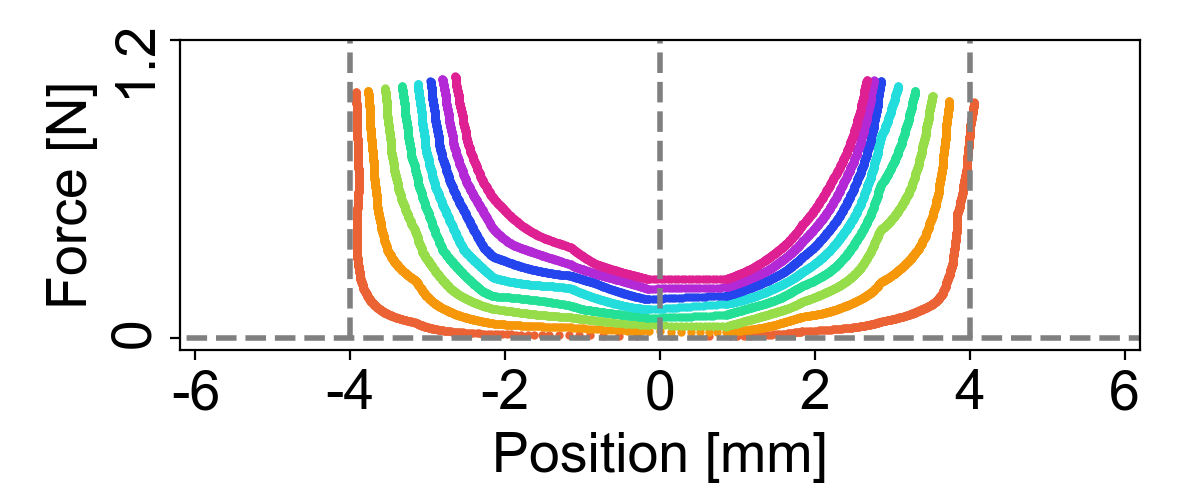

In [11]:
bm = np.reshape(bm_data_42H,(100,16))[34:70,1:]
fc = np.reshape(force_data_42H,(100,16))[34:70,1:]
plotfunc42b(bm*100.0,fc)
plt.savefig("../Figure/Figure4BI_TVI42B.png",transparent=True,dpi=300)
plt.savefig("../Figure/Figure4BI_TVI42B.svg",transparent=True,dpi=300)

#### 7.2bottom

In [12]:
def plotfunc72b(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-15.56).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(0,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(-6,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(6,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    
    plt.yticks(np.arange(0,1.3,1.2),['0','1.2'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-6,7,2),['-6','-4','-2','0','2','4','6'],fontsize=20,fontname="Arial")
    plt.xlabel('Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-6.2,6.2)
    plt.ylim(-0.05,1.2)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

<IPython.core.display.Javascript object>


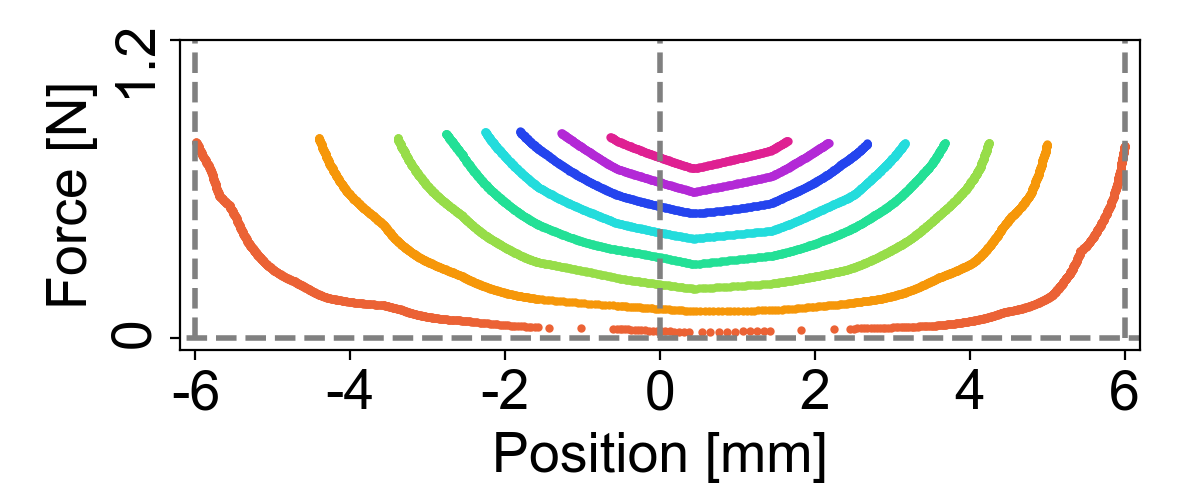

In [13]:
bm = np.reshape(bm_data_72H,(100,16))[34:70,1:]
fc = np.reshape(force_data_72H,(100,16))[34:70,1:]
plotfunc72b(bm*100.0,fc)
plt.savefig("../Figure/Figure4BII_TVI72B.png",transparent=True,dpi=300)
plt.savefig("../Figure/Figure4BII_TVI72B.svg",transparent=True,dpi=300)

#### 7.2middle

In [14]:
def plotfunc72m(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-17.25).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(0,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(-6,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    plt.vlines(6,0,1.2, linestyles='dashed',color='gray',linewidth=2)
    
    plt.yticks(np.arange(0,1.3,1.2),['0','1.2'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-6,7,2),['-6','-4','-2','0','2','4','6'],fontsize=20,fontname="Arial")
    plt.xlabel('Lateral Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-6.2,6.2)
    plt.ylim(-0.05,1.2)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

<IPython.core.display.Javascript object>


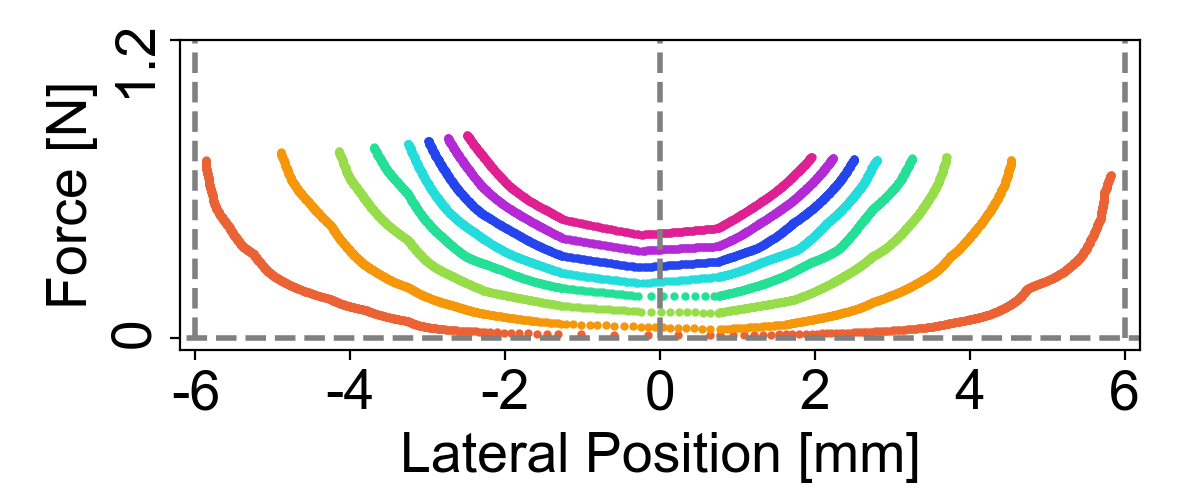

In [15]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc72m(bm*100.0,fc)
plt.savefig("../Figure/Figure4BIII_TVI72M.png",transparent=True,dpi=300)
plt.savefig("../Figure/Figure4BIII_TVI72M.svg",transparent=True,dpi=300)

## Figure 2: Indenter Size

### 2 mm

In [6]:
bm_data_72MH = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_2mm/01_bmpH.npy")
# bm_data_72MV = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mm/02_bmpH.npy")
force_data_72MH = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_2mm/01_forceH.npy")[:,:3],axis=1)
# force_data_72MV = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mm/02_forceH.npy")[:,:3],axis=1)

In [7]:
def plotfunc2mm(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-16.9).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(-6,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(6,0,3, linestyles='dashed',color='gray',linewidth=1)
    
    plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-8,9,1),['-8','','-6','','','','','','0','','','','','','6','','8'],fontsize=20,fontname="Arial")
    plt.xlabel('Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-8.0,8.0)
    plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

<IPython.core.display.Javascript object>


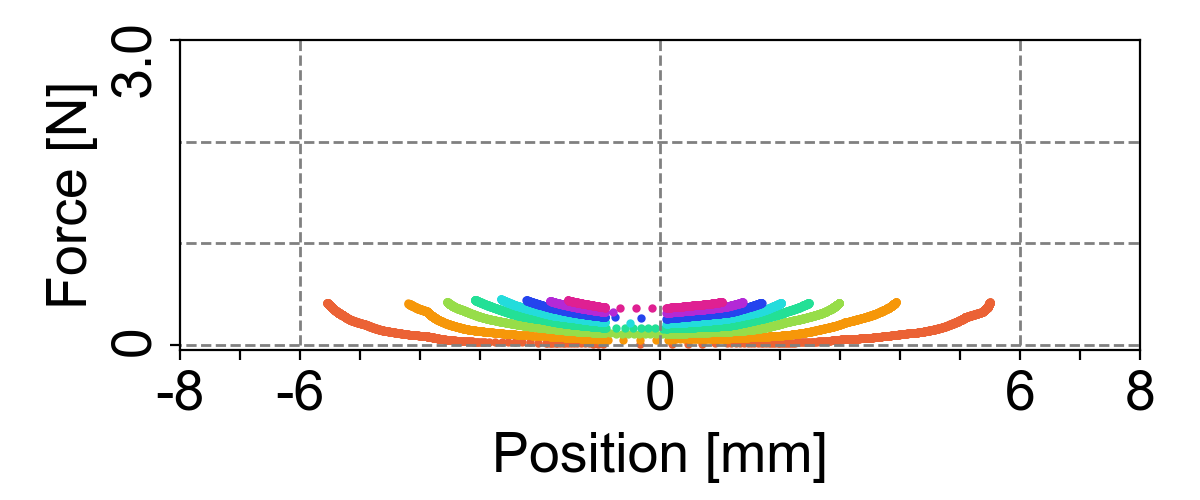

In [8]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc2mm(bm*100.0,fc)
plt.savefig("../Figure/Figure5BVI_2mm.png",transparent=True,dpi=300)
plt.savefig("../Figure/Figure5BVI_2mm.svg",transparent=True,dpi=300)

### 4 mm

In [ ]:
bm_data_72MH = np.load("../Data/Experiment3_72_middle/01_bmpH.npy")
bm_data_72MV = np.load("../Data/Experiment3_72_middle/02_bmpV.npy")
force_data_72MH = np.linalg.norm(np.load("../Data/Experiment3_72_middle/01_forceH.npy")[:,:3],axis=1)
force_data_72MV = np.linalg.norm(np.load("../Data/Experiment3_72_middle/02_forceV.npy")[:,:3],axis=1)

In [ ]:
def plotfunc4mm(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-17.25).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(-6,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(6,0,3, linestyles='dashed',color='gray',linewidth=1)
    
    plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-8,9,1),['-8','','-6','','','','','','0','','','','','','6','','8'],fontsize=20,fontname="Arial")
    plt.xlabel('Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-8.0,8.0)
    plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

In [ ]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc4mm(bm*100.0,fc)
plt.savefig("../Figure/Figure5BI_4mm.png",transparent=True,dpi=300)

### 8 mm

In [ ]:
bm_data_72MH = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_8mm/01_bmpH.npy")
bm_data_72MV = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_8mm/02_bmpH.npy")
force_data_72MH = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_8mm/01_forceH.npy")[:,:3],axis=1)
force_data_72MV = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_8mm/02_forceH.npy")[:,:3],axis=1)

In [ ]:
def plotfunc8mm(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-16.13).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(-6,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(6,0,3, linestyles='dashed',color='gray',linewidth=1)
    
    plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-8,9,1),['-8','','-6','','','','','','0','','','','','','6','','8'],fontsize=20,fontname="Arial")
    plt.xlabel('Lateral Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-8.0,8.0)
    plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

In [ ]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc8mm(bm*100.0,fc)
plt.savefig("../Figure/Figure5BII_8mm.png",transparent=True,dpi=300)

### 12 mm

In [ ]:
bm_data_72MH = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_12mm/01_bmpH.npy")
bm_data_72MV = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_12mm/02_bmpH.npy")
force_data_72MH = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_12mm/01_forceH.npy")[:,:3],axis=1)
force_data_72MV = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_12mm/02_forceH.npy")[:,:3],axis=1)

In [ ]:
def plotfunc12mm(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-16.34).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(-6,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(6,0,3, linestyles='dashed',color='gray',linewidth=1)
    
    plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-8,9,1),['-8','','-6','','','','','','0','','','','','','6','','8'],fontsize=20,fontname="Arial")
    plt.xlabel('Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-8.0,8.0)
    plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

In [ ]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc12mm(bm*100.0,fc)
plt.savefig("../Figure/Figure5BIII_12mm.png",transparent=True,dpi=300)

### 16 mm

In [ ]:
bm_data_72MH = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_16mm/01_bmpH.npy")
bm_data_72MV = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_16mm/02_bmpH.npy")
force_data_72MH = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_16mm/01_forceH.npy")[:,:3],axis=1)
force_data_72MV = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_16mm/02_forceH.npy")[:,:3],axis=1)

In [ ]:
def plotfunc16mm(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-16).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(-6,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(6,0,3, linestyles='dashed',color='gray',linewidth=1)
    
    plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-8,9,1),['-8','','-6','','','','','','0','','','','','','6','','8'],fontsize=20,fontname="Arial")
    plt.xlabel('Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-8.0,8.0)
    plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

In [ ]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc16mm(bm*100.0,fc)
plt.savefig("../Figure/Figure5BIV_16mm.png",transparent=True,dpi=300)

### 20 mm

In [ ]:
bm_data_72MH = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mm/01_bmpH.npy")
bm_data_72MV = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mm/02_bmpH.npy")
force_data_72MH = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mm/01_forceH.npy")[:,:3],axis=1)
force_data_72MV = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mm/02_forceH.npy")[:,:3],axis=1)

In [ ]:
def plotfunc20mm(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,36))
    fc = np.reshape(FC,(1000,36))
    SG = []
    FC = []
    for i in range(35):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(3500,1000))
    fc = np.reshape(FC,(3500,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(3500)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-17.1).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(-6,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(6,0,3, linestyles='dashed',color='gray',linewidth=1)
    
    plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial")
    plt.xticks(np.arange(-8,9,1),['-8','','-6','','','','','','0','','','','','','6','','8'],fontsize=20,fontname="Arial")
    plt.xlabel('Lateral Position [mm]',fontsize=20,fontname="Arial")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial")
    
    plt.yticks(rotation=90)
    plt.xlim(-8.0,8.0)
    plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

In [ ]:
bm = np.reshape(bm_data_72MH,(100,16))[34:70,1:]
fc = np.reshape(force_data_72MH,(100,16))[34:70,1:]
plotfunc20mm(bm*100.0,fc)
plt.savefig("../Figure/Figure5BV_20mm.png",transparent=True,dpi=300)

### 20 mm flat

In [ ]:
bm_data_72MH = np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mmflat/01_bmpH.npy")
# force_data_72MH = np.linalg.norm(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mmflat/01_forceH.npy")[:,:3],axis=1)
force_data_72MH = abs(np.load("../Data/Experiment7_Indenter/Experiment7_Indenter_20mmflat/01_forceH.npy")[:,2])

In [ ]:
def plotfunc20mm(bm,fc):
    SG = []
    FC = []
    for i in range(10):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(1000,30))
    fc = np.reshape(FC,(1000,30))
    SG = []
    FC = []
    for i in range(29):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,(2900,1000))
    fc = np.reshape(FC,(2900,1000))

    fig = plt.figure(figsize=(6,2.5))
    ii = 0
    for j in [500,2000,4000,6000, 8000,10000,12000,14000]:
        force = []
        position = []
        cross = np.ones(2900)*j
        for i in range(1000):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-16.0).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*2])
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
#     plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
#     plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
#     plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
#     plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
#     plt.vlines(-6,0,3, linestyles='dashed',color='gray',linewidth=1)
#     plt.vlines(6,0,3, linestyles='dashed',color='gray',linewidth=1)
    
#     plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial",style="italic")
#     plt.xticks(np.arange(-8,9,1),['-8','','-6','','','','','','0','','','','','','6','','8'],fontsize=20,fontname="Arial",style="italic")
#     plt.xlabel('Lateral Position [mm]',fontsize=20,fontname="Arial",style="italic")
#     plt.ylabel('Force [N]',fontsize=20,fontname="Arial",style="italic")
    
#     plt.yticks(rotation=90)
#     plt.xlim(-8.0,8.0)
#     plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.15,0.3,0.95,0.92)

In [ ]:
bm = np.reshape(bm_data_72MH,(30,16))[:,1:]
fc = np.reshape(force_data_72MH,(30,16))[:,1:]
plotfunc20mm(bm*100.0,fc)
# plt.savefig("../Figure/Figure5BV_20mmflat.png",transparent=True)

## Figure 3: 1D Shear Force Analysis 

### Data

In [ ]:
# # center line
bm_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer.npy")
force_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer.npy")[:,:3]

# bm_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle.npy")
# force_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_circle.npy")[:,:3]
# bm_data_72MH_center = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_center.npy")
# force_data_72MH_center = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_circle_center.npy")[:,:3]

# center line
# bm_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V10+_newelastomer.npy")
# force_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V10+_newelastomer.npy")[:,:3]

# bm_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V10+_newelastomer_circle.npy")
# force_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V10+_newelastomer_circle.npy")[:,:3]
# bm_data_72MH_center = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V10+_newelastomer_circle_center.npy")
# force_data_72MH_center = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V10+_newelastomer_circle_center.npy")[:,:3]

### 1D- Figure B-I,II,III

In [ ]:
position_channel = 30
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)
            
def plotfunc16mm(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))

    SG = []
    FC = []
    for i in range(position_channel-1):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))

    fig = plt.figure(figsize=(4,2.5))
    ii = 0
#     for j in [1000,2000,4000,6000, 8000,10000,12000,14000]:
    for j in [1000,5000,10000,15000]:
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(fc.shape[1]):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-15.25+0.2).tolist()
            force += fc[:,i][idx].tolist()
        plt.scatter(position,force,s=4,label=str(np.round(cross[0]/1000.0,1))+'k',c=rainbow[ii*4])
        if j == 5000:
            p5000 = position
            f5000 = force
        ii += 1
#     plt.legend(fontsize=16,ncol=5,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.0,markerscale=4)
    plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(-5,0,3, linestyles='dashed',color='gray',linewidth=1)
    plt.vlines(5,0,3, linestyles='dashed',color='gray',linewidth=1)
    
    plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial",style="italic")
    plt.xticks(np.arange(-10,11,5),['-10','','0','','10'],fontsize=20,fontname="Arial",style="italic")
    plt.xlabel('Lateral Position [mm]',fontsize=20,fontname="Arial",style="italic")
    plt.ylabel('Force [N]',fontsize=20,fontname="Arial",style="italic") # "Times New Roman"
    
    plt.yticks(rotation=90)
    plt.xlim(-10.0,10.0)
    plt.ylim(-0.05,3.0)
    plt.subplots_adjust(0.18,0.3,0.95,0.92)
    return(p5000,f5000)

In [ ]:
# center
p5000, f5000=plotfunc16mm(bm[:,np.asarray(normal_index)]*100.0,abs(fc_z[:,np.asarray(normal_index)]))
plt.savefig("../Figure/subfolder/Figure6NormalForce_16mm_xyz_normal.png",transparent=True,dpi=600)

p5000, f5000=plotfunc16mm(bm[:,np.asarray(shear_vertical)]*100.0,abs(fc_xyz[:,np.asarray(shear_vertical)]))
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_xyz_vertical.png",transparent=True,dpi=600)

p5000, f5000=plotfunc16mm(bm[:,np.asarray(shear_aligned)]*100.0,abs(fc_xyz[:,np.asarray(shear_aligned)]))
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_xyz_aligned.png",transparent=True,dpi=600)

### 2D- Figure C

In [ ]:
position_channel = 30
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(29):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc

In [ ]:
xyz_1000 = np.zeros((1,3))
xyz_5000 = np.zeros((1,3))
xyz_10000 = np.zeros((1,3))
xyz_15000 = np.zeros((1,3))

vertical_or_aligned = 1

if vertical_or_aligned == 0:
    bm_ = np.copy(bm[:,shear_vertical])
    fc_z_ = np.copy(fc_z[:,shear_vertical])
    fc_y_ = np.copy(fc_x[:,shear_vertical])
else:
    bm_ = np.copy(bm[:,shear_aligned])
    fc_z_ = np.copy(fc_z[:,shear_aligned])
    fc_y_ = np.copy(fc_y[:,shear_aligned])

In [ ]:
for threashold in np.arange(-2,2.05,0.1):
    force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
    bm, fc_ = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
    ii = 0
    for j in [1000,5000,10000,15000]:
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            position += (idx/100.0-15.25).tolist()
            force += fc_[:,i][idx].tolist()
#         Pos = []
#         for p in position:
#             Pos += [np.sign(p)*np.sqrt(p**2+3.25**2)]
#         position = Pos
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        if j== 1000: xyz_1000 = np.vstack((xyz_1000,intermediate))
        if j== 5000: xyz_5000 = np.vstack((xyz_5000,intermediate))
        if j== 10000: xyz_10000 = np.vstack((xyz_10000,intermediate))
        if j== 15000: xyz_15000 = np.vstack((xyz_15000,intermediate))
        ii += 1

In [ ]:
count = 0 
ourcolor = ["#eb6235ff","#97dd49ff","#23dcdcff","#b329d6ff"]
name_index = ["xyz_1000","xyz_5000","xyz_10000","xyz_15000"]
for xyz_surface in [xyz_1000[1:],xyz_5000[1:],xyz_10000[1:],xyz_15000[1:]]:
    fig = plt.figure(figsize=(4,3.5))
    xv = np.linspace(-10, 10, 401)
    yv = np.linspace(-2, 2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
    plt.grid()
    cmap = LinearSegmentedColormap.from_list("ourgreens", [ourgreen,[0.9,0.9,0.9]], N=256, gamma=1.0)
    cax = plt.imshow(Z,vmin=0,vmax=3, origin='lower',cmap=cmap)
    
    plt.xticks(np.arange(0,401,100),['-10','','0','','10'],fontsize=20,fontname="Arial",style="italic")
    plt.yticks(np.arange(0,401,200),['2','0','-2'],fontsize=20,fontname="Arial",style="italic",rotation=90)
    plt.xlabel('P [mm]',fontsize=20,fontname="Arial",style="italic")
    plt.ylabel(r'F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
    plt.subplots_adjust(0.2,0.2,0.95,0.95)
    cbar = fig.colorbar(cax,ticks=[0,3],shrink=0.915)
    cbar.ax.set_yticklabels(['0','3'],fontsize=20,fontname="Arial",style="italic",rotation=90)
    if vertical_or_aligned == 0:
        plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_normal_shear_relationship_vertical"+name_index[count]+".png",transparent=True,dpi=600)
    else:
        plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_normal_shear_relationship_aligned"+name_index[count]+".png",transparent=True,dpi=600)
    count += 1
    print(np.min(np.delete(Z,index)))

In [ ]:
count = 0 
name_index = ["xyz_1000","xyz_5000","xyz_10000","xyz_15000"]
for xyz_surface in [xyz_1000[1:],xyz_5000[1:],xyz_10000[1:],xyz_15000[1:]]:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(4,3.5))
    xv = np.linspace(-10, 10, 401)
    yv = np.linspace(-2, 2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
    index = np.where(Z>=3.5)
    Z[index] = np.nan
    cmap = LinearSegmentedColormap.from_list("ourgreens", [ourgreen,[0.9,0.9,0.9]], N=256, gamma=1.0)
    surf = ax.plot_surface(X,Y,Z, vmin=0,vmax=3.0,cmap=cmap, linewidth=0, antialiased=False)
    ax.set_xlabel('P [mm]',fontsize=20,fontname="Arial",style="italic")
    ax.set_ylabel(r'F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
    ax.set_zlabel(r'F$_{Normal}$ [N]',fontsize=20,fontname="Arial",style="italic")
    plt.xticks(np.arange(-10,11,10),['-10','0','10'],fontsize=20,fontname="Arial",style="italic",c=[0.5,0.5,0.5])
    plt.yticks(np.arange(-2,2.1,2.0),['2','0','-2'],fontsize=20,fontname="Arial",style="italic",c=[0.8,0.8,0.8])
    ax.tick_params(axis='x', which='major', pad=0)
    ax.tick_params(axis='y', which='major', pad=0)
    ax.tick_params(axis='z', which='major', pad=0)
    ax.set_zticks(np.arange(0,3.1,3))
    ax.tick_params(axis="z", labelsize=20)
    ax.tick_params(axis="z", colors='gray')
    fontproperties = {'family':'Arial'}
    ax.azim = -80.18092105263185
    ax.dist = 10
    ax.elev = 17.006578947368325
    plt.show()
    plt.xlim(-10.0,10.0)
    plt.ylim(-2,2)
    ax.set_zlim(0,3.0)
    plt.subplots_adjust(0,0.2,0.95,1)
    if vertical_or_aligned ==0:
        plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_normal_shear_3D_vertical"+name_index[count]+".png",transparent=True,dpi=600)
    else:
        plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_normal_shear_3D_aligned"+name_index[count]+".png",transparent=True,dpi=600)
    count += 1

### Modeling 1D- Figure B-V,VI,IV

#### FN-P- Figure B-V, VI

In [ ]:
position_channel = 30
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(29):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc

In [ ]:
# processing
xyz_1000 = np.zeros((1,3))
xyz_5000 = np.zeros((1,3))
xyz_10000 = np.zeros((1,3))
xyz_15000 = np.zeros((1,3))
vertical_or_aligned = 0
if vertical_or_aligned == 0:
    bm_ = np.copy(bm[:,shear_vertical])
    fc_z_ = np.copy(fc_z[:,shear_vertical])
    fc_y_ = np.copy(fc_x[:,shear_vertical])
else:
    bm_ = np.copy(bm[:,shear_aligned])
    fc_z_ = np.copy(fc_z[:,shear_aligned])
    fc_y_ = np.copy(fc_y[:,shear_aligned])

red = (235.0/255.0, 98.0/255.0, 53.0/255.0)
green=(151.0/255.0, 221.0/255.0, 73.0/255.0)
blue=(35.0/255.0,220.0/255.0,220.0/255.0)
purple=(179.0/255.0,41.0/255.0,214.0/255.0)
mycolors = [[darker(red,0.6), red, darker(red,1.2)],[darker(green,0.6), green, darker(green,1.2)],[darker(blue,0.6), blue, darker(blue,1.2)],[darker(purple,0.6), purple, darker(purple,1.2)]]

In [ ]:
def attenuation_power(x, a, b, c, d):
    return a * (np.abs(x-b))**c + d

def force_grid_intepolation(position, force, resolution):
    position_start = np.min(position)
    position_end = np.max(position)
    position_grid = np.linspace(position_start,position_end,resolution)
    force_grid = np.zeros((resolution))
    for i in range(resolution):
        index = np.argsort(abs(position_grid[i] - position))[:2]
        if (position[index[1]]-position[index[0]]) == 0:
            force_grid[i] = (force[index[1]]+force[index[0]])/2.0
        else:
            force_grid[i] = (force[index[1]]-force[index[0]])/(position[index[1]]-position[index[0]])*(position_grid[i]-position[index[0]])+force[index[0]]
    return position_grid, force_grid

In [ ]:
# plot
colorsheme = 1
fig = plt.figure(figsize=(4,2.5))
for j in [5000]:
    count = 0
    for threashold in [-1.5,0,1.5]:
        force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
        bm, fc_ = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
            if idx.size>0: 
                position += (idx/100.0-15.05).tolist()
                force += fc_[:,i][idx].tolist()
        resolution = 20
        position_grid, force_grid = force_grid_intepolation(position,force,resolution)
        plt.scatter(position_grid,force_grid,s=40,label=str(threashold)+" N",c=mycolors[colorsheme][count],zorder=10,alpha=0.8)
        index = np.where(force_grid<=5)
        weights_x = np.linspace(-1,1,index[0].shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
#         popt, pcov = curve_fit(attenuation_power,position_grid[index],force_grid[index],bounds=([0,-5,1,0],[20,5,20,2]),absolute_sigma=True,sigma=weights_norm)
        popt, pcov = curve_fit(attenuation_power,position_grid[index],force_grid[index],bounds=([0,-5,1,0],[20,5,20,2]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        plt.plot(position_grid[index],attenuation_power(position_grid[index],*popt),linewidth=2,label=str(threashold)+" N",c=mycolors[colorsheme][count],zorder=20,alpha=0.8)
        print(popt)
        count += 1
    colorsheme += 1
plt.hlines(0,-16,19, linestyles='dashed',color='gray',linewidth=1)
plt.hlines(1,-16,19, linestyles='dashed',color='gray',linewidth=1)
plt.hlines(2,-16,19, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(-5,0,3, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(5,0,3, linestyles='dashed',color='gray',linewidth=1)

plt.yticks(np.arange(0,3.1,3.0),['0','3.0'],fontsize=20,fontname="Arial",style="italic")
plt.xticks(np.arange(-10,11,5),['-10','','0','','10'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('Lateral Position [mm]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('F$_{Normal}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(-10.0,10.0)
plt.ylim(-0.05,3.0)
plt.subplots_adjust(0.18,0.3,0.95,0.92)
if vertical_or_aligned == 0:
    plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_vertical_5kpa.png",transparent=True,dpi=600)
else:
    plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_aligned_5kpa.png",transparent=True,dpi=600)

#### FN-FS- Figure B-IV

In [ ]:
position_channel = 30
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(29):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc

In [ ]:
xyz_1000 = np.zeros((1,3))
xyz_5000 = np.zeros((1,3))
xyz_10000 = np.zeros((1,3))
xyz_15000 = np.zeros((1,3))

bm_ = np.copy(bm[:,shear_vertical])
fc_z_ = np.copy(fc_z[:,shear_vertical])
fc_y_ = np.copy(fc_x[:,shear_vertical])

red = (235.0/255.0, 98.0/255.0, 53.0/255.0)
green=(151.0/255.0, 221.0/255.0, 73.0/255.0)
blue=(35.0/255.0,220.0/255.0,220.0/255.0)
purple=(179.0/255.0,41.0/255.0,214.0/255.0)
mycolors = [[darker(red,0.6), red, darker(red,1.2)],[darker(green,0.6), green, darker(green,1.2)],[darker(blue,0.6), blue, darker(blue,1.2)],[darker(purple,0.6), purple, darker(purple,1.2)]]

for threashold in np.arange(-2,2.2,0.2):
    force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
    bm_new, fc_ = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
    ii = 0
    for j in [5000]:
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
            position += (idx/100.0-10.0).tolist()
            force += fc_[:,i][idx].tolist()
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        if j== 1000: xyz_1000 = np.vstack((xyz_1000,intermediate))
        if j== 5000: xyz_5000 = np.vstack((xyz_5000,intermediate))
        if j== 10000: xyz_10000 = np.vstack((xyz_10000,intermediate))
        if j== 15000: xyz_15000 = np.vstack((xyz_15000,intermediate))
        ii += 1
        
count = 0 
xyz_surface = xyz_5000[1:]
xv = np.linspace(-10,10,401)
yv = np.linspace(-2,2, 401)
[X,Y] = np.meshgrid(xv, yv)
Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
index = np.where(np.isnan(Z))
Z[index] = 5

Z_min_vertical = []
for i in range(400,-1,-1):
    Z_min_vertical += [np.min(Z[i,:])]

xyz_1000 = np.zeros((1,3))
xyz_5000 = np.zeros((1,3))
xyz_10000 = np.zeros((1,3))
xyz_15000 = np.zeros((1,3))

bm_ = np.copy(bm[:,shear_aligned])
fc_z_ = np.copy(fc_z[:,shear_aligned])
fc_y_ = np.copy(fc_y[:,shear_aligned])

red = (235.0/255.0, 98.0/255.0, 53.0/255.0)
green=(151.0/255.0, 221.0/255.0, 73.0/255.0)
blue=(35.0/255.0,220.0/255.0,220.0/255.0)
purple=(179.0/255.0,41.0/255.0,214.0/255.0)
mycolors = [[darker(red,0.6), red, darker(red,1.2)],[darker(green,0.6), green, darker(green,1.2)],[darker(blue,0.6), blue, darker(blue,1.2)],[darker(purple,0.6), purple, darker(purple,1.2)]]

for threashold in np.arange(-2,2.2,0.2):
    force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
    bm_new, fc_ = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
    ii = 0
    for j in [5000]:
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
            position += (idx/100.0-10.0).tolist()
            force += fc_[:,i][idx].tolist()
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        if j== 1000: xyz_1000 = np.vstack((xyz_1000,intermediate))
        if j== 5000: xyz_5000 = np.vstack((xyz_5000,intermediate))
        if j== 10000: xyz_10000 = np.vstack((xyz_10000,intermediate))
        if j== 15000: xyz_15000 = np.vstack((xyz_15000,intermediate))
        ii += 1
        
count = 0 
xyz_surface = xyz_5000[1:]
xv = np.linspace(-10,10,401)
yv = np.linspace(-2,2, 401)
[X,Y] = np.meshgrid(xv, yv)
Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
index = np.where(np.isnan(Z))
Z[index] = 5

Z_min_shear = []
for i in range(400,-1,-1):
    Z_min_shear += [np.min(Z[i,:])]

In [ ]:
def lambdaF_curvefit(x,a,b):
    return a*abs(x) +b

fig = plt.figure(figsize=(4,2.5))
FS_grid = np.linspace(-2,2,401)
plot_point = np.asarray([int(i) for i in np.linspace(0,399,20)])

weights_x = np.linspace(-1,1,plot_point.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
plt.scatter(FS_grid[plot_point],np.asarray(Z_min_vertical)[plot_point],s=40,label='$\pm$ x',c="#97de49",zorder=10, alpha=0.8)
popt, pcov = curve_fit(lambdaF_curvefit,FS_grid[plot_point],np.asarray(Z_min_vertical)[plot_point],bounds=([0,-2],[1,2]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
plt.plot(FS_grid,lambdaF_curvefit(FS_grid,*popt),linewidth=2,c="#97de49",zorder=j)

weights_x = np.linspace(-1,1,plot_point.shape[0]-1)
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
plt.scatter(FS_grid[plot_point],np.asarray(Z_min_shear)[plot_point],s=40,label='$\pm$ y',c="#eb6235",zorder=10, alpha=0.8)
popt, pcov = curve_fit(lambdaF_curvefit,FS_grid[plot_point[1:]],np.asarray(Z_min_shear)[plot_point[1:]],bounds=([0,-2],[1,2]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
plt.plot(FS_grid,lambdaF_curvefit(FS_grid,*popt),linewidth=2,c="#eb6235",zorder=j)

plt.hlines(0.4,-2,2, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(-1,0.0,0.8, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(0,0.0,0.8, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(1,0.0,0.8, linestyles='dashed',color='gray',linewidth=1)

plt.legend(fontsize=16,ncol=2,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.9,markerscale=1)
plt.yticks(np.arange(0.0,0.9,0.8),['0','0.8'],fontsize=20,fontname="Arial",style="italic")
plt.xticks(np.arange(-2,2.1,1),['-2',' ','0',' ','2'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('F$_{Normal}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(-2.0,2.0)
plt.ylim(0.0,0.8)
plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_5kpa_FN_FS.png",transparent=True,dpi=600)

### Modeling 2D- Figure D

#### Tangential + Radical Comparison - Figure D-I

In [ ]:
# data preprocessing
vertical_aligned = 1

if vertical_aligned ==0:
    name_label = '_center_vertical'
if vertical_aligned ==1:
    name_label = '_center_aligned'

position_channel = 30
if position_channel == 30:
    center_offset = 15.05
elif position_channel == 21:
    center_offset = 10.0
    
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(position_channel-1):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc

In [ ]:
# data processing
xyz_1000 = np.zeros((1,3))
xyz_5000 = np.zeros((1,3))
xyz_10000 = np.zeros((1,3))
xyz_15000 = np.zeros((1,3))

if vertical_aligned ==0:
    bm_ = np.copy(bm[:,shear_vertical])
    fc_z_ = np.copy(fc_z[:,shear_vertical])
    fc_y_ = np.copy(fc_x[:,shear_vertical])
else:
    bm_ = np.copy(bm[:,shear_aligned])
    fc_z_ = np.copy(fc_z[:,shear_aligned])
    fc_y_ = np.copy(fc_y[:,shear_aligned])

red = (235.0/255.0, 98.0/255.0, 53.0/255.0)
green=(151.0/255.0, 221.0/255.0, 73.0/255.0)
blue=(35.0/255.0,220.0/255.0,220.0/255.0)
purple=(179.0/255.0,41.0/255.0,214.0/255.0)
mycolors = [[darker(red,0.6), red, darker(red,1.2)],[darker(green,0.6), green, darker(green,1.2)],[darker(blue,0.6), blue, darker(blue,1.2)],[darker(purple,0.6), purple, darker(purple,1.2)]]

for threashold in np.arange(-2.0,2.05,0.1):
    force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
    bm_new, fc_new = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
    for j in [1000,5000,10000,15000]:
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
            position += (idx/100.0-center_offset).tolist()
            force += fc_new[:,i][idx].tolist()
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        if j== 1000: xyz_1000 = np.vstack((xyz_1000,intermediate))
        if j== 5000: xyz_5000 = np.vstack((xyz_5000,intermediate))
        if j== 10000: xyz_10000 = np.vstack((xyz_10000,intermediate))
        if j== 15000: xyz_15000 = np.vstack((xyz_15000,intermediate))

In [ ]:
# curve fit
TVI_lambda_all_v = []
TVI_alpha_all_v = []
TVI_center_all_v = []
TVI_offset_all_v = []
error1_all_v = []
error2_all_v = []
for xyz_surface in [xyz_1000[1:],xyz_5000[1:],xyz_10000[1:],xyz_15000[1:]]:
    xv = np.linspace(-10,10,401)
    yv = np.linspace(-2,2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
#     fig = plt.figure()
#     plt.imshow(Z)

    PS_grid = np.linspace(-10,10,401)
    FS_grid = np.linspace(-2.0,2.0,401)
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error1 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]
        error1 += [np.sqrt(np.mean((FN-fitted)**2))]
    
    mean_lambda = np.mean(TVI_lambda)
    mean_center = np.mean(TVI_center)
    mean_alpha = np.mean(TVI_alpha)
    mean_offset = np.mean(TVI_offset)
    
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error2 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]
        error2 += [np.sqrt(np.mean((FN-fitted)**2))]
    
    TVI_lambda_all_v +=[TVI_lambda]
    TVI_center_all_v +=[TVI_center]
    TVI_alpha_all_v +=[TVI_alpha]
    TVI_offset_all_v +=[TVI_offset]
    error1_all_v += [error1]
    error2_all_v += [error2]

In [ ]:
# curve fit
TVI_lambda_all_a = []
TVI_alpha_all_a = []
TVI_center_all_a = []
TVI_offset_all_a = []
error1_all_a = []
error2_all_a = []
for xyz_surface in [xyz_1000[1:],xyz_5000[1:],xyz_10000[1:],xyz_15000[1:]]:
    xv = np.linspace(-10,10,401)
    yv = np.linspace(-2,2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
#     fig = plt.figure()
#     plt.imshow(Z)

    PS_grid = np.linspace(-10,10,401)
    FS_grid = np.linspace(-2.0,2.0,401)
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error1 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]
        error1 += [np.sqrt(np.mean((FN-fitted)**2))]
    
    mean_lambda = np.mean(TVI_lambda)
    mean_center = np.mean(TVI_center)
    mean_alpha = np.mean(TVI_alpha)
    mean_offset = np.mean(TVI_offset)
    
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error2 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]
        error2 += [np.sqrt(np.mean((FN-fitted)**2))]
    
    TVI_lambda_all_a +=[TVI_lambda]
    TVI_center_all_a +=[TVI_center]
    TVI_alpha_all_a +=[TVI_alpha]
    TVI_offset_all_a +=[TVI_offset]
    error1_all_a += [error1]
    error2_all_a += [error2]

In [ ]:
# figure
color_code = ["#eb6235","#97dd49","#23dcdc","#b329d6"]
fig = plt.figure(figsize=(4,2.5))
for baro_level in range(4):
    FS_grid = np.linspace(-2,2,401)
    index1 = np.asarray([int(x) for x in np.linspace(0,400,11)])
    index2 = np.asarray([int(x) for x in np.linspace(20,380,10)])
    plt.scatter(FS_grid[index1],np.asarray(TVI_lambda_all_v[baro_level][::-1])[index1],s=80,c=color_code[baro_level],marker = '^')
    plt.scatter(FS_grid[index2],np.asarray(TVI_lambda_all_a[baro_level][::-1])[index2],s=80,c=color_code[baro_level],marker = 'o')

plt.hlines(10**(-2),-2,2, linestyles='dashed',color='gray',linewidth=1)

plt.vlines(-1,0,1, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(0,0,1, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(1,0,1, linestyles='dashed',color='gray',linewidth=1)
plt.yscale('log')
plt.yticks([10**(-4),1],['10$^{-4}$','10$^{0}$'],fontsize=20,fontname="Arial",style="italic")
plt.xticks(np.arange(-2,2.1,1),['-2',' ','0',' ','2'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('$\lambda_D$',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(-2.0,2.0)
plt.ylim(10**(-4)-5*10**(-5),1)

plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_lamda"+name_label+".png",transparent=True,dpi=600)

fig = plt.figure(figsize=(4,2.5))
for baro_level in range(4):
    FS_grid = np.linspace(-2,2,401)
    index1 = np.asarray([int(x) for x in np.linspace(0,400,11)])
    index2 = np.asarray([int(x) for x in np.linspace(20,380,10)])
    plt.scatter(FS_grid[index1],np.asarray(TVI_center_all_v[baro_level][::-1])[index1],s=80,c=color_code[baro_level],marker = '^')
    plt.scatter(FS_grid[index2],np.asarray(TVI_center_all_a[baro_level][::-1])[index2],s=80,c=color_code[baro_level],marker = 'o')

plt.hlines(0,-2,2, linestyles='dashed',color='gray',linewidth=1)

plt.vlines(-1,-3,3, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(0,-3,3, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(1,-3,3, linestyles='dashed',color='gray',linewidth=1)
plt.yticks([-3,3],['-3','3'],fontsize=20,fontname="Arial",style="italic")
plt.xticks(np.arange(-2,2.1,1),['-2',' ','0',' ','2'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('P$_0$ [mm]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(-2.0,2.0)
plt.ylim(-3,3)

plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_center"+name_label+".png",transparent=True,dpi=600)


fig = plt.figure(figsize=(4,2.5))
for baro_level in range(4):
    FS_grid = np.linspace(-2,2,401)
    index1 = np.asarray([int(x) for x in np.linspace(0,400,11)])
    index2 = np.asarray([int(x) for x in np.linspace(20,380,10)])
    plt.scatter(FS_grid[index1],np.asarray(TVI_alpha_all_v[baro_level][::-1])[index1],s=80,c=color_code[baro_level],marker = '^')
    plt.scatter(FS_grid[index2],np.asarray(TVI_alpha_all_a[baro_level][::-1])[index2],s=80,c=color_code[baro_level],marker = 'o')

plt.hlines(4,-2,2, linestyles='dashed',color='gray',linewidth=1)

plt.vlines(-1,2,10, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(0,2,10, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(1,2,10, linestyles='dashed',color='gray',linewidth=1)
plt.yticks([2,6],['2','6'],fontsize=20,fontname="Arial",style="italic")
plt.xticks(np.arange(-2,2.1,1),['-2',' ','0',' ','2'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel(r'$\alpha$',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(-2.0,2.0)
plt.ylim(2.0,6.0)

plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_alpha"+name_label+".png",transparent=True,dpi=600)

fig = plt.figure(figsize=(4,2.5))
for baro_level in range(4):
    FS_grid = np.linspace(-2,2,401)
    index1 = np.asarray([int(x) for x in np.linspace(0,400,11)])
    index2 = np.asarray([int(x) for x in np.linspace(20,380,10)])
    plt.scatter(FS_grid[index1],np.asarray(TVI_offset_all_v[baro_level][::-1])[index1],s=80,c=color_code[baro_level],marker = '^')
    plt.scatter(FS_grid[index2],np.asarray(TVI_offset_all_a[baro_level][::-1])[index2],s=80,c=color_code[baro_level],marker = 'o')

plt.hlines(1,-2,2, linestyles='dashed',color='gray',linewidth=1)
plt.hlines(2,-2,2, linestyles='dashed',color='gray',linewidth=1)

plt.vlines(-1,0,3, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(0,0,3, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(1,0,3, linestyles='dashed',color='gray',linewidth=1)
plt.yticks([0,3],['0','3'],fontsize=20,fontname="Arial",style="italic")
plt.xticks(np.arange(-2,2.1,1),['-2',' ','0',' ','2'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('F$_{Offset}$ [N]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(-2.0,2.0)
plt.ylim(0,3.0)

plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI"+name_label+".png",transparent=True,dpi=600)

#### parameters relationship to sensor value - Figure D-II

##### processing

###### subsampling-quick results

In [ ]:
# data preprocessing
vertical_aligned = 0

if vertical_aligned ==0:
    name_label = '_center_vertical'
if vertical_aligned ==1:
    name_label = '_center_aligned'

position_channel = 30
if position_channel == 30:
    center_offset = 15.25
elif position_channel == 21:
    center_offset = 10.0
    
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(position_channel-1):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc

In [ ]:
# data processing
if vertical_aligned ==0:
    bm_ = np.copy(bm[:,shear_vertical])
    fc_z_ = np.copy(fc_z[:,shear_vertical])
    fc_y_ = np.copy(fc_x[:,shear_vertical])
else:
    bm_ = np.copy(bm[:,shear_aligned])
    fc_z_ = np.copy(fc_z[:,shear_aligned])
    fc_y_ = np.copy(fc_y[:,shear_aligned])

red = (235.0/255.0, 98.0/255.0, 53.0/255.0)
green=(151.0/255.0, 221.0/255.0, 73.0/255.0)
blue=(35.0/255.0,220.0/255.0,220.0/255.0)
purple=(179.0/255.0,41.0/255.0,214.0/255.0)
mycolors = [[darker(red,0.6), red, darker(red,1.2)],[darker(green,0.6), green, darker(green,1.2)],[darker(blue,0.6), blue, darker(blue,1.2)],[darker(purple,0.6), purple, darker(purple,1.2)]]

TVI_lambda_all_v = []
TVI_alpha_all_v = []
TVI_center_all_v = []
TVI_offset_all_v = []
TVI_offset0_all_v = []
S_reading = []
# for j in np.linspace(1000,15000,141):
for j in np.linspace(1000,15000,15):
    xyz_value = np.zeros((1,3))
    for threashold in np.arange(-2.0,2.05,0.1):
        force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
        bm_new, fc_new = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
            position += (idx/100.0-center_offset).tolist()
            force += fc_new[:,i][idx].tolist()
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        xyz_value = np.vstack((xyz_value,intermediate))
    xyz_surface = xyz_value[1:]
    xv = np.linspace(-10,10,401)
    yv = np.linspace(-2,2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
    PS_grid = np.linspace(-10,10,401)
    FS_grid = np.linspace(-2.0,2.0,401)
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error1 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    mean_lambda = np.mean(TVI_lambda)
    mean_alpha = np.mean(TVI_alpha)

    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    TVI_lambda_all_v += [np.mean(TVI_lambda)]
    TVI_center_all_v += [-(TVI_center[0]-TVI_center[400])/4.0]
    TVI_alpha_all_v += [np.mean(TVI_alpha)]
    TVI_offset_all_v += [((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0]
    TVI_offset0_all_v += [TVI_offset[200]]
    S_reading += [j]
    print(j, np.mean(TVI_lambda), -(TVI_center[0]-TVI_center[400])/4.0, np.mean(TVI_alpha), ((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0, TVI_offset[200])

In [ ]:
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_v.npy",TVI_lambda_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_v.npy",TVI_center_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_v.npy",TVI_alpha_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_v.npy",TVI_offset_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_v.npy",TVI_offset0_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_v.npy",S_reading)

In [ ]:
# data preprocessing
vertical_aligned = 1

if vertical_aligned ==0:
    name_label = '_center_vertical'
if vertical_aligned ==1:
    name_label = '_center_aligned'

position_channel = 30
if position_channel == 30:
    center_offset = 15.25
elif position_channel == 21:
    center_offset = 10.0
    
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(position_channel-1):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc
        

In [ ]:
# data processing
if vertical_aligned ==0:
    bm_ = np.copy(bm[:,shear_vertical])
    fc_z_ = np.copy(fc_z[:,shear_vertical])
    fc_y_ = np.copy(fc_x[:,shear_vertical])
else:
    bm_ = np.copy(bm[:,shear_aligned])
    fc_z_ = np.copy(fc_z[:,shear_aligned])
    fc_y_ = np.copy(fc_y[:,shear_aligned])

red = (235.0/255.0, 98.0/255.0, 53.0/255.0)
green=(151.0/255.0, 221.0/255.0, 73.0/255.0)
blue=(35.0/255.0,220.0/255.0,220.0/255.0)
purple=(179.0/255.0,41.0/255.0,214.0/255.0)
mycolors = [[darker(red,0.6), red, darker(red,1.2)],[darker(green,0.6), green, darker(green,1.2)],[darker(blue,0.6), blue, darker(blue,1.2)],[darker(purple,0.6), purple, darker(purple,1.2)]]

TVI_lambda_all_a = []
TVI_alpha_all_a = []
TVI_center_all_a = []
TVI_offset_all_a = []
TVI_offset0_all_a = []
S_reading = []
for j in np.linspace(1000,15000,15):
    xyz_value = np.zeros((1,3))
    for threashold in np.arange(-2.0,2.05,0.1):
        force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
        bm_new, fc_new = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
            position += (idx/100.0-center_offset).tolist()
            force += fc_new[:,i][idx].tolist()
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        xyz_value = np.vstack((xyz_value,intermediate))
    xyz_surface = xyz_value[1:]
    xv = np.linspace(-10,10,401)
    yv = np.linspace(-2,2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
    PS_grid = np.linspace(-10,10,401)
    FS_grid = np.linspace(-2.0,2.0,401)
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error1 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    mean_lambda = np.mean(TVI_lambda)
    mean_alpha = np.mean(TVI_alpha)

    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    TVI_lambda_all_a += [np.mean(TVI_lambda)]
    TVI_center_all_a += [-(TVI_center[0]-TVI_center[400])/4.0]
    TVI_alpha_all_a += [np.mean(TVI_alpha)]
    TVI_offset_all_a += [((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0]
    TVI_offset0_all_a += [TVI_offset[200]]
    S_reading += [j]
    print(j, np.mean(TVI_lambda), -(TVI_center[0]-TVI_center[400])/4.0, np.mean(TVI_alpha), ((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0, TVI_offset[200])

In [ ]:
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_a.npy",TVI_lambda_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_a.npy",TVI_center_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_a.npy",TVI_alpha_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_a.npy",TVI_offset_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_a.npy",TVI_offset0_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_a.npy",S_reading)

###### full sampling-full usage to compare

In [ ]:
bm_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer.npy")
force_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer.npy")[:,:3]

In [ ]:
# data preprocessing
vertical_aligned = 0

if vertical_aligned ==0:
    name_label = '_center_vertical'
if vertical_aligned ==1:
    name_label = '_center_aligned'

position_channel = 30
if position_channel == 30:
    center_offset = 15.25
elif position_channel == 21:
    center_offset = 10.0
    
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(position_channel-1):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc

def attenuation_power(x, a, b, c, d):
    return a * (np.abs(x-b))**c + d

# data processing
if vertical_aligned ==0:
    bm_ = np.copy(bm[:,shear_vertical])
    fc_z_ = np.copy(fc_z[:,shear_vertical])
    fc_y_ = np.copy(fc_x[:,shear_vertical])
else:
    bm_ = np.copy(bm[:,shear_aligned])
    fc_z_ = np.copy(fc_z[:,shear_aligned])
    fc_y_ = np.copy(fc_y[:,shear_aligned])

red = (235.0/255.0, 98.0/255.0, 53.0/255.0)
green=(151.0/255.0, 221.0/255.0, 73.0/255.0)
blue=(35.0/255.0,220.0/255.0,220.0/255.0)
purple=(179.0/255.0,41.0/255.0,214.0/255.0)
# mycolors = [[darker(red,0.6), red, darker(red,1.2)],[darker(green,0.6), green, darker(green,1.2)],[darker(blue,0.6), blue, darker(blue,1.2)],[darker(purple,0.6), purple, darker(purple,1.2)]]

TVI_lambda_all_v = []
TVI_alpha_all_v = []
TVI_center_all_v = []
TVI_offset_all_v = []
TVI_offset0_all_v = []
S_reading = []
for j in np.linspace(1000,28000,271):
# for j in np.linspace(1000,15000,15):
    xyz_value = np.zeros((1,3))
    for threashold in np.arange(-2.0,2.05,0.1):
        force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
        bm_new, fc_new = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
            position += (idx/100.0-center_offset).tolist()
            force += fc_new[:,i][idx].tolist()
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        xyz_value = np.vstack((xyz_value,intermediate))
    xyz_surface = xyz_value[1:]
    xv = np.linspace(-10,10,401)
    yv = np.linspace(-2,2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
    PS_grid = np.linspace(-10,10,401)
    FS_grid = np.linspace(-2.0,2.0,401)
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error1 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)  
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    mean_lambda = np.mean(TVI_lambda)
    mean_alpha = np.mean(TVI_alpha)

    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    TVI_lambda_all_v += [np.mean(TVI_lambda)]
    TVI_center_all_v += [-(TVI_center[0]-TVI_center[400])/4.0]
    TVI_alpha_all_v += [np.mean(TVI_alpha)]
    TVI_offset_all_v += [((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0]
    TVI_offset0_all_v += [TVI_offset[200]]
    S_reading += [j]
    print(j, np.mean(TVI_lambda), -(TVI_center[0]-TVI_center[400])/4.0, np.mean(TVI_alpha), ((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0, TVI_offset[200])
    
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_v_full.npy",TVI_lambda_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_v_full.npy",TVI_center_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_v_full.npy",TVI_alpha_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_v_full.npy",TVI_offset_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_v_full.npy",TVI_offset0_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_v_full.npy",S_reading)

In [ ]:
# data preprocessing
vertical_aligned = 1

if vertical_aligned ==0:
    name_label = '_center_vertical'
if vertical_aligned ==1:
    name_label = '_center_aligned'

position_channel = 30
if position_channel == 30:
    center_offset = 15.25
elif position_channel == 21:
    center_offset = 10.0
    
bm = np.reshape(bm_data_72MH, (position_channel,436))[:,1:]
fc_x = np.reshape(force_data_72MH[:,0], (position_channel,436))[:,1:]
fc_y = np.reshape(force_data_72MH[:,1], (position_channel,436))[:,1:]
fc_z = np.reshape(force_data_72MH[:,2], (position_channel,436))[:,1:]
fc_xyz = np.reshape(np.linalg.norm(force_data_72MH,axis=1), (position_channel,436))[:,1:]
fc_xz = np.reshape(np.linalg.norm(force_data_72MH[:,[0,2]],axis=1), (position_channel,436))[:,1:]
fc_yz = np.reshape(np.linalg.norm(force_data_72MH[:,[1,2]],axis=1), (position_channel,436))[:,1:]

count = -1
normal_index = []
shear_vertical = []
shear_aligned = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    shear_aligned_positive.append(count)
    shear_aligned_negative.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
            shear_aligned_negative.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,position_channel))
    fc = np.reshape(FC,(fc.shape[1]*100,position_channel))
    SG = []
    FC = []
    for i in range(position_channel-1):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((position_channel-1)*100,fc.shape[0]))
    fc = np.reshape(FC,((position_channel-1)*100,fc.shape[0]))
    return bm,fc

# data processing
if vertical_aligned ==0:
    bm_ = np.copy(bm[:,shear_vertical])
    fc_z_ = np.copy(fc_z[:,shear_vertical])
    fc_y_ = np.copy(fc_x[:,shear_vertical])
else:
    bm_ = np.copy(bm[:,shear_aligned])
    fc_z_ = np.copy(fc_z[:,shear_aligned])
    fc_y_ = np.copy(fc_y[:,shear_aligned])

TVI_lambda_all_a = []
TVI_alpha_all_a = []
TVI_center_all_a = []
TVI_offset_all_a = []
TVI_offset0_all_a = []
S_reading = []
for j in np.linspace(1000,28000,271):
    xyz_value = np.zeros((1,3))
    for threashold in np.arange(-2.0,2.05,0.1):
        force_index = np.where((abs(np.mean(fc_y_,axis=0)-threashold)<0.05))[0]
        bm_new, fc_new = interpolate16mm2D(bm_[:,force_index]*100.0,-fc_z_[:,force_index])
        force = []
        position = []
        cross = np.ones((position_channel-1)*100)*j
        for i in range(force_index.shape[0]*100):
            idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
            position += (idx/100.0-center_offset).tolist()
            force += fc_new[:,i][idx].tolist()
        intermediate = np.zeros((len(position),3))
        intermediate[:,0] = np.asarray(position)
        intermediate[:,1] = np.asarray(force)
        intermediate[:,2] = threashold
        xyz_value = np.vstack((xyz_value,intermediate))
    xyz_surface = xyz_value[1:]
    xv = np.linspace(-10,10,401)
    yv = np.linspace(-2,2, 401)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
    index = np.where(np.isnan(Z))
    Z[index] = 5
    PS_grid = np.linspace(-10,10,401)
    FS_grid = np.linspace(-2.0,2.0,401)
    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    error1 = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)  
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    mean_lambda = np.mean(TVI_lambda)
    mean_alpha = np.mean(TVI_alpha)

    TVI_lambda = []
    TVI_alpha = []
    TVI_center = []
    TVI_offset = []
    for i in range(401):
        index = np.where(Z[i]>=5)
        PS = np.delete(PS_grid,index)
        FN = np.delete(Z[i],index)
        weights_x = np.linspace(-1,1,PS.shape[0])
        weights = 1/np.exp(-abs(weights_x)**2*3)
        weights_norm = weights/np.sum(weights)
        popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
        fitted = attenuation_power(PS, *popt)
        TVI_lambda += [popt[0]]
        TVI_center += [popt[1]]
        TVI_alpha += [popt[2]]
        TVI_offset += [popt[3]]

    TVI_lambda_all_a += [np.mean(TVI_lambda)]
    TVI_center_all_a += [-(TVI_center[0]-TVI_center[400])/4.0]
    TVI_alpha_all_a += [np.mean(TVI_alpha)]
    TVI_offset_all_a += [((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0]
    TVI_offset0_all_a += [TVI_offset[200]]
    S_reading += [j]
    print(j, np.mean(TVI_lambda), -(TVI_center[0]-TVI_center[400])/4.0, np.mean(TVI_alpha), ((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0, TVI_offset[200])
    
    
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_a_full.npy",TVI_lambda_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_a_full.npy",TVI_center_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_a_full.npy",TVI_alpha_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_a_full.npy",TVI_offset_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_a_full.npy",TVI_offset0_all_a)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_a_full.npy",S_reading)

##### plot

###### subsampling-quick results

In [ ]:
S_reading = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_v.npy")

TVI_lambda_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_v.npy")
TVI_center_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_v.npy")
TVI_alpha_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_v.npy")
TVI_offset_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_v.npy")
TVI_offset0_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_v.npy")

TVI_lambda_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_a.npy")
TVI_center_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_a.npy")
TVI_alpha_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_a.npy")
TVI_offset_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_a.npy")
TVI_offset0_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_a.npy")

In [ ]:
def lambda_curvefit(x,a,b,c):
    return a*(x/50000.0)**b+c

fig = plt.figure()
plt.scatter(S_reading,TVI_lambda_all_v,s=80,c=ourred,marker = '^')
plt.scatter(S_reading,TVI_lambda_all_a,s=80,c=ourblue,marker = 'o')
S = S_reading
O = (TVI_lambda_all_v+TVI_lambda_all_a)/2.0
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
plt.scatter(S_reading,O,s=80,c=ourgreen,marker = 'o')
popt, pcov = curve_fit(lambda_curvefit,S,O,bounds=([0,0,0],[1,10,1e-4]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = lambda_curvefit(S, *popt)
plt.plot(S,fitted,color='black')
print(popt)

In [ ]:
# figure
color_code = ["#eb6235","#97dd49","#23dcdc","#b329d6"]
fig = plt.figure(figsize=(4,2.5))
plt.scatter(S_reading,TVI_lambda_all_v,s=80,c=ourred,marker = '^')
plt.scatter(S_reading,TVI_lambda_all_a,s=80,c=ourgreen,marker = 'o',alpha=0.5)

weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
popt, pcov = curve_fit(lambda_curvefit,S,O,bounds=([0,0,0],[1,10,1e-4]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = lambda_curvefit(S, *popt)
plt.plot(S,fitted,c=ourblue,label=r'$\lambda_D = 0.7 \cdot (\frac{s}{5e^4})^{2.2}$',linewidth=4,zorder=1)
plt.legend(fontsize=16,loc='upper center',framealpha=0.0,handlelength=0.5,borderaxespad=0.1)

plt.hlines(10**(-2),1000,15000, linestyles='dashed',color='gray',linewidth=1)
plt.vlines(8000,0,1, linestyles='dashed',color='gray',linewidth=1)
plt.yscale('log')
plt.yticks([10**(-4),1],['10$^{-4}$','10$^{0}$'],fontsize=20,fontname="Arial",style="italic")
plt.xticks(np.arange(1000,16000,7000),['1','8','15'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('S [kPa]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('$\lambda_D$',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(1000,15000)
plt.ylim(10**(-4)-5*10**(-5),1)

plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_lamda_function.png",transparent=True,dpi=600)

In [ ]:
def alpha_curvefit(x,a,b,c):
    return a*np.exp(-x/50000.0*b)+c

fig = plt.figure()
plt.scatter(S_reading,TVI_alpha_all_v,s=80,c=ourred,marker = '^')
plt.scatter(S_reading,TVI_alpha_all_a,s=80,c=ourblue,marker = 'o')
S = S_reading
O = (TVI_alpha_all_v+TVI_alpha_all_a)/2.0
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
plt.scatter(S_reading,O,s=80,c=ourgreen,marker = 'o')
popt, pcov = curve_fit(alpha_curvefit,S,O,bounds=([0,5,2],[5,20,5]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = alpha_curvefit(S, *popt)
plt.plot(S,fitted,color='black')
print(popt)

In [ ]:
# figure
color_code = ["#eb6235","#97dd49","#23dcdc","#b329d6"]
fig = plt.figure(figsize=(4,2.5))
plt.scatter(S_reading,TVI_alpha_all_v,s=80,c=ourred,marker = '^')
plt.scatter(S_reading,TVI_alpha_all_a,s=80,c=ourgreen,marker = 'o',alpha=0.5)
S, O = S_reading,(TVI_alpha_all_v+TVI_alpha_all_a)/2.0
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
plt.scatter(S_reading,O,s=80,c=ourgreen,marker = 'o')
popt, pcov = curve_fit(alpha_curvefit,S,O,bounds=([0,5,2],[5,20,5]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = alpha_curvefit(S, *popt)
plt.plot(S,fitted,c=ourblue,label=r'$\alpha = 3.2 \cdot e^{(\frac{-10 \cdot s}{5e^4})} + 2.6$',linewidth=4,zorder=0)
plt.legend(fontsize=16,loc='upper right',framealpha=0.0,handlelength=0.5,borderaxespad=0.1)

plt.hlines(4,1000,15000, linestyles='dashed',color='gray',linewidth=1)
plt.yticks([2,6],['2','6'],fontsize=20,fontname="Arial",style="italic")
plt.vlines(8000,2,6, linestyles='dashed',color='gray',linewidth=1)
plt.xticks(np.arange(1000,16000,7000),['1','8','15'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('S [kPa]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel(r'$\alpha$',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(1000,15000)
plt.ylim(2.0,6.0)

plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_alpha_function.png",transparent=True,dpi=600)

In [ ]:
def beta_curvefit(x,a,b,c):
    return a*np.exp(-x/50000.0*b)+c

fig = plt.figure()
plt.scatter(S_reading,TVI_center_all_a,s=80,c=ourred,marker = '^')
S, O = S_reading,TVI_center_all_a
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
popt, pcov = curve_fit(beta_curvefit,S,O,bounds=([0,4,0],[0.5,20,10]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = alpha_curvefit(S, *popt)
plt.plot(S,fitted)
print(popt)

In [ ]:
# figure
color_code = ["#eb6235","#97dd49","#23dcdc","#b329d6"]
fig = plt.figure(figsize=(4,2.5))
plt.scatter(S_reading,TVI_center_all_v,s=80,c=ourred,marker = '^')
plt.scatter(S_reading,TVI_center_all_a,s=80,c=ourgreen,marker = 'o',alpha=0.5)

S, O = S_reading,TVI_center_all_a
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
popt, pcov = curve_fit(beta_curvefit,S,O,bounds=([0,4,0],[0.5,20,10]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = alpha_curvefit(S, *popt)
plt.plot(S,fitted,c=ourblue,label=r'$\beta_R = 0.2 \cdot e^{(\frac{-12 \cdot s}{5e^4})} + 0.7$',linewidth=4,zorder=0)
plt.legend(fontsize=16,loc='center',framealpha=0.0,handlelength=0.5,borderaxespad=0.1)

# plt.hlines(0.5,1000,15000, linestyles='dashed',color='gray',linewidth=1)
plt.yticks([0,1],['0','1'],fontsize=20,fontname="Arial",style="italic")
plt.vlines(8000,-0.01,1, linestyles='dashed',color='gray',linewidth=1)
plt.xticks(np.arange(1000,16000,7000),['1','8','15'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('S [kPa]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel(r'$\beta$ [mm/N]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(1000,15000)
plt.ylim(-0.01,1.0)

plt.subplots_adjust(0.18,0.3,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_beta.png",transparent=True,dpi=600)

In [ ]:
def fn0_curvefit(x,a,b):
    return a*x +b

fig = plt.figure()
plt.scatter(S_reading,TVI_offset0_all_v,s=80,c=ourred,marker = '^')
plt.scatter(S_reading,TVI_offset0_all_a,s=80,c=ourgreen,marker = 'o',alpha=0.5)
S, O = S_reading,(TVI_offset0_all_v+TVI_offset0_all_a)/2.0
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
popt, pcov = curve_fit(fn0_curvefit,S,O,bounds=([0,0],[1,3]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = fn0_curvefit(S, *popt)
plt.plot(S,fitted)
print(popt)

In [ ]:
def lambdaF_curvefit(x,a,b):
    return a*x +b

fig = plt.figure()
plt.scatter(S_reading,TVI_offset_all_v,s=80,c=ourred,marker = '^')
plt.scatter(S_reading,TVI_offset_all_a,s=80,c=ourgreen,marker = 'o')
S, O = S_reading,(TVI_offset_all_v+TVI_offset_all_a)/2.0
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
popt, pcov = curve_fit(lambdaF_curvefit,S,O,bounds=([0,-2],[1,0]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = lambdaF_curvefit(S, *popt)
plt.plot(S,fitted)
print(popt)

In [ ]:
# figure
color_code = ["#eb6235","#97dd49","#23dcdc","#b329d6"]
fig,ax = plt.subplots(figsize=(4,2.5))
ax.scatter(S_reading,TVI_offset_all_v,s=80,c=ourred,marker = '^')
ax.scatter(S_reading,TVI_offset_all_a,s=80,c=ourgreen,marker = 'o',alpha=0.5)

S, O = S_reading,(TVI_offset_all_v+TVI_offset_all_a)/2.0
weights_x = np.linspace(0,1,S.shape[0])
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
popt, pcov = curve_fit(lambdaF_curvefit,S,O,bounds=([0,-2],[1,0]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = lambdaF_curvefit(S, *popt)
plt.plot(S,fitted,c=ourblue,label=r'$\lambda_{F_S} = 3e^{-5} \cdot s$',linewidth=4,zorder=1)
plt.legend(fontsize=16,loc='lower right',framealpha=0.0,handlelength=0.5,handletextpad=0.2,borderaxespad=0.0)

ax.hlines(0.4,1000,15000, linestyles='dashed',color='gray',linewidth=1)
plt.yticks([0,0.8],['0','0.8'],fontsize=20,fontname="Arial",style="italic")
ax.vlines(8000,-0.01,0.8, linestyles='dashed',color='gray',linewidth=1)
plt.xticks(np.arange(1000,16000,7000),['1','8','15'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('S [kPa]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel(r'$\lambda_{F_S}$',fontsize=20,fontname="Arial",style="italic")
plt.yticks(rotation=90)
plt.xlim(1000,15000)
plt.ylim(-0.01,0.8)

ax2 = ax.twinx()
ax2.scatter(S_reading,TVI_offset0_all_v,s=80,c='gray',marker = '^',zorder=1000)
ax2.scatter(S_reading,TVI_offset0_all_a,s=80,c='gray',marker = 'o',alpha=0.5,zorder=1000)
S, O = S_reading,(TVI_offset0_all_v+TVI_offset0_all_a)/2.0
weights = 1/np.exp(-abs(weights_x)**2*3)
weights_norm = weights/np.sum(weights)
popt, pcov = curve_fit(fn0_curvefit,S,O,bounds=([0,0],[1,3]),method='trf',absolute_sigma=True,sigma=weights_norm,maxfev=10000)
fitted = fn0_curvefit(S, *popt)
plt.plot(S,fitted,c='gray',label=r'$F_{N0} = 6e^{-5} \cdot s$',linewidth=2,zorder=0)
plt.legend(fontsize=16,loc='upper left',framealpha=0.0,handlelength=0.5,handletextpad=0.2,borderaxespad=0.0)

plt.xticks(np.arange(1000,16000,7000),['1','8','15'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('S [kPa]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,1.1,1),['0','1'],fontsize=20,fontname="Arial",style="italic",rotation=90,color='gray')
plt.grid()
plt.ylim(0,1)
plt.ylabel('$F_{N0}$ [N]',fontsize=20,fontname="Arial",style="italic",rotation=90,color='gray')
plt.xlim(1000,15000)

plt.subplots_adjust(0.18,0.3,0.82,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_lambda_F.png",transparent=True,dpi=600)

In [ ]:
F_N0 = 5.62544431e-05 * s + 2.65947505e-2
lambda_FS = 3.38331238e-05 * s -3.14987600e-03 
lambda_D = 6.65934100e-01 *(s/50000.0)**2.21747904 + 1.71372800e-23
beta_R = 0.21192701 * np.exp(-s/50000.0*12.35436723) + 0.71405698
alpha = 3.18951648 * np.exp(-s/50000.0*10.13385884) + 2.59682777

###### full sampling-full usage to compare

In [ ]:
S_reading = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_v_full.npy")
TVI_lambda_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_v_full.npy")
TVI_center_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_v_full.npy")
TVI_alpha_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_v_full.npy")
TVI_offset_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_v_full.npy")
TVI_offset0_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_v_full.npy")

TVI_lambda_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_a_full.npy")
TVI_center_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_a_full.npy")
TVI_alpha_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_a_full.npy")
TVI_offset_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_a_full.npy")
TVI_offset0_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_a_full.npy")

In [ ]:
F_N0 = (TVI_offset0_all_v+TVI_offset0_all_a)/2.0
lambda_FS = (TVI_offset_all_v+TVI_offset_all_a)/2.0
lambda_D = (TVI_lambda_all_v+TVI_lambda_all_a)/2.0
beta_R = TVI_center_all_a
alpha = (TVI_alpha_all_v+TVI_alpha_all_a)/2.0

###  Circle Direction Modeling- Figure E

#### Indentation Pattern- Figure E-I

In [ ]:
# position
fig = plt.figure(figsize=(3.5,3.5))
x, y = [], []
r = np.linspace(0,10,11)
sita = np.linspace(0,90,9)/180.0*np.pi
x_lib, y_lib = [],[]
for angle in sita:
    for distance in r:
        x_lib += [-distance*np.cos(angle)]
        y_lib += [distance*np.sin(angle)]

plt.scatter(x_lib,y_lib,c=ourred)
plt.xticks(np.arange(-10,0.5,5),['10','5','0'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,11,5),['0','-5','-10'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.xlabel('y [mm]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('x [mm]',fontsize=20,fontname="Arial",style="italic")
plt.xlim(-10.5,0.5)
plt.ylim(-0.5,10.5)
plt.axis('equal')

plt.subplots_adjust(0.2,0.2,0.9,0.9)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_circle_indentation.png",transparent=True,dpi=600)

#### Indentation sine+cos proof- Figure E-II

##### data preprocessing

In [ ]:
count = -1
normal_index = []
shear_vertical_positive = []
shear_vertical_negative = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned_negative.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_vertical_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical_negative.append(count)
            
bm_ = np.reshape(bm_data_72MH, (9,10,436))[:,:,1:]
fc_x_ = np.reshape(force_data_72MH[:,0], (9,10,436))[:,:,1:]
fc_y_ = np.reshape(force_data_72MH[:,1], (9,10,436))[:,:,1:]
fc_z_ = np.reshape(force_data_72MH[:,2], (9,10,436))[:,:,1:]

bm_new = np.zeros((9,21,435))
fc_x_new = np.zeros((9,21,435))
fc_y_new = np.zeros((9,21,435))
fc_z_new = np.zeros((9,21,435))

for i in range(10):
    bm_new[:,i] = bm_[:,9-i]
    buffer = np.copy(bm_new[:,i,shear_vertical_positive])
    bm_new[:,i,shear_vertical_positive] = bm_new[:,i,shear_vertical_negative]
    bm_new[:,i,shear_vertical_negative] = buffer
    buffer = np.copy(bm_new[:,i,shear_aligned_positive])
    bm_new[:,i,shear_aligned_positive] = bm_new[:,i,shear_aligned_negative]
    bm_new[:,i,shear_aligned_negative] = buffer
for i in range(9):
    bm_new[i,10] = bm_data_72MH_center[1:]
bm_new[:,11:] = bm_

for i in range(10):
    fc_x_new[:,i] = fc_x_[:,9-i]
for i in range(9):
    fc_x_new[i,10] = force_data_72MH_center[1:,0]
fc_x_new[:,11:] = fc_x_

for i in range(10):
    fc_y_new[:,i] = fc_y_[:,9-i]
for i in range(9):
    fc_y_new[i,10] = force_data_72MH_center[1:,1]
fc_y_new[:,11:] = fc_y_

for i in range(10):
    fc_z_new[:,i] = fc_z_[:,i]
for i in range(9):
    fc_z_new[i,10] = force_data_72MH_center[1:,2]
fc_z_new[:,11:] = fc_z_

np.save("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_bm.npy",bm_new)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fx.npy",fc_x_new)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fy.npy",fc_y_new)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fz.npy",fc_z_new)

##### prior plot

In [ ]:
bm_new = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_bm.npy")
fc_x_new = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fx.npy")
fc_y_new = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fy.npy")
fc_z_new = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fz.npy")

In [ ]:
count = -1
normal_index = []
shear_vertical = []
shear_aligned = []

for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,21))
    fc = np.reshape(FC,(fc.shape[1]*100,21))
    SG = []
    FC = []
    for i in range(20):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((20)*100,fc.shape[0]))
    fc = np.reshape(FC,((20)*100,fc.shape[0]))
    return bm,fc

In [ ]:
for channel in range(9):
    vertical_or_aligned = 0
    if vertical_or_aligned == 0:
        bm_in = np.copy(bm_new[channel,:,shear_vertical]).T
        fc_z_in = np.copy(fc_z_new[channel,:,shear_vertical]).T
        fc_y_in = np.copy(fc_x_new[channel,:,shear_vertical]).T
    else:
        bm_in = np.copy(bm_new[channel,:,shear_aligned]).T
        fc_z_in = np.copy(fc_z_new[channel,:,shear_aligned]).T
        fc_y_in = np.copy(fc_y_new[channel,:,shear_aligned]).T

    xyz_1000 = np.zeros((1,3))
    xyz_5000 = np.zeros((1,3))
    xyz_10000 = np.zeros((1,3))
    xyz_15000 = np.zeros((1,3))

    for threashold in np.arange(-2,2.05,0.1):
        force_index = np.where((abs(np.mean(fc_y_in,axis=0)-threashold)<0.05))[0]
        bm, fc_ = interpolate16mm2D(bm_in[:,force_index]*100.0,-fc_z_in[:,force_index])
        ii = 0
        for j in [5000]:
    #     for j in [1000,5000,10000,15000]:
            force = []
            position = []
            cross = np.ones((20)*100)*j
            for i in range(force_index.shape[0]*100):
                idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
                position += (idx/100.0-10.0).tolist()
                force += fc_[:,i][idx].tolist()
            intermediate = np.zeros((len(position),3))
            intermediate[:,0] = np.asarray(position)
            intermediate[:,1] = np.asarray(force)
            intermediate[:,2] = threashold
            if j== 1000: xyz_1000 = np.vstack((xyz_1000,intermediate))
            if j== 5000: xyz_5000 = np.vstack((xyz_5000,intermediate))
            if j== 10000: xyz_10000 = np.vstack((xyz_10000,intermediate))
            if j== 15000: xyz_15000 = np.vstack((xyz_15000,intermediate))
            ii += 1      

    count = 0 
    ourcolor = ["#eb6235ff","#97dd49ff","#23dcdcff","#b329d6ff"]
    name_index = ["xyz_1000","xyz_5000","xyz_10000","xyz_15000"]
    for xyz_surface in [xyz_5000[1:]]:
    # for xyz_surface in [xyz_1000[1:],xyz_5000[1:],xyz_10000[1:],xyz_15000[1:]]:
        fig = plt.figure(figsize=(4,3.5))
        xv = np.linspace(-10, 10, 401)
        yv = np.linspace(-2, 2, 401)
        [X,Y] = np.meshgrid(xv, yv)
        Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
        index = np.where(np.isnan(Z))
        Z[index] = 5
        plt.grid()
        cmap = LinearSegmentedColormap.from_list("ourgreens", [ourgreen,[0.9,0.9,0.9]], N=256, gamma=1.0)
        cax = plt.imshow(Z,vmin=0,vmax=3, origin='lower',cmap=cmap)

        plt.xticks(np.arange(0,401,100),['-10','','0','','10'],fontsize=20,fontname="Arial",style="italic")
        plt.yticks(np.arange(0,401,200),['2','0','-2'],fontsize=20,fontname="Arial",style="italic",rotation=90)
        plt.xlabel('P [mm]',fontsize=20,fontname="Arial",style="italic")
        plt.ylabel(r'F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
        plt.subplots_adjust(0.2,0.2,0.95,0.95)
        cbar = fig.colorbar(cax,ticks=[0,3],shrink=0.915)
        cbar.ax.set_yticklabels(['0','3'],fontsize=20,fontname="Arial",style="italic",rotation=90)
    #     if vertical_or_aligned == 0:
    #         plt.savefig("../Figure/Figure6ShearForce_16mm_normal_shear_normal_shear_relationship_vertical"+name_index[count]+".png",transparent=True,dpi=600)
    #     else:
    #         plt.savefig("../Figure/Figure6ShearForce_16mm_normal_shear_normal_shear_relationship_aligned"+name_index[count]+".png",transparent=True,dpi=600)
        count += 1
        print(np.min(np.delete(Z,index)))

In [ ]:
for channel in range(9):
    vertical_or_aligned = 1
    if vertical_or_aligned == 0:
        bm_in = np.copy(bm_new[channel,:,shear_vertical]).T
        fc_z_in = np.copy(fc_z_new[channel,:,shear_vertical]).T
        fc_y_in = np.copy(fc_x_new[channel,:,shear_vertical]).T
    else:
        bm_in = np.copy(bm_new[channel,:,shear_aligned]).T
        fc_z_in = np.copy(fc_z_new[channel,:,shear_aligned]).T
        fc_y_in = np.copy(fc_y_new[channel,:,shear_aligned]).T

    xyz_1000 = np.zeros((1,3))
    xyz_5000 = np.zeros((1,3))
    xyz_10000 = np.zeros((1,3))
    xyz_15000 = np.zeros((1,3))

    for threashold in np.arange(-2,2.05,0.1):
        force_index = np.where((abs(np.mean(fc_y_in,axis=0)-threashold)<0.05))[0]
        bm, fc_ = interpolate16mm2D(bm_in[:,force_index]*100.0,-fc_z_in[:,force_index])
        ii = 0
        for j in [5000]:
    #     for j in [1000,5000,10000,15000]:
            force = []
            position = []
            cross = np.ones((20)*100)*j
            for i in range(force_index.shape[0]*100):
                idx = np.argwhere(np.diff(np.sign(bm[:,i]-cross))).flatten()
                position += (idx/100.0-10.0).tolist()
                force += fc_[:,i][idx].tolist()
            intermediate = np.zeros((len(position),3))
            intermediate[:,0] = np.asarray(position)
            intermediate[:,1] = np.asarray(force)
            intermediate[:,2] = threashold
            if j== 1000: xyz_1000 = np.vstack((xyz_1000,intermediate))
            if j== 5000: xyz_5000 = np.vstack((xyz_5000,intermediate))
            if j== 10000: xyz_10000 = np.vstack((xyz_10000,intermediate))
            if j== 15000: xyz_15000 = np.vstack((xyz_15000,intermediate))
            ii += 1      

    count = 0 
    ourcolor = ["#eb6235ff","#97dd49ff","#23dcdcff","#b329d6ff"]
    name_index = ["xyz_1000","xyz_5000","xyz_10000","xyz_15000"]
    for xyz_surface in [xyz_5000[1:]]:
    # for xyz_surface in [xyz_1000[1:],xyz_5000[1:],xyz_10000[1:],xyz_15000[1:]]:
        fig = plt.figure(figsize=(4,3.5))
        xv = np.linspace(-10, 10, 401)
        yv = np.linspace(-2, 2, 401)
        [X,Y] = np.meshgrid(xv, yv)
        Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
        index = np.where(np.isnan(Z))
        Z[index] = 5
        plt.grid()
        cmap = LinearSegmentedColormap.from_list("ourgreens", [ourgreen,[0.9,0.9,0.9]], N=256, gamma=1.0)
        cax = plt.imshow(Z,vmin=0,vmax=3, origin='lower',cmap=cmap)

        plt.xticks(np.arange(0,401,100),['-10','','0','','10'],fontsize=20,fontname="Arial",style="italic")
        plt.yticks(np.arange(0,401,200),['2','0','-2'],fontsize=20,fontname="Arial",style="italic",rotation=90)
        plt.xlabel('P [mm]',fontsize=20,fontname="Arial",style="italic")
        plt.ylabel(r'F$_{Shear}$ [N]',fontsize=20,fontname="Arial",style="italic")
        plt.subplots_adjust(0.2,0.2,0.95,0.95)
        cbar = fig.colorbar(cax,ticks=[0,3],shrink=0.915)
        cbar.ax.set_yticklabels(['0','3'],fontsize=20,fontname="Arial",style="italic",rotation=90)
    #     if vertical_or_aligned == 0:
    #         plt.savefig("../Figure/Figure6ShearForce_16mm_normal_shear_normal_shear_relationship_vertical"+name_index[count]+".png",transparent=True,dpi=600)
    #     else:
    #         plt.savefig("../Figure/Figure6ShearForce_16mm_normal_shear_normal_shear_relationship_aligned"+name_index[count]+".png",transparent=True,dpi=600)
        count += 1
        print(np.min(np.delete(Z,index)))

##### parameterize

In [ ]:
bm = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_bm.npy")
fc_x = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fx.npy")
fc_y = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fy.npy")
fc_z = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_postprocessed_fz.npy")

In [ ]:
count = -1
normal_index = []
shear_vertical = []
shear_aligned = []

for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    shear_vertical.append(count)
    shear_aligned.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned.append(count)

def interpolate16mm2D(bm,fc):
    SG = []
    FC = []
    for i in range(fc.shape[1]):
        for j in range(100):
            if i ==0:
                SG += (bm[:,i]*j/100.0).tolist()
                FC += (fc[:,i]*j/100.0).tolist()
            else:
                SG += (bm[:,i-1]+(bm[:,i]-bm[:,i-1])*j/100.0).tolist()
                FC += (fc[:,i-1]+(fc[:,i]-fc[:,i-1])*j/100.0).tolist()
    bm = np.reshape(SG,(fc.shape[1]*100,21))
    fc = np.reshape(FC,(fc.shape[1]*100,21))
    SG = []
    FC = []
    for i in range(20):
        for j in range(100):
            SG += (bm[:,i]+(bm[:,i+1]-bm[:,i])*j/100.0).tolist()
            FC += (fc[:,i]+(fc[:,i+1]-fc[:,i])*j/100.0).tolist()
    bm = np.reshape(SG,((20)*100,fc.shape[0]))
    fc = np.reshape(FC,((20)*100,fc.shape[0]))
    return bm,fc

In [ ]:
TVI_lambda_all_v = []
TVI_alpha_all_v = []
TVI_center_all_v = []
TVI_offset_all_v = []
TVI_offset0_all_v = []
S_reading = []

for channel in range(9):
    vertical_or_aligned = 0
    if vertical_or_aligned == 0:
        bm_in = np.copy(bm[channel,:,shear_vertical]).T
        fc_z_in = np.copy(fc_z[channel,:,shear_vertical]).T
        fc_y_in = np.copy(fc_x[channel,:,shear_vertical]).T
    else:
        bm_in = np.copy(bm[channel,:,shear_aligned]).T
        fc_z_in = np.copy(fc_z[channel,:,shear_aligned]).T
        fc_y_in = np.copy(fc_y[channel,:,shear_aligned]).T
    
    for j in [1000,5000,10000,15000]:
        xyz_value = np.zeros((1,3))
        for threashold in np.arange(-2.0,2.05,0.1):
            force_index = np.where((abs(np.mean(fc_y_in,axis=0)-threashold)<0.05))[0]
            bm_new, fc_new = interpolate16mm2D(bm_in[:,force_index]*100.0,-fc_z_in[:,force_index])
            force = []
            position = []
            cross = np.ones((20)*100)*j
            for i in range(force_index.shape[0]*100):
                idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
                position += (idx/100.0-10.0).tolist()
                force += fc_new[:,i][idx].tolist()
            intermediate = np.zeros((len(position),3))
            intermediate[:,0] = np.asarray(position)
            intermediate[:,1] = np.asarray(force)
            intermediate[:,2] = threashold
            xyz_value = np.vstack((xyz_value,intermediate))
        xyz_surface = xyz_value[1:]
        xv = np.linspace(-10,10,401)
        yv = np.linspace(-2,2, 401)
        [X,Y] = np.meshgrid(xv, yv)
        Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
        index = np.where(np.isnan(Z))
        Z[index] = 5
        PS_grid = np.linspace(-10,10,401)
        FS_grid = np.linspace(-2.0,2.0,401)
        TVI_lambda = []
        TVI_alpha = []
        TVI_center = []
        TVI_offset = []
        error1 = []
        for i in range(401):
            index = np.where(Z[i]>=5)
            PS = np.delete(PS_grid,index)
            FN = np.delete(Z[i],index)
            weights_x = np.linspace(-1,1,PS.shape[0])
            weights = 1/np.exp(-abs(weights_x)**2*3)
            weights_norm = weights/np.sum(weights)
            popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
            fitted = attenuation_power(PS, *popt)
            TVI_lambda += [popt[0]]
            TVI_center += [popt[1]]
            TVI_alpha += [popt[2]]
            TVI_offset += [popt[3]]

        mean_lambda = np.mean(TVI_lambda)
        mean_alpha = np.mean(TVI_alpha)

        TVI_lambda = []
        TVI_alpha = []
        TVI_center = []
        TVI_offset = []
        for i in range(401):
            index = np.where(Z[i]>=5)
            PS = np.delete(PS_grid,index)
            FN = np.delete(Z[i],index)
            weights_x = np.linspace(-1,1,PS.shape[0])
            weights = 1/np.exp(-abs(weights_x)**2*3)
            weights_norm = weights/np.sum(weights)
            popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
            fitted = attenuation_power(PS, *popt)
            TVI_lambda += [popt[0]]
            TVI_center += [popt[1]]
            TVI_alpha += [popt[2]]
            TVI_offset += [popt[3]]

        TVI_lambda_all_v += [np.mean(TVI_lambda)]
        TVI_center_all_v += [-(TVI_center[0]-TVI_center[400])/4.0]
        TVI_alpha_all_v += [np.mean(TVI_alpha)]
        TVI_offset_all_v += [((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0]
        TVI_offset0_all_v += [TVI_offset[200]]
        S_reading += [j]
        print(j, np.mean(TVI_lambda), -(TVI_center[0]-TVI_center[400])/4.0, np.mean(TVI_alpha), ((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0, TVI_offset[200])

In [ ]:
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_circle_parametrize_a.npy",TVI_lambda_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_circle_parametrize_a.npy",TVI_center_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_circle_parametrize_a.npy",TVI_alpha_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_circle_parametrize_a.npy",TVI_offset_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_circle_parametrize_a.npy",TVI_offset0_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_circle_parametrize_a.npy",S_reading)

In [ ]:
TVI_lambda_all_v = []
TVI_alpha_all_v = []
TVI_center_all_v = []
TVI_offset_all_v = []
TVI_offset0_all_v = []
S_reading = []

for channel in range(9):
    vertical_or_aligned = 1
    if vertical_or_aligned == 0:
        bm_in = np.copy(bm[channel,:,shear_vertical]).T
        fc_z_in = np.copy(fc_z[channel,:,shear_vertical]).T
        fc_y_in = np.copy(fc_x[channel,:,shear_vertical]).T
    else:
        bm_in = np.copy(bm[channel,:,shear_aligned]).T
        fc_z_in = np.copy(fc_z[channel,:,shear_aligned]).T
        fc_y_in = np.copy(fc_y[channel,:,shear_aligned]).T
    
    for j in [1000,5000,10000,15000]:
        xyz_value = np.zeros((1,3))
        for threashold in np.arange(-2.0,2.05,0.1):
            force_index = np.where((abs(np.mean(fc_y_in,axis=0)-threashold)<0.05))[0]
            bm_new, fc_new = interpolate16mm2D(bm_in[:,force_index]*100.0,-fc_z_in[:,force_index])
            force = []
            position = []
            cross = np.ones((20)*100)*j
            for i in range(force_index.shape[0]*100):
                idx = np.argwhere(np.diff(np.sign(bm_new[:,i]-cross))).flatten()
                position += (idx/100.0-10.0).tolist()
                force += fc_new[:,i][idx].tolist()
            intermediate = np.zeros((len(position),3))
            intermediate[:,0] = np.asarray(position)
            intermediate[:,1] = np.asarray(force)
            intermediate[:,2] = threashold
            xyz_value = np.vstack((xyz_value,intermediate))
        xyz_surface = xyz_value[1:]
        xv = np.linspace(-10,10,401)
        yv = np.linspace(-2,2, 401)
        [X,Y] = np.meshgrid(xv, yv)
        Z = griddata((xyz_surface[:,0],xyz_surface[:,2]),xyz_surface[:,1],(X,Y),method='linear')
        index = np.where(np.isnan(Z))
        Z[index] = 5
        PS_grid = np.linspace(-10,10,401)
        FS_grid = np.linspace(-2.0,2.0,401)
        TVI_lambda = []
        TVI_alpha = []
        TVI_center = []
        TVI_offset = []
        error1 = []
        for i in range(401):
            index = np.where(Z[i]>=5)
            PS = np.delete(PS_grid,index)
            FN = np.delete(Z[i],index)
            weights_x = np.linspace(-1,1,PS.shape[0])
            weights = 1/np.exp(-abs(weights_x)**2*3)
            weights_norm = weights/np.sum(weights)
            popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([10**(-4),-3,0,0],[1,3,10,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
            fitted = attenuation_power(PS, *popt)
            TVI_lambda += [popt[0]]
            TVI_center += [popt[1]]
            TVI_alpha += [popt[2]]
            TVI_offset += [popt[3]]

        mean_lambda = np.mean(TVI_lambda)
        mean_alpha = np.mean(TVI_alpha)

        TVI_lambda = []
        TVI_alpha = []
        TVI_center = []
        TVI_offset = []
        for i in range(401):
            index = np.where(Z[i]>=5)
            PS = np.delete(PS_grid,index)
            FN = np.delete(Z[i],index)
            weights_x = np.linspace(-1,1,PS.shape[0])
            weights = 1/np.exp(-abs(weights_x)**2*3)
            weights_norm = weights/np.sum(weights)
            popt, pcov = curve_fit(attenuation_power,PS,FN,bounds=([0.1*mean_lambda,-3, -0.1 + mean_alpha,0],[5*mean_lambda,3, 0.1 + mean_alpha,3]),absolute_sigma=True,sigma=weights_norm,maxfev=10000)
            fitted = attenuation_power(PS, *popt)
            TVI_lambda += [popt[0]]
            TVI_center += [popt[1]]
            TVI_alpha += [popt[2]]
            TVI_offset += [popt[3]]

        TVI_lambda_all_v += [np.mean(TVI_lambda)]
        TVI_center_all_v += [-(TVI_center[0]-TVI_center[400])/4.0]
        TVI_alpha_all_v += [np.mean(TVI_alpha)]
        TVI_offset_all_v += [((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0]
        TVI_offset0_all_v += [TVI_offset[200]]
        S_reading += [j]
        print(j, np.mean(TVI_lambda), -(TVI_center[0]-TVI_center[400])/4.0, np.mean(TVI_alpha), ((TVI_offset[0]+TVI_offset[400])/2.0-TVI_offset[200])/2.0, TVI_offset[200])

In [ ]:
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_circle_parametrize_v.npy",TVI_lambda_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_circle_parametrize_v.npy",TVI_center_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_circle_parametrize_v.npy",TVI_alpha_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_circle_parametrize_v.npy",TVI_offset_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_circle_parametrize_v.npy",TVI_offset0_all_v)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_circle_parametrize_v.npy",S_reading)

##### plot

In [ ]:
vertical = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_circle_parametrize_v.npy")
aligned = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_circle_parametrize_a.npy")

In [ ]:
color_code = ["#eb6235","#97dd49","#23dcdc","#b329d6"]
fig = plt.figure(figsize=(4,3.5))
angle = np.linspace(0,90,9)
vertical_slop = vertical.reshape((9,4)) 
aligned_slop = abs(aligned.reshape((9,4)))
for i in range(4):
    plt.plot(angle,vertical_slop[:,i],c=color_code[i],linewidth=2)
    plt.plot(angle,aligned_slop[:,i],c=color_code[i],linewidth=2)
    plt.scatter(angle,vertical_slop[:,i],c=color_code[i],linewidth=4,marker='^')
    plt.scatter(angle,aligned_slop[:,i],c=color_code[i],linewidth=4,marker='o')
    
plt.legend(fontsize=16,loc='upper left',framealpha=0.0,handlelength=0.5,handletextpad=0.2,borderaxespad=0.0)

plt.xticks(np.arange(0,91,45),['0','45','90'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('Angle [$^{\circ}$]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,1.1,0.5),['0','0.5','1'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.grid()
plt.ylim(0,1)
plt.ylabel(r'$\beta$ [mm/N]',fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.xlim(0,90)

plt.subplots_adjust(0.18,0.2,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_sine_cos_proof.png",transparent=True,dpi=600)

##### rest not used

In [ ]:
def FN_function(FR, FT, r, s,fc):
    F_N0 = 7.05223311e-05 * s + 4.17372977e-20
    lambda_FS = 2.71306955e-05 * s -3.13669244e-03 
    lambda_D = 4.07337722e-01 *(s/50000.0)**2.29174332 + 3.82249416e-05
    beta_R = 0.25784409 * np.exp(-s/50000.0*5.11881568) + 0.69380851
    alpha = 3.33828514 * np.exp(-s/50000.0*6.03870449) + 2.48082429
    FN = F_N0 + lambda_FS * np.sqrt(FR**2 + FT**2) + lambda_D * (r + beta_R * FR)**alpha
#     if FN >=10:
#         print("Raw:"+str(fc)+";  "+
#               "Predicted:"+str(FN)+";  "+
#               "Sensor:"+str(s)+";  "+
#               "Distance:"+str(r)+";  "+
#               "NormalForce:"+str(F_N0)+";  "+
#               "ShearForce:"+str(lambda_FS * np.sqrt(FR**2 + FT**2))+";  "+
#               "Power:"+str(lambda_D * (abs(r + beta_R * FR))**alpha)+";  ")
    return FN

In [ ]:
(0.25784409 * np.exp(-1000/50000.0*5.11881568) + 0.69380851)*2

In [ ]:
def FN_function(FR, FT, r, s,fc):
    F_N0 = 7.05223311e-05 * s + 4.17372977e-20
    lambda_FS = 2.71306955e-05 * s -3.13669244e-03 
    lambda_D = 4.07337722e-01 *(s/50000.0)**2.29174332 + 3.82249416e-05
    beta_R = 0.25784409 * np.exp(-s/50000.0*5.11881568) + 0.69380851
    alpha = 3.33828514 * np.exp(-s/50000.0*6.03870449) + 2.48082429
    FN = F_N0 + lambda_FS * np.sqrt(FR**2 + FT**2) + lambda_D * (abs(r - beta_R * FR))**alpha
    Shear_Force = lambda_FS * np.sqrt(FR**2 + FT**2)
    Power_Term = lambda_D * (abs(r + beta_R * FR))**alpha
#     print("NormalForce:"+str(F_N0)+";  "+
#           "ShearForce:"+str(Shear_Force)+";  "+
#           "Power:"+str(Power_Term)+";  ")
    return FN,F_N0,Shear_Force,Power_Term

In [ ]:
fn0 = []
shearforce = []
powerterm = []
fc_z_predict = np.zeros((9,10,435))
for i in range(9):
    for j in range(10):
        for k in range(435):
            fc_z_predict[i,j,k],FN_0,Shear_Force,Power_Term = FN_function(fc_r[i,j,k],fc_t[i,j,k],r[i,j,k],bm[i,j,k]*100.0,-fc_z[i,j,k])
            fn0 += [FN_0]
            shearforce += [Shear_Force]
            powerterm += [Power_Term]

In [ ]:
for i in range(7):
    j=0
    fig = plt.figure()
    index = np.where((bm[j,i,:]*100.0>1000) & (bm[j,i,:]*100.0<=25000) & (abs(fc_r[j,i,:])<=2)& (abs(fc_t[j,i,:])<=2))
    index_shape = index[0].shape[0]
    plt.scatter(np.linspace(0,index_shape-1,index_shape),-fc_z[j,i,:][index],s=1)
    plt.scatter(np.linspace(0,index_shape-1,index_shape),fc_z_predict[j,i,:][index],s=1)
    print(np.mean(abs(-fc_z[j,i,:][index]-fc_z_predict[j,i,:][index])/-fc_z[j,i,:][index])*100.0)

### Model Curve Summary- Figure F

##### data

In [ ]:
bm_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle.npy")
force_data_72MH = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_circle.npy")[:,:3]
bm_data_72MH_center = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_bmpH_V8+_newelastomer_circle_center.npy")
force_data_72MH_center = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_circle_center.npy")[:,:3]

count = -1
normal_index = []
shear_vertical_positive = []
shear_vertical_negative = []
shear_aligned_positive = []
shear_aligned_negative = []
for z in range(0,15,1):
    count += 1
    normal_index.append(count)
    if z>0:
        for zz in range(0,z,1):
            count +=1
            shear_aligned_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_aligned_negative.append(count)
            
        for zz in range(0,z,1):
            count +=1
            shear_vertical_positive.append(count)
        for zz in range(0,z,1):
            count +=1
            shear_vertical_negative.append(count)

bm_new = np.zeros((9,11,435))
fc_x_new = np.zeros((9,11,435))
fc_y_new = np.zeros((9,11,435))
fc_z_new = np.zeros((9,11,435))

bm_new[:,0] = bm_data_72MH_center[1:]
fc_x_new[:,0] = force_data_72MH_center[1:,0]
fc_y_new[:,0] = force_data_72MH_center[1:,1]
fc_z_new[:,0] = force_data_72MH_center[1:,2]
            
bm_new[:,1:] = np.reshape(bm_data_72MH, (9,10,436))[:,:,1:]
fc_x_new[:,1:] = np.reshape(force_data_72MH[:,0], (9,10,436))[:,:,1:]
fc_y_new[:,1:] = np.reshape(force_data_72MH[:,1], (9,10,436))[:,:,1:]
fc_z_new[:,1:] = np.reshape(force_data_72MH[:,2], (9,10,436))[:,:,1:]

sita = np.linspace(0,90,9)/180.0*np.pi
fc_t = np.zeros((9,11,435))
fc_r = np.zeros((9,11,435))
r = np.zeros((9,11,435))
for i in range(9):
    for j in range(11):
        for k in range(435):
            fc_t[i,j,k] =  (- fc_x_new[i,j,k]) * np.cos(sita[i]) + (- fc_y_new[i,j,k]) * np.sin(sita[i])
            fc_r[i,j,k] = -(- fc_x_new[i,j,k]) * np.sin(sita[i]) + (- fc_y_new[i,j,k]) * np.cos(sita[i])
    
for i in range(11):
    r[:,i,:]= i

##### model

In [ ]:
## Based on subsamppling results
def FN_function_sampling(FR, FT, r, s):
#     s = np.linspace(1000,15000,141)
    F_N0 = 5.62544431e-05 * s + 2.65947505e-2
    lambda_FS = 3.38331238e-05 * s -3.14987600e-03 
    lambda_D = 6.65934100e-01 *(s/50000.0)**2.21747904 + 1.71372800e-23
    beta_R = 0.21192701 * np.exp(-s/50000.0*12.35436723) + 0.71405698
    alpha = 3.18951648 * np.exp(-s/50000.0*10.13385884) + 2.59682777
    FN = F_N0 + lambda_FS * np.sqrt(FR**2 + FT**2) + lambda_D * (abs(r + beta_R * FR))**alpha
    return FN

In [ ]:
## Based on full sampling results
S_reading = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_S_v_full.npy")
TVI_lambda_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_v_full.npy")
TVI_center_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_v_full.npy")
TVI_alpha_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_v_full.npy")
TVI_offset_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_v_full.npy")
TVI_offset0_all_v = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_v_full.npy")

TVI_lambda_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_lambda_a_full.npy")
TVI_center_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_center_a_full.npy")
TVI_alpha_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_alpha_a_full.npy")
TVI_offset_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset_a_full.npy")
TVI_offset0_all_a = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_offset0_a_full.npy")

def interpolation_value(s,TVI):
    intepolation_index = np.argsort(abs(s -S_reading))[:2]
    TVI_new = TVI[intepolation_index[0]] + (s-S_reading[intepolation_index[0]])*(TVI[intepolation_index[1]]-TVI[intepolation_index[0]])/(S_reading[intepolation_index[1]]-S_reading[intepolation_index[0]])
    return TVI_new

def FN_function_full(FR, FT, r, s):
#     s = np.linspace(1000,15000,141)   
    F_N0 = (interpolation_value(s,TVI_offset0_all_v)+interpolation_value(s,TVI_offset0_all_a))/2.0
    lambda_FS = (interpolation_value(s,TVI_offset_all_v)+interpolation_value(s,TVI_offset_all_a))/2.0
    lambda_D = (interpolation_value(s,TVI_lambda_all_v)+interpolation_value(s,TVI_lambda_all_a))/2.0
    beta_R = interpolation_value(s,TVI_center_all_a)
    alpha = (interpolation_value(s,TVI_alpha_all_v)+interpolation_value(s,TVI_alpha_all_a))/2.0
    FN = F_N0 + lambda_FS * np.sqrt(FR**2 + FT**2) + lambda_D * (abs(r + beta_R * FR))**alpha
    return FN

In [ ]:
FN_subsampling_prediction = np.zeros((9,11,435))
FN_fullsampling_prediction = np.zeros((9,11,435))
for i in range(9):
    for j in range(11):
        for k in range(435):
            FN_subsampling_prediction[i,j,k] = FN_function_sampling(fc_r[i,j,k],fc_t[i,j,k],r[i,j,k],bm_new[i,j,k]*100.0)
            FN_fullsampling_prediction[i,j,k] = FN_function_full(fc_r[i,j,k],fc_t[i,j,k],r[i,j,k],bm_new[i,j,k]*100.0)
        print(j)

In [ ]:
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_subsampling_prediction.npy",FN_subsampling_prediction)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_fullsampling_prediction.npy",FN_fullsampling_prediction)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_groundtruth.npy",-fc_z_new)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_bm_value.npy",bm_new)
np.save("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_r.npy",r)

##### plot

In [ ]:
FN_subsampling_prediction = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_subsampling_prediction.npy")
FN_fullsampling_prediction = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_fullsampling_prediction.npy")
fc_z_new = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_groundtruth.npy")
bm_new = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_bm_value.npy")
r = np.load("../Data/Experiment8_Indenter_16mm_Shear/01_forceH_V8+_newelastomer_TVI_modeling_FN_r.npy")

In [ ]:
FN_error_distance_subsampling = []
FN_error_distance_fullsampling = []
angle = [ int(i) for i in np.linspace(0,8,9)]
for channel in range(9):
    index = np.where((bm_new[angle,channel]>=10.0) & (bm_new[angle,channel]<=150.0))
    FN_error_distance_subsampling += [abs(FN_subsampling_prediction[angle,channel][index]-fc_z_new[angle,channel][index])]
    FN_error_distance_fullsampling += [abs(FN_fullsampling_prediction[angle,channel][index]-fc_z_new[angle,channel][index])]

In [ ]:
fig = plt.figure(figsize=(4,3.5))
bp1 = plt.boxplot(FN_error_distance_subsampling,showfliers=False,widths=0.8,
            medianprops=dict(color=ourred,linewidth=4,alpha=0.3),
            boxprops=dict(color=ourred,linewidth=4,alpha=0.3),
            capprops=dict(color=ourred,linewidth=4,alpha=0.3),
            whiskerprops=dict(color=ourred,linewidth=4,alpha=0.3))
bp2 = plt.boxplot(FN_error_distance_fullsampling,showfliers=False,
            medianprops=dict(color=ourgreen,linewidth=3),
            boxprops=dict(color=ourgreen,linewidth=3),
            capprops=dict(color=ourgreen,linewidth=3),
            whiskerprops=dict(color=ourgreen,linewidth=3))

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Equation', 'Lookup Table'],fontsize=16,loc='upper left',framealpha=0.8,handlelength=0.5,handletextpad=0.5,borderaxespad=0.1)

plt.xticks(np.arange(1,10,4),['0','4','8'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('Distance [mm]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,3.1,1),['0','1','2','3'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.ylim(0,3)
plt.grid()
plt.ylabel('Error $(F_N)$ [N]',fontsize=20,fontname="Arial",style="italic",rotation=90)
# plt.xlim(0,9)

plt.subplots_adjust(0.18,0.2,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_equation_lookuptable_validation_error.png",transparent=True,dpi=600)

In [ ]:
# fig,ax = plt.subplots(figsize=(4,3.5))

# v1 = ax.violinplot(FN_error_distance_subsampling,showmeans=False, showextrema=False, showmedians=False)
# for b in v1['bodies']:
#     m = np.mean(b.get_paths()[0].vertices[:, 0])
#     b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m+2)-0.05
#     b.set_color(ourred)
#     b.set_alpha(1)
    
# v2 = ax.violinplot(FN_error_distance_fullsampling,showmeans=False, showextrema=False, showmedians=False)
# for b in v2['bodies']:
#     m = np.mean(b.get_paths()[0].vertices[:, 0])
#     b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.05
#     b.set_color(ourgreen)
#     b.set_alpha(1)
    
# plt.xticks(np.arange(1,10,4),['0','4','8'],fontsize=20,fontname="Arial",style="italic")
# plt.xlabel('Distance [mm]',fontsize=20,fontname="Arial",style="italic")
# plt.yticks(np.arange(0,3.1,1),['0','1','2','3'],fontsize=20,fontname="Arial",style="italic",rotation=90)
# plt.ylim(0,3)
# plt.grid()
# plt.ylabel('Error $(F_N)$ [N]',fontsize=20,fontname="Arial",style="italic",rotation=90)
# # plt.xlim(0,9)

# ax.legend([v1["bodies"][0], v2["bodies"][0]], ['Equation', 'Lookup Table'],fontsize=16,loc='upper left',framealpha=0.8,handlelength=0.5,handletextpad=0.5,borderaxespad=0.1)
# plt.subplots_adjust(0.18,0.2,0.95,0.92)
# # plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_equation_lookuptable_validation_error.png",transparent=True,dpi=600)

In [ ]:
FN_error_angle_0123 = []
FN_error_angle_4567 = []
for angle in range(9):
    channel = [0,1,2,3]
    index = np.where((bm_new[angle,channel]>=10.0) & (bm_new[angle,channel]<=150.0))
    FN_error_angle_0123 += [abs(FN_fullsampling_prediction[angle,channel][index]-fc_z_new[angle,channel][index])]
    channel = [4,5,6,7]
    index = np.where((bm_new[angle,channel]>=10.0) & (bm_new[angle,channel]<=150.0))
    FN_error_angle_4567 += [abs(FN_fullsampling_prediction[angle,channel][index]-fc_z_new[angle,channel][index])]

In [ ]:
fig = plt.figure(figsize=(4,3.5))
bp1 = plt.boxplot(FN_error_angle_4567,showfliers=False,widths=0.8,
            medianprops=dict(color=ourgreen,linewidth=4,alpha=0.5),
            boxprops=dict(color=ourgreen,linewidth=4,alpha=0.5),
            capprops=dict(color=ourgreen,linewidth=4,alpha=0.5),
            whiskerprops=dict(color=ourgreen,linewidth=4,alpha=0.5))
bp2 = plt.boxplot(FN_error_angle_0123,showfliers=False,
            medianprops=dict(color=ourred,linewidth=3),
            boxprops=dict(color=ourred,linewidth=3),
            capprops=dict(color=ourred,linewidth=3),
            whiskerprops=dict(color=ourred,linewidth=3))

plt.legend([bp1["boxes"][0], bp2["boxes"][0]],  ['r = 4,5,6,7','r = 0,1,2,3',],fontsize=16,loc='upper center',framealpha=0.8,handlelength=0.5,handletextpad=0.5,borderaxespad=0.1)

plt.xticks(np.arange(1,10,4),['0','4','8'],fontsize=20,fontname="Arial",style="italic")
plt.xlabel('Distance (r) [mm]',fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,3.1,1),['0','1','2','3'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.ylim(0,3)
plt.grid()
plt.ylabel('Error $(F_N)$ [N]',fontsize=20,fontname="Arial",style="italic",rotation=90)
# plt.xlim(0,9)

plt.subplots_adjust(0.18,0.2,0.95,0.92)
plt.savefig("../Figure/subfolder/Figure6ShearForce_16mm_normal_shear_projection_1D_parameters_TVI_radical_validation_error.png",transparent=True,dpi=600)

## Figure 5: BaroDome Valiation


### Figure A: Data Range and Uncertainty (Noise)

#### Figure A-II: Testbed accuracy

- x,y,z 0.0075 mm
- mx 28: 0.33/180 * np.pi * np.sqrt(x**2 +y **2)
- mx64: if z < 16.4: (124.3-25.983+z)*0.33/180*np.pi* sin(2.2892699)
        if z>= 16.4: (124.3-25.983+z)*0.33/180*np.pi* (z-16)/10.0

In [ ]:
position_post = np.load("../Data/Experiment0_BaroDome/00_OuterSurface_info.npy")
position_index = np.where(position_post[:,3]>=8.0)
position_post = position_post[position_index]
testbed_error = np.zeros((position_post.shape[0],3))
# error_x = np.zeros(position_post.shape[0])
# error_y = np.zeros(position_post.shape[0])
# error_z = np.zeros(position_post.shape[0])
for i in range(position_post.shape[0]):
    testbed_error[i,0] = 0.0075 + 0.09/180 * np.pi * np.sqrt(position_post[i,1]**2 +position_post[i,2]**2)
    if position_post[i,2]<16.4:
        testbed_error[i,1] = 0.0075 + (124.3-25.983+position_post[i,2])*0.09/180*np.pi* np.sin(2.2892699/180*np.pi)
    else:
        testbed_error[i,1] = 0.0075 + (124.3-25.983+position_post[i,2])*0.09/180*np.pi* (position_post[i,2]-16)/10.0
    testbed_error[i,2] = 0.0075 
    
fig = plt.figure(figsize=(4,3.5))
xv = np.linspace(-13,13,400)
yv = np.linspace(0,26,400)
[X,Y] = np.meshgrid(xv, yv)

Z = griddata((position_post[:,1],position_post[:,3]),np.linalg.norm(testbed_error,axis=1),(X,Y),method='linear')
# plt.grid()
cmap = LinearSegmentedColormap.from_list("ourgreens", [ourblue,[1,1,1], ourgreen], N=256, gamma=1.0)
# cax = plt.imshow(Z,vmin=0.0177,vmax=0.03, origin='lower',cmap=cmap)
cax = plt.contourf(xv, yv, np.clip(Z,0,5), levels=list(np.linspace(0.0177,0.03,11)), cmap=cmap, vmax = 0.03,vmin=0.0177)
plt.xticks(np.arange(-13,14,13),['-13','0','13'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,27,13),['0','13','26'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.xlabel('Radical Position [mm]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Vertical Position [mm]',fontsize=20,fontname="Arial",style="italic")
plt.hlines(8,-10.5,10.5, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(14,-10.1,10.1, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(20,-9.2,9.2, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(23,-7,7, linestyles='dashed',color="#eb6235",linewidth=2)
# plt.axis('equal')
plt.xlim([-13,13])
plt.ylim([0,26])
plt.subplots_adjust(0.18,0.2,1,0.95)
cbar = fig.colorbar(cax,ticks=[0.018,0.03],shrink=0.915)
cbar.ax.set_yticklabels(['0.018','0.03'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.savefig("../Figure/Figure7_testbed_position_accuracy.png",transparent=True,dpi=600)

#### A-III, IV: BaroDome Normal and Shear Force (Maximum Applied Force Distribution)

In [ ]:
Position = np.zeros((1868-628,3))
Max_Force = np.zeros((1868-628))
i = 0
for ii in np.arange(1868,628,-1):
    force = np.linalg.norm(np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force"+str(ii)+"_newBaroDome16.npy")[:,:3],axis=1)
    position = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force_lable"+str(ii)+"_newBaroDome16.npy")[31,1:4]
    Position[i] = position
    Max_Force[i] = np.max(np.mean(np.reshape(force,(32,20)),axis=1))
    i += 1

fig = plt.figure(figsize=(4,3.5))
xv = np.linspace(-13,13,400)
yv = np.linspace(0,26,400)
[X,Y] = np.meshgrid(xv, yv)
Z = griddata((Position[:,0],Position[:,2]),Max_Force,(X,Y),method='linear')
# plt.grid()
cmap = LinearSegmentedColormap.from_list("ourgreens", [ourblue,[1,1,1], ourgreen], N=256, gamma=1.0)
# cax = plt.cont(Z,vmin=0,vmax=4, origin='lower',cmap=cmap)
cax = plt.contourf(xv, yv, np.clip(Z,2,5), levels=list(np.linspace(2,5.0,11)), cmap=cmap, vmax = 5.0,vmin=2)
plt.xticks(np.arange(-13,14,13),['-13','0','13'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,27,13),['0','13','26'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.xlabel('Radical Position [mm]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Vertical Position [mm]',fontsize=20,fontname="Arial",style="italic")
plt.hlines(8,-10.5,10.5, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(14,-10.1,10.1, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(20,-9.2,9.2, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(23,-7,7, linestyles='dashed',color="#eb6235",linewidth=2)
plt.xlim([-13,13])
plt.ylim([0,26])
plt.subplots_adjust(0.18,0.2,1,0.95)
cbar = fig.colorbar(cax,ticks=[2,5],shrink=0.915)
cbar.ax.set_yticklabels(['2','5'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.savefig("../Figure/Figure7_BaroDome_Normal_Force_MaxApplied_Force_Spatial_Distribution.png",transparent=True,dpi=600)

In [ ]:
Position = np.zeros((1868-628,3))
Max_Force = np.zeros((1868-628))
i = 0
for ii in np.arange(1868,628,-1):
    force = np.load("../Data/Experiment8_Indenter_16mm_Shear/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment8_Indenter_16mm_Shear/force_lable"+str(ii)+"_newBaroDome16.npy")[150,1:4]
    Position[i] = position
    Max_Force[i] = np.max(np.linalg.norm(force,axis=1))
    i += 1

fig = plt.figure(figsize=(4,3.5))
xv = np.linspace(-13,13,400)
yv = np.linspace(0,26,400)
[X,Y] = np.meshgrid(xv, yv)
Z = griddata((Position[:,0],Position[:,2]),Max_Force,(X,Y),method='linear')
# plt.grid()
cmap = LinearSegmentedColormap.from_list("ourgreens", [ourblue,[1,1,1], ourgreen], N=256, gamma=1.0)
# cax = plt.cont(Z,vmin=0,vmax=4, origin='lower',cmap=cmap)
cax = plt.contourf(xv, yv, np.clip(Z,2,5), levels=list(np.linspace(2,5.0,11)), cmap=cmap, vmax = 5.0,vmin=2)
plt.xticks(np.arange(-13,14,13),['-13','0','13'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,27,13),['0','13','26'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.xlabel('Radical Position [mm]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Vertical Position [mm]',fontsize=20,fontname="Arial",style="italic")
plt.hlines(8,-10.5,10.5, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(14,-10.1,10.1, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(20,-9.2,9.2, linestyles='dashed',color="#eb6235",linewidth=2)
plt.hlines(23,-7,7, linestyles='dashed',color="#eb6235",linewidth=2)
plt.xlim([-13,13])
plt.ylim([0,26])
plt.subplots_adjust(0.18,0.2,1,0.95)
cbar = fig.colorbar(cax,ticks=[2,5],shrink=0.915)
cbar.ax.set_yticklabels(['2','5'],fontsize=20,fontname="Arial",style="italic",rotation=90)
# plt.savefig("../Figure/Figure7_BaroDome_Shear_Force_MaxApplied_Force_Spatial_Distribution.png",transparent=True,dpi=600)

### Figure B: Performance Evaluation

#### Data

##### 16 mm indenter shear_new barodome

In [ ]:
In_B = np.zeros((1240*30*5,16))
Out_F = np.zeros((1240*30*5,3))
Out_P = np.zeros((1240*30*5,3))

i = 0
for ii in range(1868,628,-1):
#     ii = np.random.randint(1240)+628
    baro = np.load("../Data/Experiment8_Indenter_16mm_Shear/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment8_Indenter_16mm_Shear/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment8_Indenter_16mm_Shear/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    In_B[150*i:150*i+150] = B
    Out_F[150*i:150*i+150] = F
    Out_P[150*i:150*i+150] = P
    i += 1
    print(i)
    
np.save("../Data/Experiment8_Indenter_16mm_Shear/In_B_mean_newBaroDome16.npy",In_B)
np.save("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy",Out_F)
np.save("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy",Out_P)

x = [int(x) for x in np.linspace(0,1239,1240)]
train_index, vate, id1, id2 = train_test_split(x,x,test_size=0.4, random_state=11)
valid_index, test_index, id1,id2 = train_test_split(vate,vate,test_size=0.5, random_state=12)
train_i = []
valid_i = []
test_i = []
for i in train_index:
    train_i += (np.linspace(0,150-1,150)+i*150).tolist()
for i in valid_index:
    valid_i += (np.linspace(0,30*5-1,30*5)+i*30*5).tolist()
for i in test_index:
    test_i += (np.linspace(0,30*5-1,30*5)+i*30*5).tolist()
    
Out_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")
Out_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")
count = 0
train = []
for i in train_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        train += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

count = 0
valid = []
for i in valid_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        valid += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
count = 0
test = []
for i in test_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

np.save("../Data/Experiment8_Indenter_16mm_Shear/00_train_index.npy",train)
np.save("../Data/Experiment8_Indenter_16mm_Shear/00_valid_index.npy",valid)
np.save("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy",test)

##### 16 mm indenter normal_new barodome

In [ ]:
# Barom file (640,16):    - Column B1, B2, ..., B16;
#                         - Row 20 * 32 steps (0-31), not referenced to initial value
# Force file (640, 6):    - Column Fx, Fy, Fz, Tx, Ty, Tz;
#                         - Row 20 * 32 steps (0-31), not referenced to initial value.
# Position file (32, 28): - Column 0:node;123:xyz;4:SamplingID;567:testbedxyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transform;13:Contact Surface;14:z compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
#                         - Row 32 steps

In_B = np.zeros((1240*30*20*20,16))
Out_F = np.zeros((1240*30*20*20,3))
Out_P = np.zeros((1240*30*20*20,3))
i = 0
for sample_average in range(1,21,1):
    for ii in np.arange(1868,628,-1):
        baro = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/barom"+str(ii)+"_newBaroDome16.npy")
        force = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force"+str(ii)+"_newBaroDome16.npy")
        position = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force_lable"+str(ii)+"_newBaroDome16.npy")
        baroindex = np.arange(0,16,1)
        for j in range(30):
            baro_deref = baro[(j+2)*20:(j+3)*20,baroindex] - np.mean(baro[0:20,baroindex],axis=0)
            forc_deref = force[(j+2)*20:(j+3)*20+20,:3] - np.mean(force[0:20,:3],axis=0)
            baro_deref_new = np.zeros((20,16))
            forc_deref_new = np.zeros((20,3))
            for chosen_index in range(20):
                baro_random = np.random.randint(20,size=sample_average)
                baro_deref_new[chosen_index] = np.mean(baro_deref[baro_random],axis=0)
                forc_random = np.random.randint(20,size=sample_average)
                forc_deref_new[chosen_index] = np.mean(forc_deref[forc_random],axis=0)
            for m in range(20):
                In_B[30*400*i+400*j+m*20:30*400*i+400*j+(m+1)*20] = baro_deref_new
                Out_F[30*400*i+400*j+m*20:30*400*i+400*j+(m+1)*20] = forc_deref_new[m]
                Out_P[30*400*i+400*j+m*20:30*400*i+400*j+(m+1)*20] = position[31,1:4]
        i += 1
        print(i)    
    i =0
    np.save("../Data/Experiment4_Normal_Indenter_16mmV3/In_B_"+str(sample_average)+"_mean.npy",In_B)
    # np.save("../Data/Experiment4_Normal_Indenter_16mmV2/In_T_20.npy",In_T)
    np.save("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(sample_average)+"_mean.npy",Out_F)
    np.save("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(sample_average)+"_mean.npy",Out_P)

x = [int(x) for x in np.linspace(0,1239,1240)]
train_index, vate, id1, id2 = train_test_split(x,x,test_size=0.4, random_state=11)
valid_index, test_index, id1,id2 = train_test_split(vate,vate,test_size=0.5, random_state=12)
train_i = []
valid_i = []
test_i = []
for i in train_index:
    train_i += (np.linspace(0,30*400-1,30*400)+i*30*400).tolist()
for i in valid_index:
    valid_i += (np.linspace(0,30*400-1,30*400)+i*30*400).tolist()
for i in test_index:
    test_i += (np.linspace(0,30*400-1,30*400)+i*30*400).tolist()
    
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_20.npy")
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_20.npy")
count = 0
train = []
for i in train_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        train += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

count = 0
valid = []
for i in valid_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        valid += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
count = 0
test = []
for i in test_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

np.save("../Data/Experiment4_Normal_Indenter_16mmV3/00_train_index_20.npy",train)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/00_valid_index_20.npy",valid)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy",test)

#### Model

##### 16 mm indenter shear_new barodome

###### Position

In [ ]:
In_B = np.load("../Data/Experiment8_Indenter_16mm_Shear/In_B_mean_newBaroDome16.npy")
Out_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")
Out_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")
train_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_train_index.npy").astype(int)
valid_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_valid_index.npy").astype(int)
test_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy").astype(int)

In [ ]:
with tf.variable_scope("Vector_P_shear"):
    P_in = tf.placeholder(tf.float32,[None,16],name="Vector_P_In_shear")
    P_out = tf.placeholder(tf.float32,[None,3],name="Vector_P_Out_shear")
    P_l1 = tf.layers.dense(P_in,100,activation=tf.nn.relu)
    P_l2 = tf.layers.dense(P_l1,100,activation=tf.nn.relu)
    P_l3 = tf.layers.dense(P_l2,100,activation=tf.nn.relu)
    P_l4 = tf.layers.dense(P_l3,100,activation=tf.nn.relu)
    P_l5 = tf.layers.dense(P_l4,100,activation=tf.nn.relu)
    P_l6 = tf.layers.dense(P_l5,100,activation=tf.nn.relu)
    P_l7 = tf.layers.dense(P_l6,100,activation=tf.nn.relu)
    P_l8 = tf.layers.dense(P_l7,100,activation=tf.nn.relu)
    P_l9 = tf.layers.dense(P_l8,100,activation=tf.nn.relu)
    P_l10 = tf.layers.dense(P_l9,100,activation=tf.nn.relu)
    P_pred = tf.layers.dense(P_l10,3,activation=None)

P_loss = tf.sqrt(tf.reduce_mean(tf.square(P_out-P_pred)))

P_training_summary = tf.summary.scalar("Vector_P_traing_error_shear",P_loss)
P_validation_summary = tf.summary.scalar("Vector_P_validation_error_shear",P_loss)

P_train = tf.train.AdamOptimizer(1e-4).minimize(P_loss)

Vector_P_sess = tf.Session()
Vector_P_merged = tf.summary.merge_all()
Vector_P_writer = tf.summary.FileWriter("Multitouch_logs/Vector_P_training_shear",Vector_P_sess.graph)
Vector_P_sess.run(tf.global_variables_initializer())

Vector_P_saver = tf.train.Saver()
# Vector_P_saver.restore(Vector_P_sess,"Multitouch_logs/Vector_P_shear.ckpt")
# nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B[test_index]})

In [ ]:
batch_size = 8192
total_iterations = 1000000
validate_every = 1000
multiply = 1000.0

In [ ]:
for i in range(total_iterations):
    indices = np.random.randint(len(train_index),size=batch_size)
    index = train_index[indices]
    P_inbatch, P_outbatch = In_B[index],Out_P[index]*multiply
    Vector_P_sess.run(P_train,feed_dict={P_in: P_inbatch, P_out: P_outbatch})
    
    if i % validate_every == 0:
        indices = np.random.randint(len(train_index),size=batch_size)
        index = train_index[indices]
        P_inbatch, P_outbatch = In_B[index],Out_P[index]*multiply
        P_train_acc, P_train_summ = Vector_P_sess.run([P_loss,P_training_summary],feed_dict={P_in: P_inbatch, P_out: P_outbatch})
        Vector_P_writer.add_summary(P_train_summ,i)
        
        indices = np.random.randint(len(valid_index),size=batch_size)
        index = valid_index[indices]
        P_inbatch, P_outbatch = In_B[index],Out_P[index]*multiply
        P_valid_acc, P_valid_summ = Vector_P_sess.run([P_loss,P_validation_summary],feed_dict={P_in: P_inbatch, P_out: P_outbatch})
        Vector_P_writer.add_summary(P_valid_summ,i)
        print(i, P_train_acc/multiply,P_valid_acc/multiply)

In [ ]:
Vector_P_saver.save(Vector_P_sess,"Multitouch_logs/Vector_P_shear.ckpt")
nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B[test_index]})
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_test.npy",nn_prediction_P)
nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B[train_index]})
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_train.npy",nn_prediction_P)

###### Force

In [ ]:
In_B = np.load("../Data/Experiment8_Indenter_16mm_Shear/In_B_mean_newBaroDome16.npy")
Out_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")
Out_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")
train_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_train_index.npy").astype(int)
valid_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_valid_index.npy").astype(int)
test_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy").astype(int)

In [ ]:
with tf.variable_scope("Vector_F_shear"):
    F_in = tf.placeholder(tf.float32,[None,16],name="Vector_F_In_shear")
    F_out = tf.placeholder(tf.float32,[None,3],name="Vector_F_Out_shear")
    F_l1 = tf.layers.dense(F_in,100,activation=tf.nn.relu)
    F_l2 = tf.layers.dense(F_l1,100,activation=tf.nn.relu)
    F_l3 = tf.layers.dense(F_l2,100,activation=tf.nn.relu)
    F_l4 = tf.layers.dense(F_l3,100,activation=tf.nn.relu)
    F_l5 = tf.layers.dense(F_l4,100,activation=tf.nn.relu)
    F_l6 = tf.layers.dense(F_l5,100,activation=tf.nn.relu)
    F_l7 = tf.layers.dense(F_l6,100,activation=tf.nn.relu)
    F_l8 = tf.layers.dense(F_l7,100,activation=tf.nn.relu)
    F_l9 = tf.layers.dense(F_l8,100,activation=tf.nn.relu)
    F_l10 = tf.layers.dense(F_l9,100,activation=tf.nn.relu)
    F_pred = tf.layers.dense(F_l10,3,activation=None)

F_loss = tf.sqrt(tf.reduce_mean(tf.square(F_out-F_pred)))

F_training_summary = tf.summary.scalar("Vector_F_traing_error_shear",F_loss)
F_validation_summary = tf.summary.scalar("Vector_F_validation_error_shear",F_loss)

F_train = tf.train.AdamOptimizer(1e-4).minimize(F_loss)

Vector_F_sess = tf.Session()
Vector_F_merged = tf.summary.merge_all()
Vector_F_writer = tf.summary.FileWriter("Multitouch_logs/Vector_F_training_shear",Vector_F_sess.graph)
Vector_F_sess.run(tf.global_variables_initializer())

Vector_F_saver = tf.train.Saver()
# Vector_F_saver.restore(Vector_F_sess,"Multitouch_logs/Vector_F_shear.ckpt")
# nn_prediction_F = Vector_F_sess.run(F_pred,feed_dict={F_in: In_B[test_index]})

In [ ]:
batch_size = 8192
total_iterations = 100000
validate_every = 1000
multiply = 1000.0

In [ ]:
for i in range(total_iterations):
    indices = np.random.randint(len(train_index),size=batch_size)
    index = train_index[indices]
    F_inbatch, F_outbatch = In_B[index],Out_F[index]*multiply
    Vector_F_sess.run(F_train,feed_dict={F_in: F_inbatch, F_out: F_outbatch})
    
    if i % validate_every == 0:
        indices = np.random.randint(len(train_index),size=batch_size)
        index = train_index[indices]
        F_inbatch, F_outbatch = In_B[index],Out_F[index]*multiply
        F_train_acc, F_train_summ = Vector_F_sess.run([F_loss,F_training_summary],feed_dict={F_in: F_inbatch, F_out: F_outbatch})
        Vector_F_writer.add_summary(F_train_summ,i)
        
        indices = np.random.randint(len(valid_index),size=batch_size)
        index = valid_index[indices]
        F_inbatch, F_outbatch = In_B[index],Out_F[index]*multiply
        F_valid_acc, F_valid_summ = Vector_F_sess.run([F_loss,F_validation_summary],feed_dict={F_in: F_inbatch, F_out: F_outbatch})
        Vector_F_writer.add_summary(F_valid_summ,i)
        print(i, F_train_acc/multiply,F_valid_acc/multiply)

In [ ]:
Vector_F_saver.save(Vector_F_sess,"Multitouch_logs/Vector_F_shear.ckpt")
nn_prediction_F = Vector_F_sess.run(F_pred,feed_dict={F_in: In_B[test_index]})
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_Shear_test.npy",nn_prediction_F)
nn_prediction_F = Vector_F_sess.run(F_pred,feed_dict={F_in: In_B[train_index]})
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_Shear_train.npy",nn_prediction_F)

##### 16 mm indenter normal_new barodome

###### Position

In [ ]:
sample_index = 1

In_B = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/In_B_"+str(sample_index)+"_mean.npy")
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(sample_index)+"_mean.npy")
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(sample_index)+"_mean.npy")
train_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_train_index_20.npy").astype(int)
valid_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_valid_index_20.npy").astype(int)
test_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy").astype(int)

batch_size = 8192
total_iterations = 1000000
validate_every = 1000
multiply = 1000.0

with tf.variable_scope("Vector_P_mean"):
    P_in = tf.placeholder(tf.float32,[None,16],name="Vector_P_In")
    P_out = tf.placeholder(tf.float32,[None,3],name="Vector_P_Out")
    P_l1 = tf.layers.dense(P_in,100,activation=tf.nn.relu)
    P_l2 = tf.layers.dense(P_l1,100,activation=tf.nn.relu)
    P_l3 = tf.layers.dense(P_l2,100,activation=tf.nn.relu)
    P_l4 = tf.layers.dense(P_l3,100,activation=tf.nn.relu)
    P_l5 = tf.layers.dense(P_l4,100,activation=tf.nn.relu)
    P_l6 = tf.layers.dense(P_l5,100,activation=tf.nn.relu)
    P_l7 = tf.layers.dense(P_l6,100,activation=tf.nn.relu)
    P_l8 = tf.layers.dense(P_l7,100,activation=tf.nn.relu)
    P_l9 = tf.layers.dense(P_l8,100,activation=tf.nn.relu)
    P_l10 = tf.layers.dense(P_l9,100,activation=tf.nn.relu)
    P_pred = tf.layers.dense(P_l10,3,activation=None)

P_loss = tf.sqrt(tf.reduce_mean(tf.square(P_out-P_pred)))

P_training_summary = tf.summary.scalar("Vector_P_traing_error",P_loss)
P_validation_summary = tf.summary.scalar("Vector_P_validation_error",P_loss)

P_train = tf.train.AdamOptimizer(1e-4).minimize(P_loss)

Vector_P_sess = tf.Session()
Vector_P_merged = tf.summary.merge_all()
Vector_P_writer = tf.summary.FileWriter("Multitouch_logs/Vector_P_training_newBaroDome16_mean_long"+str(sample_index),Vector_P_sess.graph)
Vector_P_sess.run(tf.global_variables_initializer())

Vector_P_saver = tf.train.Saver()
# Vector_P_saver.restore(Vector_P_sess,"Multitouch_logs/Vector_PV2.ckpt")
# nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B[test_index]})

for i in range(total_iterations):
    indices = np.random.randint(len(train_index),size=batch_size)
    index = train_index[indices]
    P_inbatch, P_outbatch = In_B[index],Out_P[index]*multiply
    Vector_P_sess.run(P_train,feed_dict={P_in: P_inbatch, P_out: P_outbatch})
    
    if i % validate_every == 0:
        indices = np.random.randint(len(train_index),size=batch_size)
        index = train_index[indices]
        P_inbatch, P_outbatch = In_B[index],Out_P[index]*multiply
        P_train_acc, P_train_summ = Vector_P_sess.run([P_loss,P_training_summary],feed_dict={P_in: P_inbatch, P_out: P_outbatch})
        Vector_P_writer.add_summary(P_train_summ,i)
        
        indices = np.random.randint(len(valid_index),size=batch_size)
        index = valid_index[indices]
        P_inbatch, P_outbatch = In_B[index],Out_P[index]*multiply
        P_valid_acc, P_valid_summ = Vector_P_sess.run([P_loss,P_validation_summary],feed_dict={P_in: P_inbatch, P_out: P_outbatch})
        Vector_P_writer.add_summary(P_valid_summ,i)
        print(i, P_train_acc/multiply,P_valid_acc/multiply)
        
Vector_P_saver.save(Vector_P_sess,"Multitouch_logs/Vector_P"+str(sample_index)+"_newBaroDome16_mean_long.ckpt")
nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B[test_index]})
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P"+str(sample_index)+"_newBaroDome16_mean_long.npy",nn_prediction_P)


###### Force

In [ ]:
sample_index = 1

In_B = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/In_B_"+str(sample_index)+"_mean.npy")
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(sample_index)+"_mean.npy")
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(sample_index)+"_mean.npy")
train_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_train_index_20.npy").astype(int)
valid_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_valid_index_20.npy").astype(int)
test_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy").astype(int)

batch_size = 8192
total_iterations = 1000000
validate_every = 1000
multiply = 1000.0

with tf.variable_scope("Vector_F_mean"):
    F_in = tf.placeholder(tf.float32,[None,16],name="Vector_F_In")
    F_out = tf.placeholder(tf.float32,[None,3],name="Vector_F_Out")
    F_l1 = tf.layers.dense(F_in,100,activation=tf.nn.relu)
    F_l2 = tf.layers.dense(F_l1,100,activation=tf.nn.relu)
    F_l3 = tf.layers.dense(F_l2,100,activation=tf.nn.relu)
    F_l4 = tf.layers.dense(F_l3,100,activation=tf.nn.relu)
    F_l5 = tf.layers.dense(F_l4,100,activation=tf.nn.relu)
    F_l6 = tf.layers.dense(F_l5,100,activation=tf.nn.relu)
    F_l7 = tf.layers.dense(F_l6,100,activation=tf.nn.relu)
    F_l8 = tf.layers.dense(F_l7,100,activation=tf.nn.relu)
    F_l9 = tf.layers.dense(F_l8,100,activation=tf.nn.relu)
    F_l10 = tf.layers.dense(F_l9,100,activation=tf.nn.relu)
    F_pred = tf.layers.dense(F_l10,3,activation=None)

F_loss = tf.sqrt(tf.reduce_mean(tf.square(F_out-F_pred)))

F_training_summary = tf.summary.scalar("Vector_F_traing_error",F_loss)
F_validation_summary = tf.summary.scalar("Vector_F_validation_error",F_loss)

F_train = tf.train.AdamOptimizer(1e-4).minimize(F_loss)

Vector_F_sess = tf.Session()
Vector_F_merged = tf.summary.merge_all()
Vector_F_writer = tf.summary.FileWriter("Multitouch_logs/Vector_F_training_newBaroDome16_mean_long"+str(sample_index),Vector_F_sess.graph)
Vector_F_sess.run(tf.global_variables_initializer())

Vector_F_saver = tf.train.Saver()

for i in range(total_iterations):
    indices = np.random.randint(len(train_index),size=batch_size)
    index = train_index[indices]
    F_inbatch, F_outbatch = In_B[index],Out_F[index]*multiply
    Vector_F_sess.run(F_train,feed_dict={F_in: F_inbatch, F_out: F_outbatch})
    
    if i % validate_every == 0:
        indices = np.random.randint(len(train_index),size=batch_size)
        index = train_index[indices]
        F_inbatch, F_outbatch = In_B[index],Out_F[index]*multiply
        F_train_acc, F_train_summ = Vector_F_sess.run([F_loss,F_training_summary],feed_dict={F_in: F_inbatch, F_out: F_outbatch})
        Vector_F_writer.add_summary(F_train_summ,i)
        
        indices = np.random.randint(len(valid_index),size=batch_size)
        index = valid_index[indices]
        F_inbatch, F_outbatch = In_B[index],Out_F[index]*multiply
        F_valid_acc, F_valid_summ = Vector_F_sess.run([F_loss,F_validation_summary],feed_dict={F_in: F_inbatch, F_out: F_outbatch})
        Vector_F_writer.add_summary(F_valid_summ,i)
        print(i, F_train_acc/multiply,F_valid_acc/multiply)
        Vector_F_saver.save(Vector_F_sess,"Multitouch_logs/Vector_F"+str(sample_index)+"_newBaroDome16_mean_long.ckpt")
nn_prediction_F = Vector_F_sess.run(F_pred,feed_dict={F_in: In_B[test_index]})
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F"+str(sample_index)+"_newBaroDome16_mean_long.npy",nn_prediction_F)

#### Evaluation

##### 16 mm indenter shear_new barodome

###### train vs test

- processing

In [ ]:
train_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_train_index.npy").astype(int)
test_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy").astype(int)
Out_P_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")[train_index]
Out_F_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")[train_index]
Out_P_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")[test_index]
Out_F_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")[test_index]

nn_prediction_P_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_train.npy")
nn_prediction_F_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_Shear_train.npy")
nn_prediction_P_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_test.npy")
nn_prediction_F_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_Shear_test.npy")

error_P_train = nn_prediction_P_train/1000.0-Out_P_train
error_F_train = nn_prediction_F_train/1000.0-Out_F_train
force_train = np.linalg.norm(Out_F_train,axis=1)
error_P_test = nn_prediction_P_test/1000.0-Out_P_test
error_F_test = nn_prediction_F_test/1000.0-Out_F_test
force_test = np.linalg.norm(Out_F_test,axis=1)

mean_error_P_train = np.zeros((25,4))
mean_error_F_train = np.zeros((25,4))
mean_force_train = np.zeros((25))
std_error_P_train = np.zeros((25,4))
std_error_F_train = np.zeros((25,4))

for i in range(25):
    if i == 0:
        index = np.where((force_train>=0.02) & (force_train<=(i+1)*0.2))
    else:
        index = np.where((force_train>=i*0.2) & (force_train<=(i+1)*0.2))
    mean_error_P_train[i,0] = np.mean(error_P_train[index,0])
    mean_error_P_train[i,1] = np.mean(error_P_train[index,1])
    mean_error_P_train[i,2] = np.mean(error_P_train[index,2])
    mean_error_P_train[i,3] = np.mean(np.linalg.norm(error_P_train[index],axis=1))
    mean_error_F_train[i,0] = np.mean(error_F_train[index,0])
    mean_error_F_train[i,1] = np.mean(error_F_train[index,1])
    mean_error_F_train[i,2] = np.mean(error_F_train[index,2])
    mean_error_F_train[i,3] = np.mean(np.linalg.norm(error_F_train[index],axis=1))
    
    std_error_P_train[i,0] = np.std(error_P_train[index,0])
    std_error_P_train[i,1] = np.std(error_P_train[index,1])
    std_error_P_train[i,2] = np.std(error_P_train[index,2])
    std_error_P_train[i,3] = np.std(np.linalg.norm(error_P_train[index],axis=1))
    std_error_F_train[i,0] = np.std(error_F_train[index,0])
    std_error_F_train[i,1] = np.std(error_F_train[index,1])
    std_error_F_train[i,2] = np.std(error_F_train[index,2])
    std_error_F_train[i,3] = np.std(np.linalg.norm(error_F_train[index],axis=1))
    
    mean_force_train[i] = i*0.2+0.1  
        
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_train.npy",mean_error_P_train)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_train.npy",mean_error_F_train)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_train.npy",std_error_P_train)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_train.npy",std_error_F_train)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_train.npy",mean_force_train)

mean_error_P_test = np.zeros((25,4))
mean_error_F_test = np.zeros((25,4))
mean_force_test = np.zeros((25))
std_error_P_test = np.zeros((25,4))
std_error_F_test = np.zeros((25,4))

for i in range(25):
    if i == 0:
        index = np.where((force_test>=0.02) & (force_test<=(i+1)*0.2))
    else:
        index = np.where((force_test>=i*0.2) & (force_test<=(i+1)*0.2))
    mean_error_P_test[i,0] = np.mean(error_P_test[index,0])
    mean_error_P_test[i,1] = np.mean(error_P_test[index,1])
    mean_error_P_test[i,2] = np.mean(error_P_test[index,2])
    mean_error_P_test[i,3] = np.mean(np.linalg.norm(error_P_test[index],axis=1))
    mean_error_F_test[i,0] = np.mean(error_F_test[index,0])
    mean_error_F_test[i,1] = np.mean(error_F_test[index,1])
    mean_error_F_test[i,2] = np.mean(error_F_test[index,2])
    mean_error_F_test[i,3] = np.mean(np.linalg.norm(error_F_test[index],axis=1))
    
    std_error_P_test[i,0] = np.std(error_P_test[index,0])
    std_error_P_test[i,1] = np.std(error_P_test[index,1])
    std_error_P_test[i,2] = np.std(error_P_test[index,2])
    std_error_P_test[i,3] = np.std(np.linalg.norm(error_P_test[index],axis=1))
    std_error_F_test[i,0] = np.std(error_F_test[index,0])
    std_error_F_test[i,1] = np.std(error_F_test[index,1])
    std_error_F_test[i,2] = np.std(error_F_test[index,2])
    std_error_F_test[i,3] = np.std(np.linalg.norm(error_F_test[index],axis=1))
    
    mean_force_test[i] = i*0.2+0.1  
        
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test.npy",mean_error_P_test)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test.npy",mean_error_F_test)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_test.npy",std_error_P_test)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_test.npy",std_error_F_test)
np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test.npy",mean_force_test)

- plot

In [ ]:
mean_error_P_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_train.npy")
mean_error_F_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_train.npy")
std_error_P_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_train.npy")
std_error_F_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_train.npy")
mean_force_train = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_train.npy")

mean_error_P_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test.npy")
mean_error_F_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test.npy")
std_error_P_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_test.npy")
std_error_F_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_test.npy")
mean_force_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test.npy")

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force_train,mean_error_P_train[:,3],color=ourblue,linewidth=4,label="Position Error")
ax.fill_between(mean_force_train,(mean_error_P_train-std_error_P_train)[:,3],(mean_error_P_train+std_error_P_train)[:,3],color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,1.2,0.5),['0','0.5','1.0'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,1.2)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Times New Roman",style="italic")
plt.ylabel('Position Error (Train) [mm]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force_test,mean_error_P_test[:,3],color=ourgreen,linewidth=4,label="Position Error")
ax2.fill_between(mean_force_test,(mean_error_P_test-std_error_P_test)[:,3],(mean_error_P_test+std_error_P_test)[:,3],color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,5,2),['0','2','4'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0,4.8)
plt.ylabel('Position Error (Test) [mm]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,5)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure8_BI_PositionError_ShearForce.png",transparent=True)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force_train,mean_error_F_train[:,3],color=ourblue,linewidth=4,label="Position Error")
ax.fill_between(mean_force_train,(mean_error_F_train-std_error_F_train)[:,3],(mean_error_F_train+std_error_F_train)[:,3],color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,0.192,0.08),['0.','0.08','0.16'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,0.192)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Times New Roman",style="italic")
plt.ylabel('Total Force Error (Train) [N]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force_test,mean_error_F_test[:,3],color=ourgreen,linewidth=4,label="Position Error")
ax2.fill_between(mean_force_test,(mean_error_F_test-std_error_F_test)[:,3],(mean_error_F_test+std_error_F_test)[:,3],color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,2.4,1.0),['0','1.0','2.0'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0.0,2.4)
plt.ylabel('Total Force Error (Test) [N]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,5)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure8_BI_ForceError_ShearForce.png",transparent=True)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force_train,mean_error_F_train[:,3]/mean_force_train,color=ourblue,linewidth=4,label="Position Error")
ax.fill_between(mean_force_train,(mean_error_F_train-std_error_F_train)[:,3]/mean_force_train,(mean_error_F_train+std_error_F_train)[:,3]/mean_force_train,color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,0.192,0.08),['0','8','16'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,0.192)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Times New Roman",style="italic")
plt.ylabel('Total Force Error (Train) [%]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force_test,mean_error_F_test[:,3]/mean_force_test,color=ourgreen,linewidth=4,label="Position Error")
ax2.fill_between(mean_force_test,(mean_error_F_test-std_error_F_test)[:,3]/mean_force_test,(mean_error_F_test+std_error_F_test)[:,3]/mean_force_test,color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,1.2,0.5),['0','50','100'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0.0,1.2)
plt.ylabel('Total Force Error (Test) [%]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,5)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure8_BI_ForceError_ShearForce_percentage.png",transparent=True)

###### Figure B-I test - violin 

In [ ]:
test_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy").astype(int)
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(4)+"_mean.npy")[test_index]
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(4)+"_mean.npy")[test_index]

nn_prediction_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P"+str(4)+"_newBaroDome16_mean_long.npy")
nn_prediction_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F"+str(4)+"_newBaroDome16_mean_long.npy")

error_P = np.linalg.norm(nn_prediction_P/1000.0-Out_P, axis=1)
error_F = np.linalg.norm(nn_prediction_F/1000.0-Out_F, axis=1)
force = np.linalg.norm(Out_F,axis=1)
error_tolerance_index = np.where(error_P<=10.0)

force_n = force[error_tolerance_index]
error_pn = error_P[error_tolerance_index].flatten()
error_fn = error_F[error_tolerance_index].flatten()

index1n = np.where((force_n>=0.0) & (force_n<1.0))
index2n = np.where((force_n>=1.0) & (force_n<2.0))
index3n = np.where((force_n>=2.0) & (force_n<3.0))
index4n = np.where((force_n>=3.0) & (force_n<4.0))

test_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy").astype(int)
Out_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")[test_index]
Out_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")[test_index]

nn_prediction_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_test.npy")
nn_prediction_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_Shear_test.npy")

error_P = nn_prediction_P/1000.0-Out_P
error_F = nn_prediction_F/1000.0-Out_F
force = Out_F

error_tolerance_index = np.where(np.linalg.norm(error_P,axis=1)<=10.0)
position = Out_P[error_tolerance_index]
force = np.linalg.norm(force[error_tolerance_index],axis=1)
error_px = error_P[error_tolerance_index,0].flatten()
error_py = error_P[error_tolerance_index,1].flatten()
error_pz = error_P[error_tolerance_index,2].flatten()
error_pt = np.linalg.norm(error_P[error_tolerance_index],axis=1).flatten()

# Position
force_am = force
index1 = np.where((force_am>=0.0) & (force_am<1.0))
index2 = np.where((force_am>=1.0) & (force_am<2.0))
index3 = np.where((force_am>=2.0) & (force_am<3.0))
index4 = np.where((force_am>=3.0) & (force_am<4.0))
# index5 = np.where((force_am>=4.0) & (force_am<5.0))

data_pn = [error_pn[index1n],error_pn[index2n],error_pn[index3n],error_pn[index4n]]
data_px = [error_px[index1],error_px[index2],error_px[index3],error_px[index4]]#,error_px[index5]]
data_py = [error_py[index1],error_py[index2],error_py[index3],error_py[index4]]#,error_py[index5]]
data_pz = [error_pz[index1],error_pz[index2],error_pz[index3],error_pz[index4]]#,error_pz[index5]]
data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4]]#,error_pt[index5]]
fig,ax = plt.subplots(figsize=(8,4))

v1n = ax.violinplot(data_pn,showmeans=False, showextrema=False, showmedians=False)
for b in v1n['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(ourviolet)
    b.set_alpha(1)

v1 = ax.violinplot(data_pt,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.1
    b.set_color(ourbrown)
    b.set_alpha(0.5)
    

v4 = ax.violinplot(data_pz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.2
    b.set_color(ourblue)
    b.set_alpha(1)
    
v3 = ax.violinplot(data_py,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(ourgreen)
    b.set_alpha(1)
    
v2 = ax.violinplot(data_px,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.0
    b.set_color(ourred)
    b.set_alpha(1)
    
plt.xticks(np.arange(0,6,1),[' ','0.5','1.5','2.5','3.5',' '],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(-4,5,2),['-4','-2','0','2','4'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.grid()
plt.ylim(-2,4)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Position Error [mm]',fontsize=20,fontname="Arial",style="italic",rotation=90)

ax.legend([v1n['bodies'][0],v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Nor.','Total','X','Y','Z'],loc='upper center',fontsize=20, ncol=5, handlelength=0.5,columnspacing=2)
plt.subplots_adjust(0.1,0.2,0.90,0.95)
plt.savefig("../Figure/Figure8_BI_PositionError_ShearForce_ViolinPlot.png",dpi=600,transparent=True)

In [ ]:
test_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy").astype(int)
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(4)+"_mean.npy")[test_index]
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(4)+"_mean.npy")[test_index]

nn_prediction_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P"+str(4)+"_newBaroDome16_mean_long.npy")
nn_prediction_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F"+str(4)+"_newBaroDome16_mean_long.npy")

error_P = np.linalg.norm(nn_prediction_P/1000.0-Out_P, axis=1)
error_F = np.linalg.norm(nn_prediction_F/1000.0-Out_F, axis=1)
force = np.linalg.norm(Out_F,axis=1)
error_tolerance_index = np.where(error_P<=10.0)

force_n = force[error_tolerance_index]
error_pn = error_P[error_tolerance_index].flatten()
error_fn = error_F[error_tolerance_index].flatten()

index1n = np.where((force_n>=0.0) & (force_n<1.0))
index2n = np.where((force_n>=1.0) & (force_n<2.0))
index3n = np.where((force_n>=2.0) & (force_n<3.0))
index4n = np.where((force_n>=3.0) & (force_n<4.0))

test_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy").astype(int)
Out_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")[test_index]
Out_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")[test_index]

nn_prediction_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_test.npy")
nn_prediction_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_Shear_test.npy")

error_P = nn_prediction_P/1000.0-Out_P
error_F = nn_prediction_F/1000.0-Out_F
force = Out_F

error_tolerance_index = np.where(np.linalg.norm(error_P,axis=1)<=10.0)
position = Out_P[error_tolerance_index]
force = np.linalg.norm(force[error_tolerance_index],axis=1)
error_px = error_F[error_tolerance_index,0].flatten()
error_py = error_F[error_tolerance_index,1].flatten()
error_pz = error_F[error_tolerance_index,2].flatten()
error_pt = np.linalg.norm(error_F[error_tolerance_index],axis=1).flatten()

# Force
force_am = force
index1 = np.where((force_am>=0.0) & (force_am<1.0))
index2 = np.where((force_am>=1.0) & (force_am<2.0))
index3 = np.where((force_am>=2.0) & (force_am<3.0))
index4 = np.where((force_am>=3.0) & (force_am<4.0))
# index5 = np.where((force_am>=4.0) & (force_am<5.0))
data_pn = [error_fn[index1n],error_fn[index2n],error_fn[index3n],error_fn[index4n]]
data_px = [error_px[index1],error_px[index2],error_px[index3],error_px[index4]]#,error_px[index5]]
data_py = [error_py[index1],error_py[index2],error_py[index3],error_py[index4]]#,error_py[index5]]
data_pz = [error_pz[index1],error_pz[index2],error_pz[index3],error_pz[index4]]#,error_pz[index5]]
data_pt = [error_pt[index1],error_pt[index2],error_pt[index3],error_pt[index4]]#,error_pt[index5]]
fig,ax = plt.subplots(figsize=(8,4))

v1n = ax.violinplot(data_pn,showmeans=False, showextrema=False, showmedians=False)
for b in v1n['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.2
    b.set_color(ourviolet)
    b.set_alpha(1)
    
v1 = ax.violinplot(data_pt,showmeans=False, showextrema=False, showmedians=False)
for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)-0.1
    b.set_color(ourbrown)
    b.set_alpha(0.5)

v4 = ax.violinplot(data_pz,showmeans=False, showextrema=False, showmedians=False)
for b in v4['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.2
    b.set_color(ourblue)
    b.set_alpha(1)
    
v3 = ax.violinplot(data_py,showmeans=False, showextrema=False, showmedians=False)
for b in v3['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)+0.1
    b.set_color(ourgreen)
    b.set_alpha(1)
    
v2 = ax.violinplot(data_px,showmeans=False, showextrema=False, showmedians=False)
for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)-0.0
    b.set_color(ourred)
    b.set_alpha(1)
    
plt.xticks(np.arange(0,6,1),[' ','0.5','1.5','2.5','3.5',' '],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(-1.0,2.1,1),['-1','0','1','2'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.grid()
plt.ylim(-1,2)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Force Error [N]',fontsize=20,fontname="Arial",style="italic",rotation=90)

ax.legend([v1n['bodies'][0],v1['bodies'][0],v2['bodies'][0],v3['bodies'][0],v4['bodies'][0]],['Nor.','Total','F$_{T}$','F$_{R}$','F$_{N}$'],loc='upper center',fontsize=20, ncol=5, handlelength=0.5, columnspacing=2)
plt.subplots_adjust(0.1,0.2,0.90,0.95)
plt.savefig("../Figure/Figure8_BI_ForceError_ShearForce_ViolinPlot.png",dpi=600,transparent=True)

###### Figure B-II test - distribution

In [ ]:
test_index = np.load("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy").astype(int)
Out_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")[test_index]
Out_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")[test_index]

nn_prediction_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_test.npy")
nn_prediction_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_Shear_test.npy")

error_P = nn_prediction_P/1000.0-Out_P
error_F = nn_prediction_F/1000.0-Out_F
force = Out_F

error_tolerance_index = np.where(np.linalg.norm(error_P,axis=1)<=10.0)
position = Out_P[error_tolerance_index]
force = np.linalg.norm(force[error_tolerance_index],axis=1)

In [ ]:
error = abs(error_P[error_tolerance_index,2]).flatten()
# error = np.linalg.norm(error_P[error_tolerance_index],axis=1)
for i in range(5):
    if i == 0:
        index = np.where((force>=0.02) & (force<=(i+1)*1))
    else:
        index = np.where((force>=i*1) & (force<=(i+1)*1))
    
    fig = plt.figure(figsize=(2,2))
    xv = np.linspace(-13,13,400)
    yv = np.linspace(0,26,400)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((position[index][:,0],position[index][:,2]),error[index],(X,Y),method='linear')
    cmap = LinearSegmentedColormap.from_list("ourgreens", [ourblue,[1,1,1], ourgreen], N=256, gamma=1.0)
    cax = plt.contourf(xv, yv, np.clip(Z,0,2), levels=list(np.linspace(0,2,11)), cmap=cmap, vmax = 2,vmin=0)
#     plt.xticks(np.arange(-13,14,13),['-13','0','13'],fontsize=20,fontname="Times New Roman",style="italic")
#     plt.yticks(np.arange(0,27,13),['0','13','26'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90)
#     plt.xlabel('Radical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
#     plt.ylabel('Vertical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
    plt.axis("off")
    plt.hlines(8,-10.5,10.5, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(14,-10.1,10.1, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(20,-9.2,9.2, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(23,-7,7, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.xlim([-13,13])
    plt.ylim([7.8,26])
    plt.axis("equal")
    plt.subplots_adjust(0,0,1,1)
#     cbar = fig.colorbar(cax,ticks=[0,2],shrink=0.7)
#     cbar.ax.set_yticklabels(['0','2'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90)
#     plt.savefig("../Figure/Figure8_BaroDome_Shear_PositionError_Distribution_Z_direction"+str(i+0.5)+".png",transparent=True)

In [ ]:
error = abs(error_F[error_tolerance_index,2]).flatten()
# error = np.linalg.norm(error_F[error_tolerance_index],axis=1)
for i in range(5):
    if i == 0:
        index = np.where((force>=0.02) & (force<=(i+1)*1))
    else:
        index = np.where((force>=i*1) & (force<=(i+1)*1))
    
    fig = plt.figure(figsize=(2,2))
    xv = np.linspace(-13,13,400)
    yv = np.linspace(0,26,400)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((position[index][:,0],position[index][:,2]),error[index],(X,Y),method='linear')
    cmap = LinearSegmentedColormap.from_list("ourgreens", [ourblue,[1,1,1], ourgreen], N=256, gamma=1.0)
    cax = plt.contourf(xv, yv, np.clip(Z,0,1), levels=list(np.linspace(0,1,11)), cmap=cmap, vmax = 1,vmin=0)
#     plt.xticks(np.arange(-13,14,13),['-13','0','13'],fontsize=20,fontname="Times New Roman",style="italic")
#     plt.yticks(np.arange(0,27,13),['0','13','26'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90)
#     plt.xlabel('Radical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
#     plt.ylabel('Vertical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
    plt.axis("off")
    plt.hlines(8,-10.5,10.5, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(14,-10.1,10.1, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(20,-9.2,9.2, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(23,-7,7, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.xlim([-13,13])
    plt.ylim([7.8,26])
    plt.axis("equal")
    plt.subplots_adjust(0,0,1,1)
#     cbar = fig.colorbar(cax,ticks=[0,2],shrink=0.7)
#     cbar.ax.set_yticklabels(['0','2'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90)
#     plt.savefig("../Figure/Figure8_BaroDome_Shear_ForceError_Distribution_Z_direction"+str(i+0.5)+".png",transparent=True)

##### 16 mm indenter normal_new barodome

###### train vs test

- processing

In [ ]:
mean_error_P = np.zeros((5,25))
mean_error_F = np.zeros((5,25))
mean_force = np.zeros((5,25))
std_error_P = np.zeros((5,25))
std_error_F = np.zeros((5,25))

for sample_average in range(1,6,1):
    Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(sample_average)+"_mean.npy")
    Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(sample_average)+"_mean.npy")
    test_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy").astype(int)
    
    nn_prediction_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P"+str(sample_average)+"_newBaroDome16_mean_long.npy")
    nn_prediction_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F"+str(sample_average)+"_newBaroDome16_mean_long.npy")
    error_P = np.linalg.norm(nn_prediction_P/1000.0-Out_P[test_index], axis=1)
    error_F = np.linalg.norm(nn_prediction_F/1000.0-Out_F[test_index], axis=1)
    force = np.linalg.norm(Out_F[test_index],axis=1)

    for i in range(25):
        if i == 0:
            index = np.where((force>=0.02) & (force<=(i+1)*0.2))
        else:
            index = np.where((force>=i*0.2) & (force<=(i+1)*0.2))
        mean_error_P[sample_average-1, i] = np.mean(error_P[index])
        std_error_P[sample_average-1,i] = np.std(error_P[index])
        mean_error_F[sample_average-1, i] = np.mean(error_F[index])
        std_error_F[sample_average-1,i] = np.std(error_F[index])
        mean_force[sample_average-1, i] = i*0.2+0.1
    
    print(sample_average)
        
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_mean_long.npy",mean_error_P)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_mean_long.npy",mean_error_F)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_std_long.npy",std_error_P)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_std_long.npy",std_error_F)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_applied_error_smoothsamples_long.npy",mean_force)

mean_error_P = np.zeros((5,25))
mean_error_F = np.zeros((5,25))
mean_force = np.zeros((5,25))
std_error_P = np.zeros((5,25))
std_error_F = np.zeros((5,25))

for sample_average in range(1,6,1):
    Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(sample_average)+"_mean.npy")
    Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(sample_average)+"_mean.npy")
    train_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_train_index_20.npy").astype(int)
    
    nn_prediction_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P"+str(sample_average)+"_newBaroDome16_mean_long_train.npy")
    nn_prediction_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F"+str(sample_average)+"_newBaroDome16_mean_long_train.npy")
    error_P = np.linalg.norm(nn_prediction_P/1000.0-Out_P[train_index], axis=1)
    error_F = np.linalg.norm(nn_prediction_F/1000.0-Out_F[train_index], axis=1)
    force = np.linalg.norm(Out_F[train_index],axis=1)

    for i in range(25):
        if i == 0:
            index = np.where((force>=0.02) & (force<=(i+1)*0.2))
        else:
            index = np.where((force>=i*0.2) & (force<=(i+1)*0.2))
        mean_error_P[sample_average-1, i] = np.mean(error_P[index])
        std_error_P[sample_average-1,i] = np.std(error_P[index])
        mean_error_F[sample_average-1, i] = np.mean(error_F[index])
        std_error_F[sample_average-1,i] = np.std(error_F[index])
        mean_force[sample_average-1, i] = i*0.2+0.1
    
    print(sample_average)
        
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_mean_long_train.npy",mean_error_P)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_mean_long_train.npy",mean_error_F)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_std_long_train.npy",std_error_P)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_std_long_train.npy",std_error_F)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_applied_error_smoothsamples_long_train.npy",mean_force)

- plot

In [ ]:
mean_error_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_mean_long.npy")[3]
mean_error_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_mean_long.npy")[3]
std_error_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_std_long.npy")[3]
std_error_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_std_long.npy")[3]

mean_error_P_train = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_mean_long_train.npy")[3]
mean_error_F_train = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_mean_long_train.npy")[3]
std_error_P_train = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_std_long_train.npy")[3]
std_error_F_train = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_std_long_train.npy")[3]

mean_force = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_applied_error_smoothsamples_long.npy")[3]

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force,mean_error_P_train,color=ourblue,linewidth=4,label="Position Error")
ax.fill_between(mean_force,mean_error_P_train-std_error_P_train,mean_error_P_train+std_error_P_train,color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,0.6,0.2),['0','0.2','0.4'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,0.5)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Times New Roman",style="italic")
plt.ylabel('Position Error (Train) [mm]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force,mean_error_P,color=ourgreen,linewidth=4,label="Position Error")
ax2.fill_between(mean_force,mean_error_P-std_error_P,mean_error_P+std_error_P,color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,5,2),['0','2','4'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0,5)
plt.ylabel('Position Error (Test) [mm]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,5)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure7_BI_PositionError_NormalForce.png",transparent=True)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force,mean_error_F_train,color=ourblue,linewidth=4,label="Position Error")
ax.fill_between(mean_force,mean_error_F_train-std_error_F_train,mean_error_F_train+std_error_F_train,color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,0.06,0.02),['0.','0.02','0.04'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,0.05)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Times New Roman",style="italic")
plt.ylabel('Force Error (Train) [N]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force,mean_error_F,color=ourgreen,linewidth=4,label="Position Error")
ax2.fill_between(mean_force,mean_error_F-std_error_F,mean_error_F+std_error_F,color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,1.0,0.4),['0','0.4','0.8'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0,1.0)
plt.ylabel('Force Error (Test) [N]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,5)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure7_BI_ForceError_NormalForce.png",transparent=True)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force,mean_error_F_train/mean_force,color=ourblue,linewidth=4,label="Position Error")
ax.fill_between(mean_force,(mean_error_F_train-std_error_F_train)/mean_force,(mean_error_F_train+std_error_F_train)/mean_force,color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,0.06,0.02),['0','2','4'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,0.05)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Times New Roman",style="italic")
plt.ylabel('Force Error (Train) [%]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force,mean_error_F/mean_force,color=ourgreen,linewidth=4,label="Position Error")
ax2.fill_between(mean_force,(mean_error_F-std_error_F)/mean_force,(mean_error_F+std_error_F)/mean_force,color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,6,1),['0','1','2','3','4','5'],fontsize=20,fontname="Times New Roman",style="italic")
plt.yticks(np.arange(0,0.5,0.2),['0','20','40'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0,0.5)
plt.ylabel('Force Error (Test) [%]',fontsize=20,fontname="Times New Roman",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,5)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure7_BI_ForceErrorPercentage_NormalForce.png",transparent=True)

###### Figure B-II test - distribution

In [ ]:
test_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy").astype(int)
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(4)+"_mean.npy")[test_index]
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(4)+"_mean.npy")[test_index]

nn_prediction_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P"+str(4)+"_newBaroDome16_mean_long.npy")
nn_prediction_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F"+str(4)+"_newBaroDome16_mean_long.npy")

error_P = np.linalg.norm(nn_prediction_P/1000.0-Out_P, axis=1)
error_F = np.linalg.norm(nn_prediction_F/1000.0-Out_F, axis=1)
force = np.linalg.norm(Out_F,axis=1)

error_tolerance_index = np.where(error_P<=10.0)

position = Out_P[error_tolerance_index]
force = force[error_tolerance_index]
error = error_P[error_tolerance_index]
for i in range(5):
    if i == 0:
        index = np.where((force>=0.02) & (force<=(i+1)*1))
    else:
        index = np.where((force>=i*1) & (force<=(i+1)*1))
    
    fig = plt.figure(figsize=(2,2))
    xv = np.linspace(-13,13,400)
    yv = np.linspace(0,26,400)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((position[index][:,0],position[index][:,2]),error[index],(X,Y),method='linear')
    cmap = LinearSegmentedColormap.from_list("ourgreens", [ourblue,[1,1,1], ourgreen], N=256, gamma=1.0)
    cax = plt.contourf(xv, yv, np.clip(Z,0,2), levels=list(np.linspace(0,2,11)), cmap=cmap, vmax = 2,vmin=0)
#     plt.xticks(np.arange(-13,14,13),['-13','0','13'],fontsize=20,fontname="Times New Roman",style="italic")
#     plt.yticks(np.arange(0,27,13),['0','13','26'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90)
#     plt.xlabel('Radical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
#     plt.ylabel('Vertical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
    plt.axis("off")
    plt.hlines(8,-10.5,10.5, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(14,-10.1,10.1, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(20,-9.2,9.2, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(23,-7,7, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.xlim([-13,13])
    plt.ylim([0,26])
    plt.subplots_adjust(0,0,1,1)
#     cbar = fig.colorbar(cax,ticks=[0,2],shrink=0.7)
#     cbar.ax.set_yticklabels(['0','2'],fontsize=20,fontname="Arial",style="italic",rotation=90)
#     plt.savefig("../Figure/Figure7_BaroDome_Normal_PositionError_Distribution_"+str(i+0.5)+".png",transparent=True)

In [ ]:
test_index = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy").astype(int)
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(4)+"_mean.npy")[test_index]
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(4)+"_mean.npy")[test_index]

nn_prediction_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P"+str(4)+"_newBaroDome16_mean_long.npy")
nn_prediction_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F"+str(4)+"_newBaroDome16_mean_long.npy")

error_P = np.linalg.norm(nn_prediction_P/1000.0-Out_P, axis=1)
error_F = np.linalg.norm(nn_prediction_F/1000.0-Out_F, axis=1)
force = np.linalg.norm(Out_F,axis=1)

error_tolerance_index = np.where(error_P<=10.0)

position = Out_P[error_tolerance_index]
force = force[error_tolerance_index]
error = error_F[error_tolerance_index]
for i in range(5):
    if i == 0:
        index = np.where((force>=0.02) & (force<=(i+1)*1))
    else:
        index = np.where((force>=i*1) & (force<=(i+1)*1))
    
    fig = plt.figure(figsize=(2,2))
    xv = np.linspace(-13,13,400)
    yv = np.linspace(0,26,400)
    [X,Y] = np.meshgrid(xv, yv)
    Z = griddata((position[index][:,0],position[index][:,2]),error[index],(X,Y),method='linear')
    cmap = LinearSegmentedColormap.from_list("ourgreens", [ourblue,[1,1,1], ourgreen], N=256, gamma=1.0)
    cax = plt.contourf(xv, yv, np.clip(Z,0,1), levels=list(np.linspace(0,1,11)), cmap=cmap, vmax = 1,vmin=0)
#     plt.xticks(np.arange(-13,14,13),['-13','0','13'],fontsize=20,fontname="Times New Roman",style="italic")
#     plt.yticks(np.arange(0,27,13),['0','13','26'],fontsize=20,fontname="Times New Roman",style="italic",rotation=90)
#     plt.xlabel('Radical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
#     plt.ylabel('Vertical Position [mm]',fontsize=20,fontname="Times New Roman",style="italic")
    plt.axis("off")
    plt.hlines(8,-10.5,10.5, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(14,-10.1,10.1, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(20,-9.2,9.2, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.hlines(23,-7,7, linestyles='dashed',color="#eb6235",linewidth=2)
    plt.xlim([-13,13])
    plt.ylim([0,26])
    plt.subplots_adjust(0,0,1,1)
#     cbar = fig.colorbar(cax,ticks=[0,2],shrink=0.7)
#     cbar.ax.set_yticklabels(['0','2'],fontsize=20,fontname="Arial",style="italic",rotation=90)
#     plt.savefig("../Figure/Figure7_BaroDome_Normal_PositionError_Distribution_"+str(i+0.5)+".png",transparent=True)

### Figure C-I: Indenter Size Validation (Train on 16 mm Indenter)

#### Data Preprocessing

##### 16 S/S

In [ ]:
In_B = np.zeros((1240*30*5,16))
Out_F = np.zeros((1240*30*5,3))
Out_P = np.zeros((1240*30*5,3))

i = 0
for ii in range(1868,628,-1):
#     ii = np.random.randint(1240)+628
    baro = np.load("../Data/Experiment8_Indenter_16mm_Shear/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment8_Indenter_16mm_Shear/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment8_Indenter_16mm_Shear/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    In_B[150*i:150*i+150] = B
    Out_F[150*i:150*i+150] = F
    Out_P[150*i:150*i+150] = P
    i += 1
    print(i)
    
np.save("../Data/Experiment8_Indenter_16mm_Shear/In_B_mean_newBaroDome16.npy",In_B)
np.save("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy",Out_F)
np.save("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy",Out_P)

x = [int(x) for x in np.linspace(0,1239,1240)]
train_index, vate, id1, id2 = train_test_split(x,x,test_size=0.4, random_state=11)
valid_index, test_index, id1,id2 = train_test_split(vate,vate,test_size=0.5, random_state=12)
train_i = []
valid_i = []
test_i = []
for i in train_index:
    train_i += (np.linspace(0,150-1,150)+i*150).tolist()
for i in valid_index:
    valid_i += (np.linspace(0,30*5-1,30*5)+i*30*5).tolist()
for i in test_index:
    test_i += (np.linspace(0,30*5-1,30*5)+i*30*5).tolist()
    
Out_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_F_mean_newBaroDome16.npy")
Out_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/Out_P_mean_newBaroDome16.npy")
count = 0
train = []
for i in train_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        train += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

count = 0
valid = []
for i in valid_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        valid += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
count = 0
test = []
for i in test_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

np.save("../Data/Experiment8_Indenter_16mm_Shear/00_train_index.npy",train)
np.save("../Data/Experiment8_Indenter_16mm_Shear/00_valid_index.npy",valid)
np.save("../Data/Experiment8_Indenter_16mm_Shear/00_test_index.npy",test)

##### 16 S/N

In [ ]:
# Barom file (640,16):    - Column B1, B2, ..., B16;
#                         - Row 20 * 32 steps (0-31), not referenced to initial value
# Force file (640, 6):    - Column Fx, Fy, Fz, Tx, Ty, Tz;
#                         - Row 20 * 32 steps (0-31), not referenced to initial value.
# Position file (32, 28): - Column 0:node;123:xyz;4:SamplingID;567:testbedxyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transform;13:Contact Surface;14:z compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
#                         - Row 32 steps

In_B = np.zeros((1240*30*20*20,16))
Out_F = np.zeros((1240*30*20*20,3))
Out_P = np.zeros((1240*30*20*20,3))
i = 0
for sample_average in range(1,21,1):
    for ii in np.arange(1868,628,-1):
        baro = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/barom"+str(ii)+"_newBaroDome16.npy")
        force = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force"+str(ii)+"_newBaroDome16.npy")
        position = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force_lable"+str(ii)+"_newBaroDome16.npy")
        baroindex = np.arange(0,16,1)
        for j in range(30):
            baro_deref = baro[(j+2)*20:(j+3)*20,baroindex] - np.mean(baro[0:20,baroindex],axis=0)
            forc_deref = force[(j+2)*20:(j+3)*20+20,:3] - np.mean(force[0:20,:3],axis=0)
            baro_deref_new = np.zeros((20,16))
            forc_deref_new = np.zeros((20,3))
            for chosen_index in range(20):
                baro_random = np.random.randint(20,size=sample_average)
                baro_deref_new[chosen_index] = np.mean(baro_deref[baro_random],axis=0)
                forc_random = np.random.randint(20,size=sample_average)
                forc_deref_new[chosen_index] = np.mean(forc_deref[forc_random],axis=0)
            for m in range(20):
                In_B[30*400*i+400*j+m*20:30*400*i+400*j+(m+1)*20] = baro_deref_new
                Out_F[30*400*i+400*j+m*20:30*400*i+400*j+(m+1)*20] = forc_deref_new[m]
                Out_P[30*400*i+400*j+m*20:30*400*i+400*j+(m+1)*20] = position[31,1:4]
        i += 1
        print(i)    
    i =0
    np.save("../Data/Experiment4_Normal_Indenter_16mmV3/In_B_"+str(sample_average)+"_mean.npy",In_B)
    # np.save("../Data/Experiment4_Normal_Indenter_16mmV2/In_T_20.npy",In_T)
    np.save("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_"+str(sample_average)+"_mean.npy",Out_F)
    np.save("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_"+str(sample_average)+"_mean.npy",Out_P)

x = [int(x) for x in np.linspace(0,1239,1240)]
train_index, vate, id1, id2 = train_test_split(x,x,test_size=0.4, random_state=11)
valid_index, test_index, id1,id2 = train_test_split(vate,vate,test_size=0.5, random_state=12)
train_i = []
valid_i = []
test_i = []
for i in train_index:
    train_i += (np.linspace(0,30*400-1,30*400)+i*30*400).tolist()
for i in valid_index:
    valid_i += (np.linspace(0,30*400-1,30*400)+i*30*400).tolist()
for i in test_index:
    test_i += (np.linspace(0,30*400-1,30*400)+i*30*400).tolist()
    
Out_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_F_20.npy")
Out_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/Out_P_20.npy")
count = 0
train = []
for i in train_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        train += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

count = 0
valid = []
for i in valid_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        valid += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
count = 0
test = []
for i in test_i:
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

np.save("../Data/Experiment4_Normal_Indenter_16mmV3/00_train_index_20.npy",train)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/00_valid_index_20.npy",valid)
np.save("../Data/Experiment4_Normal_Indenter_16mmV3/00_test_index_20.npy",test)

##### 4 S/S

In [ ]:
In_B = np.zeros((200*30*5,16))
Out_F = np.zeros((200*30*5,3))
Out_P = np.zeros((200*30*5,3))

i = 0
for ii in range(1868,628,-6):
    baro = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    In_B[150*i:150*i+150] = B
    Out_F[150*i:150*i+150] = F
    Out_P[150*i:150*i+150] = P
    i += 1
    print(i)
    if i > 199:
        break
    
np.save("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/In_B_mean_newBaroDome16.npy",In_B)
np.save("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/Out_F_mean_newBaroDome16.npy",Out_F)
np.save("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/Out_P_mean_newBaroDome16.npy",Out_P)

count = 0
test = []
for i in range(30000):
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
np.save("../Data/Experiment12_BaroDome_Indenter_4mm_Shear_Validation/00_test_index.npy",test)

##### 8 S/S

In [ ]:
In_B = np.zeros((200*30*5,16))
Out_F = np.zeros((200*30*5,3))
Out_P = np.zeros((200*30*5,3))

i = 0
for ii in range(1868,628,-6):
    baro = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    In_B[150*i:150*i+150] = B
    Out_F[150*i:150*i+150] = F
    Out_P[150*i:150*i+150] = P
    i += 1
    print(i)
    if i > 199:
        break
    
np.save("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/In_B_mean_newBaroDome16.npy",In_B)
np.save("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/Out_F_mean_newBaroDome16.npy",Out_F)
np.save("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/Out_P_mean_newBaroDome16.npy",Out_P)

count = 0
test = []
for i in range(30000):
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
np.save("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/00_test_index.npy",test)

##### 12 S/S

In [ ]:
In_B = np.zeros((200*30*5,16))
Out_F = np.zeros((200*30*5,3))
Out_P = np.zeros((200*30*5,3))

i = 0
for ii in range(1868,628,-6):
    baro = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    In_B[150*i:150*i+150] = B
    Out_F[150*i:150*i+150] = F
    Out_P[150*i:150*i+150] = P
    i += 1
    print(i)
    if i > 199:
        break
    
np.save("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/In_B_mean_newBaroDome16.npy",In_B)
np.save("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/Out_F_mean_newBaroDome16.npy",Out_F)
np.save("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/Out_P_mean_newBaroDome16.npy",Out_P)

count = 0
test = []
for i in range(30000):
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
np.save("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/00_test_index.npy",test)

##### 20 S/S

In [ ]:
In_B = np.zeros((200*30*5,16))
Out_F = np.zeros((200*30*5,3))
Out_P = np.zeros((200*30*5,3))

i = 0
for ii in range(1868,628,-6):
    baro = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    In_B[150*i:150*i+150] = B
    Out_F[150*i:150*i+150] = F
    Out_P[150*i:150*i+150] = P
    i += 1
    print(i)
    if i > 199:
        break
    
np.save("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/In_B_mean_newBaroDome16.npy",In_B)
np.save("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_F_mean_newBaroDome16.npy",Out_F)
np.save("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_P_mean_newBaroDome16.npy",Out_P)

count = 0
test = []
for i in range(30000):
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
np.save("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/00_test_index.npy",test)

##### 20 C/S

In [ ]:
In_B = np.zeros((100*20*5,16))
Out_F = np.zeros((100*20*5,3))
Out_P = np.zeros((100*20*5,3))

i = 0
for ii in range(1868,628,-6):
    baro = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((100,16))
    F = np.zeros((100,3))
    P = np.zeros((100,3))
    for jj_B in range(100):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[100,1:4]
    for jj_F in range(20):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    In_B[100*i:100*i+100] = B
    Out_F[100*i:100*i+100] = F
    Out_P[100*i:100*i+100] = P
    i += 1
    print(i)
    if i > 99:
        break
    
np.save("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/In_B_mean_newBaroDome16.npy",In_B)
np.save("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_F_mean_newBaroDome16.npy",Out_F)
np.save("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_P_mean_newBaroDome16.npy",Out_P)

count = 0
test = []
for i in range(10000):
    if np.linalg.norm(Out_F[int(i)])>=0.02 and np.linalg.norm(Out_F[int(i)])<=5.0 and Out_P[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
np.save("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/00_test_index.npy",test)

#### Prediction

In [ ]:
with tf.variable_scope("Vector_P_shear"):
    P_in = tf.placeholder(tf.float32,[None,16],name="Vector_P_In_shear")
    P_out = tf.placeholder(tf.float32,[None,3],name="Vector_P_Out_shear")
    P_l1 = tf.layers.dense(P_in,100,activation=tf.nn.relu)
    P_l2 = tf.layers.dense(P_l1,100,activation=tf.nn.relu)
    P_l3 = tf.layers.dense(P_l2,100,activation=tf.nn.relu)
    P_l4 = tf.layers.dense(P_l3,100,activation=tf.nn.relu)
    P_l5 = tf.layers.dense(P_l4,100,activation=tf.nn.relu)
    P_l6 = tf.layers.dense(P_l5,100,activation=tf.nn.relu)
    P_l7 = tf.layers.dense(P_l6,100,activation=tf.nn.relu)
    P_l8 = tf.layers.dense(P_l7,100,activation=tf.nn.relu)
    P_l9 = tf.layers.dense(P_l8,100,activation=tf.nn.relu)
    P_l10 = tf.layers.dense(P_l9,100,activation=tf.nn.relu)
    P_pred = tf.layers.dense(P_l10,3,activation=None)

P_loss = tf.sqrt(tf.reduce_mean(tf.square(P_out-P_pred)))

P_training_summary = tf.summary.scalar("Vector_P_traing_error_shear",P_loss)
P_validation_summary = tf.summary.scalar("Vector_P_validation_error_shear",P_loss)

P_train = tf.train.AdamOptimizer(1e-4).minimize(P_loss)

Vector_P_sess = tf.Session()
Vector_P_merged = tf.summary.merge_all()
Vector_P_writer = tf.summary.FileWriter("Multitouch_logs/Vector_P_training_shear",Vector_P_sess.graph)
Vector_P_sess.run(tf.global_variables_initializer())

Vector_P_saver = tf.train.Saver()
Vector_P_saver.restore(Vector_P_sess,"Multitouch_logs/Vector_P_shear.ckpt")

In [ ]:
# In_B = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/00_test_index.npy").astype(int)

# In_B = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/00_test_index.npy").astype(int)

# In_B = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/00_test_index.npy").astype(int)

# In_B = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/00_test_index.npy").astype(int)

In_B = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
Out_P = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
Out_F = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
test_index = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/00_test_index.npy").astype(int)

nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B[test_index]})
# np.save("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/0000_Prediction_P_Shear_test.npy",nn_prediction_P)
# np.save("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/0000_Prediction_P_Shear_test.npy",nn_prediction_P)
# np.save("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/0000_Prediction_P_Shear_test.npy",nn_prediction_P)
# np.save("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/0000_Prediction_P_Shear_test.npy",nn_prediction_P)
np.save("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/0000_Prediction_P_Shear_test.npy",nn_prediction_P)

In [ ]:
with tf.variable_scope("Vector_F_shear"):
    F_in = tf.placeholder(tf.float32,[None,16],name="Vector_F_In_shear")
    F_out = tf.placeholder(tf.float32,[None,3],name="Vector_F_Out_shear")
    F_l1 = tf.layers.dense(F_in,100,activation=tf.nn.relu)
    F_l2 = tf.layers.dense(F_l1,100,activation=tf.nn.relu)
    F_l3 = tf.layers.dense(F_l2,100,activation=tf.nn.relu)
    F_l4 = tf.layers.dense(F_l3,100,activation=tf.nn.relu)
    F_l5 = tf.layers.dense(F_l4,100,activation=tf.nn.relu)
    F_l6 = tf.layers.dense(F_l5,100,activation=tf.nn.relu)
    F_l7 = tf.layers.dense(F_l6,100,activation=tf.nn.relu)
    F_l8 = tf.layers.dense(F_l7,100,activation=tf.nn.relu)
    F_l9 = tf.layers.dense(F_l8,100,activation=tf.nn.relu)
    F_l10 = tf.layers.dense(F_l9,100,activation=tf.nn.relu)
    F_pred = tf.layers.dense(F_l10,3,activation=None)

F_loss = tf.sqrt(tf.reduce_mean(tf.square(F_out-F_pred)))

F_training_summary = tf.summary.scalar("Vector_F_traing_error_shear",F_loss)
F_validation_summary = tf.summary.scalar("Vector_F_validation_error_shear",F_loss)

F_train = tf.train.AdamOptimizer(1e-4).minimize(F_loss)

Vector_F_sess = tf.Session()
Vector_F_merged = tf.summary.merge_all()
Vector_F_writer = tf.summary.FileWriter("Multitouch_logs/Vector_F_training_shear",Vector_F_sess.graph)
Vector_F_sess.run(tf.global_variables_initializer())

Vector_F_saver = tf.train.Saver()
Vector_F_saver.restore(Vector_F_sess,"Multitouch_logs/Vector_F_shear.ckpt")

In [ ]:
# In_B = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/00_test_index.npy").astype(int)

# In_B = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/00_test_index.npy").astype(int)

# In_B = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/00_test_index.npy").astype(int)

# In_B = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
# Out_P = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
# Out_F = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
# test_index = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/00_test_index.npy").astype(int)

In_B = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/In_B_mean_newBaroDome16.npy")
Out_P = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")
Out_F = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")
test_index = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/00_test_index.npy").astype(int)

nn_prediction_F = Vector_F_sess.run(F_pred,feed_dict={F_in: In_B[test_index]})
# np.save("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/0000_Prediction_F_Shear_test.npy",nn_prediction_F)
# np.save("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/0000_Prediction_F_Shear_test.npy",nn_prediction_F)
# np.save("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/0000_Prediction_F_Shear_test.npy",nn_prediction_F)
# np.save("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/0000_Prediction_F_Shear_test.npy",nn_prediction_F)
np.save("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/0000_Prediction_F_Shear_test.npy",nn_prediction_F)

#### Evaluation

In [ ]:
for indenter in ['4mm','8mm','12mm','20mm','20mmflat']:
    if indenter == '4mm':
        test_index = np.load("../Data/Experiment9_BaroDome_Indenter_"+indenter+"_Shear_Validation/00_test_index.npy").astype(int)
        Out_P = np.load("../Data/Experiment9_BaroDome_Indenter_"+indenter+"_Shear_Validation/Out_P_mean_newBaroDome16.npy")[test_index]
        Out_F = np.load("../Data/Experiment9_BaroDome_Indenter_"+indenter+"_Shear_Validation/Out_F_mean_newBaroDome16.npy")[test_index]
        nn_prediction_P = np.load("../Data/Experiment9_BaroDome_Indenter_"+indenter+"_Shear_Validation/0000_Prediction_P_Shear_test.npy")/1000.0
        nn_prediction_F = np.load("../Data/Experiment9_BaroDome_Indenter_"+indenter+"_Shear_Validation/0000_Prediction_F_Shear_test.npy")/1000.0

    if indenter == '8mm':
        test_index = np.load("../Data/Experiment12_BaroDome_Indenter_"+indenter+"_Shear_Validation/00_test_index.npy").astype(int)
        Out_P = np.load("../Data/Experiment12_BaroDome_Indenter_"+indenter+"_Shear_Validation/Out_P_mean_newBaroDome16.npy")[test_index]
        Out_F = np.load("../Data/Experiment12_BaroDome_Indenter_"+indenter+"_Shear_Validation/Out_F_mean_newBaroDome16.npy")[test_index]
        nn_prediction_P = np.load("../Data/Experiment12_BaroDome_Indenter_"+indenter+"_Shear_Validation/0000_Prediction_P_Shear_test.npy")/1000.0
        nn_prediction_F = np.load("../Data/Experiment12_BaroDome_Indenter_"+indenter+"_Shear_Validation/0000_Prediction_F_Shear_test.npy")/1000.0

    if indenter == '12mm':
        test_index = np.load("../Data/Experiment13_BaroDome_Indenter_"+indenter+"_Shear_Validation/00_test_index.npy").astype(int)
        Out_P = np.load("../Data/Experiment13_BaroDome_Indenter_"+indenter+"_Shear_Validation/Out_P_mean_newBaroDome16.npy")[test_index]
        Out_F = np.load("../Data/Experiment13_BaroDome_Indenter_"+indenter+"_Shear_Validation/Out_F_mean_newBaroDome16.npy")[test_index]
        nn_prediction_P = np.load("../Data/Experiment13_BaroDome_Indenter_"+indenter+"_Shear_Validation/0000_Prediction_P_Shear_test.npy")/1000.0
        nn_prediction_F = np.load("../Data/Experiment13_BaroDome_Indenter_"+indenter+"_Shear_Validation/0000_Prediction_F_Shear_test.npy")/1000.0

    if indenter == '20mm':
        test_index = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/00_test_index.npy").astype(int)
        Out_P = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_P_mean_newBaroDome16.npy")[test_index]
        Out_F = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/Out_F_mean_newBaroDome16.npy")[test_index]
        nn_prediction_P = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/0000_Prediction_P_Shear_test.npy")/1000.0
        nn_prediction_F = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/0000_Prediction_F_Shear_test.npy")/1000.0

    if indenter == '20mmflat':
        test_index = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/00_test_index.npy").astype(int)
        Out_P = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_P_mean_newBaroDome16.npy")[test_index]
        Out_F = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/Out_F_mean_newBaroDome16.npy")[test_index]
        nn_prediction_P = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/0000_Prediction_P_Shear_test.npy")/1000.0
        nn_prediction_F = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/0000_Prediction_F_Shear_test.npy")/1000.0

    error_P_test = nn_prediction_P-Out_P
    error_F_test = nn_prediction_F-Out_F
#     for norm_i in range(error_F_test.shape[0]):
#         error_F_test[norm_i] = (nn_prediction_F-Out_F)[norm_i]/np.linalg.norm(Out_F[norm_i])*100.0
    force_test = np.linalg.norm(Out_F,axis=1)

    mean_error_P_test = np.zeros((25,4))
    mean_error_F_test = np.zeros((25,4))
    mean_force_test = np.zeros((25))
    std_error_P_test = np.zeros((25,4))
    std_error_F_test = np.zeros((25,4))

    for i in range(25):
        if i == 0:
            index = np.where((force_test>=0.02) & (force_test<=(i+1)*0.2) & (np.linalg.norm(error_P_test,axis=1)<=10.0))
        else:
            index = np.where((force_test>=i*0.2) & (force_test<=(i+1)*0.2) & (np.linalg.norm(error_P_test,axis=1)<=10.0))
        mean_error_P_test[i,0] = np.mean(error_P_test[index,0])
        mean_error_P_test[i,1] = np.mean(error_P_test[index,1])
        mean_error_P_test[i,2] = np.mean(error_P_test[index,2])
        mean_error_P_test[i,3] = np.mean(np.linalg.norm(error_P_test[index],axis=1))
        mean_error_F_test[i,0] = np.mean(error_F_test[index,0])
        mean_error_F_test[i,1] = np.mean(error_F_test[index,1])
        mean_error_F_test[i,2] = np.mean(error_F_test[index,2])
        mean_error_F_test[i,3] = np.mean(np.linalg.norm(error_F_test[index],axis=1))

        std_error_P_test[i,0] = np.std(error_P_test[index,0])
        std_error_P_test[i,1] = np.std(error_P_test[index,1])
        std_error_P_test[i,2] = np.std(error_P_test[index,2])
        std_error_P_test[i,3] = np.std(np.linalg.norm(error_P_test[index],axis=1))
        std_error_F_test[i,0] = np.std(error_F_test[index,0])
        std_error_F_test[i,1] = np.std(error_F_test[index,1])
        std_error_F_test[i,2] = np.std(error_F_test[index,2])
        std_error_F_test[i,3] = np.std(np.linalg.norm(error_F_test[index],axis=1))

        mean_force_test[i] = i*0.2+0.1  

    np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test"+indenter+".npy",mean_error_P_test)
    np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test"+indenter+".npy",mean_error_F_test)
    np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_test"+indenter+".npy",std_error_P_test)
    np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_test"+indenter+".npy",std_error_F_test)
    np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test"+indenter+".npy",mean_force_test)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))
mean_error_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_mean_long.npy")[3]
mean_error_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_mean_long.npy")[3]
mean_force = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_applied_error_smoothsamples_long.npy")[3]
ax.plot(mean_force,mean_error_P,color=ourviolet,linewidth=4,label='16 S/N')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test16mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test16mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test16mm.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourbrown,linewidth=4,label='16 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test12mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test12mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test12mm.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourblue,linewidth=4,label='12 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test8mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test8mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test8mm.npy")
ax.plot(mean_force[:17],np.linalg.norm(mean_error_P,axis=1)[:17],color=ourgreen,linewidth=4,label='8 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test4mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test4mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test4mm.npy")
ax.plot(mean_force[:11],np.linalg.norm(mean_error_P,axis=1)[:11],color=ourred,linewidth=4,label='4 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test20mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test20mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test20mm.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourblue,linewidth=4,linestyle='--',label='20 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test20mmflat.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test20mmflat.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test20mmflat.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourgreen,linewidth=4,linestyle='--',label='20 C/S')

plt.legend(fontsize=20,ncol=4,handletextpad=0.5,handlelength=1.5,labelspacing=0,columnspacing=0.5,loc='upper center',framealpha=0.6,markerscale=1,borderpad=0.3,borderaxespad=0.1)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,7,2),['0','2','4','6'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.grid()
plt.ylim(0,6)
plt.xlim(0,4)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Position Error [mm]',fontsize=20,fontname="Arial",style="italic",rotation=90)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
plt.savefig("../Figure/Figure7_BI_PositionError_Normal_Shear_indenter_Force.png",transparent=True)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))
mean_error_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_mean_long.npy")[3]
mean_error_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_mean_long.npy")[3]
mean_force = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_applied_error_smoothsamples_long.npy")[3]
ax.plot(mean_force,mean_error_F/mean_force*100.0,color=ourviolet,linewidth=4,label='16 S/N')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test16mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test16mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test16mm.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourbrown,linewidth=4,label='16 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test12mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test12mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test12mm.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourblue,linewidth=4,label='12 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test8mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test8mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test8mm.npy")
ax.plot(mean_force[:17],np.linalg.norm(mean_error_F,axis=1)[:17]/mean_force[:17]*100.0,color=ourgreen,linewidth=4,label='8 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test4mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test4mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test4mm.npy")
ax.plot(mean_force[:11],np.linalg.norm(mean_error_F,axis=1)[:11]/mean_force[:11]*100.0,color=ourred,linewidth=4,label='4 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test20mm.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test20mm.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test20mm.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourblue,linewidth=4,linestyle='--',label='20 S/S')

mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test20mmflat.npy")
mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test20mmflat.npy")
mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test20mmflat.npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourgreen,linewidth=4,linestyle='--',label='20 C/S')

plt.legend(fontsize=20,ncol=4,handletextpad=0.5,handlelength=1.5,labelspacing=0,columnspacing=0.5,loc='upper center',framealpha=0.6,markerscale=1,borderpad=0.3,borderaxespad=0.1)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,210,100),['0','100','200'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.grid()
plt.ylim(0,200)
plt.xlim(0,4)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Force Error [%]',fontsize=20,fontname="Arial",style="italic",rotation=90)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
plt.savefig("../Figure/Figure7_BI_ForceError_Normal_Shear_indenter_percentage.png",transparent=True)

### Figure C-II: Indenter Size Validation (Train on All Indenters)

#### Data Preprocessing

##### Index of Train, Validation, and Test

In [ ]:
all_P = np.arange(1868,668,-6)
all_index_P = [int(x) for x in np.linspace(0,199,200)]
train_index_P, vate, id1, id2 = train_test_split(all_index_P,all_index_P,test_size=0.4, random_state=13)
valid_index_P, test_index_P, id1,id2 = train_test_split(vate,vate,test_size=0.5, random_state=14)
train_P = np.sort(all_P[train_index_P])[::-1]
valid_P = np.sort(all_P[valid_index_P])[::-1]
test_P = np.sort(all_P[test_index_P])[::-1]

train_all_P = np.arange(1868,674,-1)
train_index_16 = []
for i in train_all_P:
    if i in valid_P or i in test_P:
        continue
    else:
        train_index_16 += [i]
        print(i)
np.save("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy",test_P)
np.save("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy",valid_P)
np.save("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy",train_P)
np.save("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy",train_index_16)

##### 16 S/S

In [ ]:
test_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy")
valid_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy")
train_index_others = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy")
train_index_16 = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy")

In_B_train = np.zeros((1114*30*5,16))
Out_F_train = np.zeros((1114*30*5,3))
Out_P_train = np.zeros((1114*30*5,3))

In_B_valid = np.zeros((40*30*5,16))
Out_F_valid = np.zeros((40*30*5,3))
Out_P_valid = np.zeros((40*30*5,3))

In_B_test = np.zeros((40*30*5,16))
Out_F_test = np.zeros((40*30*5,3))
Out_P_test = np.zeros((40*30*5,3))

i_train = 0
i_valid = 0
i_test = 0
train_all_cul = []
valid_all_cul = []
test_all_cul = []
for ii in range(1868,674-6,-1):
    baro = np.load("../Data/Experiment8_Indenter_16mm_Shear/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment8_Indenter_16mm_Shear/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment8_Indenter_16mm_Shear/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
        
    if ii in train_index_16:
        In_B_train[150*i_train:150*i_train+150] = B
        Out_F_train[150*i_train:150*i_train+150] = F
        Out_P_train[150*i_train:150*i_train+150] = P
        train_all_cul += [i_train]
        i_train += 1
        print("train"+str(i_train))
    if ii in valid_index_all:
        In_B_valid[150*i_valid:150*i_valid+150] = B
        Out_F_valid[150*i_valid:150*i_valid+150] = F
        Out_P_valid[150*i_valid:150*i_valid+150] = P
        valid_all_cul += [i_valid]
        i_valid += 1
        print("valid"+str(i_valid))
    if ii in test_index_all:
        In_B_test[150*i_test:150*i_test+150] = B
        Out_F_test[150*i_test:150*i_test+150] = F
        Out_P_test[150*i_test:150*i_test+150] = P
        test_all_cul += [i_test]
        i_test += 1
        print("test"+str(i_test))
    
np.save("../Data/Experiment20_all_indenter_validation/In_B_16_SS_train.npy",In_B_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_16_SS_train.npy",Out_F_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_16_SS_train.npy",Out_P_train)

np.save("../Data/Experiment20_all_indenter_validation/In_B_16_SS_valid.npy",In_B_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_16_SS_valid.npy",Out_F_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_16_SS_valid.npy",Out_P_valid)

np.save("../Data/Experiment20_all_indenter_validation/In_B_16_SS_test.npy",In_B_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_16_SS_test.npy",Out_F_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_16_SS_test.npy",Out_P_test)

##### 16 S/N

In [ ]:
# Barom file (640,16):    - Column B1, B2, ..., B16;
#                         - Row 20 * 32 steps (0-31), not referenced to initial value
# Force file (640, 6):    - Column Fx, Fy, Fz, Tx, Ty, Tz;
#                         - Row 20 * 32 steps (0-31), not referenced to initial value.
# Position file (32, 28): - Column 0:node;123:xyz;4:SamplingID;567:testbedxyz;8:M1(MX28);9:M2(MX64);101112:Indenter_transform;13:Contact Surface;14:z compensation; 151617:xyz incremental;181920212223:FxFyFzTxTyTz; 242526:Force Transform; 27: Sampling Index.
#                         - Row 32 steps

test_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy")
valid_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy")
train_index_others = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy")
train_index_16 = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy")

In_B_train = np.zeros((1114*30*5,16))
Out_F_train = np.zeros((1114*30*5,3))
Out_P_train = np.zeros((1114*30*5,3))

In_B_valid = np.zeros((40*30*5,16))
Out_F_valid = np.zeros((40*30*5,3))
Out_P_valid = np.zeros((40*30*5,3))

In_B_test = np.zeros((40*30*5,16))
Out_F_test = np.zeros((40*30*5,3))
Out_P_test = np.zeros((40*30*5,3))
    
i_train = 0
i_valid = 0
i_test = 0
train_all_cul = []
valid_all_cul = []
test_all_cul = []
for ii in range(1868,674-6,-1):
    baro = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force"+str(ii)+"_newBaroDome16.npy")
    position = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/force_lable"+str(ii)+"_newBaroDome16.npy")

    baro_ref = np.mean(baro[0:20],axis=0)
    force_ref = np.mean(force[0:20,:3],axis=0)

    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))

    for j in range(30):
        baro_deref = baro[(j+2)*20:(j+3)*20] - baro_ref
        forc_deref = force[(j+2)*20:(j+3)*20,:3] - force_ref
        baro_deref_new = np.zeros((5,16))
        forc_deref_new = np.zeros((5,3))
        for chosen_index in range(5):
            baro_random = np.random.randint(20,size=5)
            baro_deref_new[chosen_index] = np.mean(baro_deref[baro_random],axis=0)
            forc_random = np.random.randint(20,size=5)
            forc_deref_new[chosen_index] = np.mean(forc_deref[forc_random],axis=0)
        B[5*j:5*(j+1)] = baro_deref_new
        F[5*j:5*(j+1)] = forc_deref_new
        P[5*j:5*(j+1)] = position[31,1:4]
                
    if ii in train_index_16:
        In_B_train[150*i_train:150*i_train+150] = B
        Out_F_train[150*i_train:150*i_train+150] = F
        Out_P_train[150*i_train:150*i_train+150] = P
        train_all_cul += [i_train]
        i_train += 1
        print("train"+str(i_train))
    if ii in valid_index_all:
        In_B_valid[150*i_valid:150*i_valid+150] = B
        Out_F_valid[150*i_valid:150*i_valid+150] = F
        Out_P_valid[150*i_valid:150*i_valid+150] = P
        valid_all_cul += [i_valid]
        i_valid += 1
        print("valid"+str(i_valid))
    if ii in test_index_all:
        In_B_test[150*i_test:150*i_test+150] = B
        Out_F_test[150*i_test:150*i_test+150] = F
        Out_P_test[150*i_test:150*i_test+150] = P
        test_all_cul += [i_test]
        i_test += 1
        print("test"+str(i_test))
    
np.save("../Data/Experiment20_all_indenter_validation/In_B_16_SN_train.npy",In_B_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_16_SN_train.npy",Out_F_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_16_SN_train.npy",Out_P_train)

np.save("../Data/Experiment20_all_indenter_validation/In_B_16_SN_valid.npy",In_B_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_16_SN_valid.npy",Out_F_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_16_SN_valid.npy",Out_P_valid)

np.save("../Data/Experiment20_all_indenter_validation/In_B_16_SN_test.npy",In_B_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_16_SN_test.npy",Out_F_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_16_SN_test.npy",Out_P_test)

##### 4 S/S

In [ ]:
test_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy")
valid_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy")
train_index_others = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy")
train_index_16 = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy")

In_B_train = np.zeros((120*30*5,16))
Out_F_train = np.zeros((120*30*5,3))
Out_P_train = np.zeros((120*30*5,3))

In_B_valid = np.zeros((40*30*5,16))
Out_F_valid = np.zeros((40*30*5,3))
Out_P_valid = np.zeros((40*30*5,3))

In_B_test = np.zeros((40*30*5,16))
Out_F_test = np.zeros((40*30*5,3))
Out_P_test = np.zeros((40*30*5,3))
    
i_train = 0
i_valid = 0
i_test = 0
train_all_cul = []
valid_all_cul = []
test_all_cul = []

for ii in range(1868,674-6,-6):
    baro = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment9_BaroDome_Indenter_4mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    if ii in train_index_others:
        In_B_train[150*i_train:150*i_train+150] = B
        Out_F_train[150*i_train:150*i_train+150] = F
        Out_P_train[150*i_train:150*i_train+150] = P
        train_all_cul += [i_train]
        i_train += 1
        print("train"+str(i_train))
    if ii in valid_index_all:
        In_B_valid[150*i_valid:150*i_valid+150] = B
        Out_F_valid[150*i_valid:150*i_valid+150] = F
        Out_P_valid[150*i_valid:150*i_valid+150] = P
        valid_all_cul += [i_valid]
        i_valid += 1
        print("valid"+str(i_valid))
    if ii in test_index_all:
        In_B_test[150*i_test:150*i_test+150] = B
        Out_F_test[150*i_test:150*i_test+150] = F
        Out_P_test[150*i_test:150*i_test+150] = P
        test_all_cul += [i_test]
        i_test += 1
        print("test"+str(i_test))
    
np.save("../Data/Experiment20_all_indenter_validation/In_B_4_SS_train.npy",In_B_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_4_SS_train.npy",Out_F_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_4_SS_train.npy",Out_P_train)

np.save("../Data/Experiment20_all_indenter_validation/In_B_4_SS_valid.npy",In_B_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_4_SS_valid.npy",Out_F_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_4_SS_valid.npy",Out_P_valid)

np.save("../Data/Experiment20_all_indenter_validation/In_B_4_SS_test.npy",In_B_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_4_SS_test.npy",Out_F_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_4_SS_test.npy",Out_P_test)

##### 8 S/S

In [ ]:
test_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy")
valid_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy")
train_index_others = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy")
train_index_16 = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy")

In_B_train = np.zeros((120*30*5,16))
Out_F_train = np.zeros((120*30*5,3))
Out_P_train = np.zeros((120*30*5,3))

In_B_valid = np.zeros((40*30*5,16))
Out_F_valid = np.zeros((40*30*5,3))
Out_P_valid = np.zeros((40*30*5,3))

In_B_test = np.zeros((40*30*5,16))
Out_F_test = np.zeros((40*30*5,3))
Out_P_test = np.zeros((40*30*5,3))
    
i_train = 0
i_valid = 0
i_test = 0
train_all_cul = []
valid_all_cul = []
test_all_cul = []

for ii in range(1868,674-6,-6):
    baro = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment12_BaroDome_Indenter_8mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    if ii in train_index_others:
        In_B_train[150*i_train:150*i_train+150] = B
        Out_F_train[150*i_train:150*i_train+150] = F
        Out_P_train[150*i_train:150*i_train+150] = P
        train_all_cul += [i_train]
        i_train += 1
        print("train"+str(i_train))
    if ii in valid_index_all:
        In_B_valid[150*i_valid:150*i_valid+150] = B
        Out_F_valid[150*i_valid:150*i_valid+150] = F
        Out_P_valid[150*i_valid:150*i_valid+150] = P
        valid_all_cul += [i_valid]
        i_valid += 1
        print("valid"+str(i_valid))
    if ii in test_index_all:
        In_B_test[150*i_test:150*i_test+150] = B
        Out_F_test[150*i_test:150*i_test+150] = F
        Out_P_test[150*i_test:150*i_test+150] = P
        test_all_cul += [i_test]
        i_test += 1
        print("test"+str(i_test))
    
np.save("../Data/Experiment20_all_indenter_validation/In_B_8_SS_train.npy",In_B_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_8_SS_train.npy",Out_F_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_8_SS_train.npy",Out_P_train)

np.save("../Data/Experiment20_all_indenter_validation/In_B_8_SS_valid.npy",In_B_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_8_SS_valid.npy",Out_F_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_8_SS_valid.npy",Out_P_valid)

np.save("../Data/Experiment20_all_indenter_validation/In_B_8_SS_test.npy",In_B_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_8_SS_test.npy",Out_F_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_8_SS_test.npy",Out_P_test)

##### 12 S/S

In [ ]:
test_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy")
valid_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy")
train_index_others = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy")
train_index_16 = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy")

In_B_train = np.zeros((120*30*5,16))
Out_F_train = np.zeros((120*30*5,3))
Out_P_train = np.zeros((120*30*5,3))

In_B_valid = np.zeros((40*30*5,16))
Out_F_valid = np.zeros((40*30*5,3))
Out_P_valid = np.zeros((40*30*5,3))

In_B_test = np.zeros((40*30*5,16))
Out_F_test = np.zeros((40*30*5,3))
Out_P_test = np.zeros((40*30*5,3))
    
i_train = 0
i_valid = 0
i_test = 0
train_all_cul = []
valid_all_cul = []
test_all_cul = []

for ii in range(1868,674-6,-6):
    baro = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment13_BaroDome_Indenter_12mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    if ii in train_index_others:
        In_B_train[150*i_train:150*i_train+150] = B
        Out_F_train[150*i_train:150*i_train+150] = F
        Out_P_train[150*i_train:150*i_train+150] = P
        train_all_cul += [i_train]
        i_train += 1
        print("train"+str(i_train))
    if ii in valid_index_all:
        In_B_valid[150*i_valid:150*i_valid+150] = B
        Out_F_valid[150*i_valid:150*i_valid+150] = F
        Out_P_valid[150*i_valid:150*i_valid+150] = P
        valid_all_cul += [i_valid]
        i_valid += 1
        print("valid"+str(i_valid))
    if ii in test_index_all:
        In_B_test[150*i_test:150*i_test+150] = B
        Out_F_test[150*i_test:150*i_test+150] = F
        Out_P_test[150*i_test:150*i_test+150] = P
        test_all_cul += [i_test]
        i_test += 1
        print("test"+str(i_test))
    
np.save("../Data/Experiment20_all_indenter_validation/In_B_12_SS_train.npy",In_B_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_12_SS_train.npy",Out_F_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_12_SS_train.npy",Out_P_train)

np.save("../Data/Experiment20_all_indenter_validation/In_B_12_SS_valid.npy",In_B_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_12_SS_valid.npy",Out_F_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_12_SS_valid.npy",Out_P_valid)

np.save("../Data/Experiment20_all_indenter_validation/In_B_12_SS_test.npy",In_B_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_12_SS_test.npy",Out_F_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_12_SS_test.npy",Out_P_test)

##### 20 S/S

In [ ]:
test_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy")
valid_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy")
train_index_others = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy")
train_index_16 = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy")

In_B_train = np.zeros((120*30*5,16))
Out_F_train = np.zeros((120*30*5,3))
Out_P_train = np.zeros((120*30*5,3))

In_B_valid = np.zeros((40*30*5,16))
Out_F_valid = np.zeros((40*30*5,3))
Out_P_valid = np.zeros((40*30*5,3))

In_B_test = np.zeros((40*30*5,16))
Out_F_test = np.zeros((40*30*5,3))
Out_P_test = np.zeros((40*30*5,3))
    
i_train = 0
i_valid = 0
i_test = 0
train_all_cul = []
valid_all_cul = []
test_all_cul = []

for ii in range(1868,674-6,-6):
    baro = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment10_BaroDome_Indenter_20mm_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((150,16))
    F = np.zeros((150,3))
    P = np.zeros((150,3))
    for jj_B in range(150):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[150,1:4]
    for jj_F in range(30):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    if ii in train_index_others:
        In_B_train[150*i_train:150*i_train+150] = B
        Out_F_train[150*i_train:150*i_train+150] = F
        Out_P_train[150*i_train:150*i_train+150] = P
        train_all_cul += [i_train]
        i_train += 1
        print("train"+str(i_train))
    if ii in valid_index_all:
        In_B_valid[150*i_valid:150*i_valid+150] = B
        Out_F_valid[150*i_valid:150*i_valid+150] = F
        Out_P_valid[150*i_valid:150*i_valid+150] = P
        valid_all_cul += [i_valid]
        i_valid += 1
        print("valid"+str(i_valid))
    if ii in test_index_all:
        In_B_test[150*i_test:150*i_test+150] = B
        Out_F_test[150*i_test:150*i_test+150] = F
        Out_P_test[150*i_test:150*i_test+150] = P
        test_all_cul += [i_test]
        i_test += 1
        print("test"+str(i_test))
    
np.save("../Data/Experiment20_all_indenter_validation/In_B_20_SS_train.npy",In_B_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_20_SS_train.npy",Out_F_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_20_SS_train.npy",Out_P_train)

np.save("../Data/Experiment20_all_indenter_validation/In_B_20_SS_valid.npy",In_B_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_20_SS_valid.npy",Out_F_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_20_SS_valid.npy",Out_P_valid)

np.save("../Data/Experiment20_all_indenter_validation/In_B_20_SS_test.npy",In_B_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_20_SS_test.npy",Out_F_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_20_SS_test.npy",Out_P_test)

##### 20 C/S

In [ ]:
test_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_test_P.npy")
valid_index_all = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_valid_P.npy")
train_index_others = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P.npy")
train_index_16 = np.load("../Data/Experiment20_all_indenter_validation/00_point_sampling_train_P_16.npy")

In_B_train = np.zeros((60*20*5,16))
Out_F_train = np.zeros((60*20*5,3))
Out_P_train = np.zeros((60*30*5,3))

In_B_valid = np.zeros((20*20*5,16))
Out_F_valid = np.zeros((20*20*5,3))
Out_P_valid = np.zeros((20*20*5,3))

In_B_test = np.zeros((20*20*5,16))
Out_F_test = np.zeros((20*20*5,3))
Out_P_test = np.zeros((20*20*5,3))
    
i_train = 0
i_valid = 0
i_test = 0
train_all_cul = []
valid_all_cul = []
test_all_cul = []

for ii in range(1868,1276,-6):
    baro = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/barom"+str(ii)+"_newBaroDome16.npy")
    force = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/force"+str(ii)+"_newBaroDome16.npy")[:,:3]
    position = np.load("../Data/Experiment11_BaroDome_Indenter_20mm_Flat_Shear_Validation/force_lable"+str(ii)+"_newBaroDome16.npy")
    baro_ref = np.mean(baro[0:5],axis=0)
    force_ref = np.mean(force[0:5],axis=0)
    baro = baro[30:]
    force = force[14:]
    B = np.zeros((100,16))
    F = np.zeros((100,3))
    P = np.zeros((100,3))
    for jj_B in range(100):
        B[jj_B] = np.mean(baro[5*jj_B:5*(jj_B+1)]-baro_ref,axis=0)
        P[jj_B] = position[100,1:4]
    for jj_F in range(20):
        F[jj_F*5:jj_F*5+1] = np.mean(force[jj_F*9:jj_F*9+5]-force_ref,axis=0)
        F[jj_F*5+1:jj_F*5+5] = force[jj_F*9+5:jj_F*9+9]-force_ref
    
    if ii in train_index_others:
        In_B_train[100*i_train:100*i_train+100] = B
        Out_F_train[100*i_train:100*i_train+100] = F
        Out_P_train[100*i_train:100*i_train+100] = P
        train_all_cul += [i_train]
        i_train += 1
        print("train"+str(i_train))
    if ii in valid_index_all:
        In_B_valid[100*i_valid:100*i_valid+100] = B
        Out_F_valid[100*i_valid:100*i_valid+100] = F
        Out_P_valid[100*i_valid:100*i_valid+100] = P
        valid_all_cul += [i_valid]
        i_valid += 1
        print("valid"+str(i_valid))
    if ii in test_index_all:
        In_B_test[100*i_test:100*i_test+100] = B
        Out_F_test[100*i_test:100*i_test+100] = F
        Out_P_test[100*i_test:100*i_test+100] = P
        test_all_cul += [i_test]
        i_test += 1
        print("test"+str(i_test))
    
np.save("../Data/Experiment20_all_indenter_validation/In_B_20_CS_train.npy",In_B_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_20_CS_train.npy",Out_F_train)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_20_CS_train.npy",Out_P_train)

np.save("../Data/Experiment20_all_indenter_validation/In_B_20_CS_valid.npy",In_B_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_20_CS_valid.npy",Out_F_valid)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_20_CS_valid.npy",Out_P_valid)

np.save("../Data/Experiment20_all_indenter_validation/In_B_20_CS_test.npy",In_B_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_F_20_CS_test.npy",Out_F_test)
np.save("../Data/Experiment20_all_indenter_validation/Out_P_20_CS_test.npy",Out_P_test)

##### All Data

In [ ]:
In_B_train = np.zeros((1,16))
In_B_valid = np.zeros((1,16))
In_B_test = np.zeros((1,16))

Out_F_train = np.zeros((1,3))
Out_F_valid = np.zeros((1,3))
Out_F_test = np.zeros((1,3))

Out_P_train = np.zeros((1,3))
Out_P_valid = np.zeros((1,3))
Out_P_test = np.zeros((1,3))
for indenter in ["16_SS","16_SN","4_SS","8_SS","12_SS","20_SS","20_CS"]:
    In_B_train = np.vstack((In_B_train,np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_train.npy")))
    Out_F_train = np.vstack((Out_F_train,np.load("../Data/Experiment20_all_indenter_validation/Out_F_"+indenter+"_train.npy")))
    Out_P_train = np.vstack((Out_P_train,np.load("../Data/Experiment20_all_indenter_validation/Out_P_"+indenter+"_train.npy")))
                            
    In_B_valid = np.vstack((In_B_valid,np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_valid.npy")))
    Out_F_valid = np.vstack((Out_F_valid,np.load("../Data/Experiment20_all_indenter_validation/Out_F_"+indenter+"_valid.npy")))
    Out_P_valid = np.vstack((Out_P_valid,np.load("../Data/Experiment20_all_indenter_validation/Out_P_"+indenter+"_valid.npy")))
    
    In_B_test = np.vstack((In_B_test,np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test.npy")))
    Out_F_test = np.vstack((Out_F_test,np.load("../Data/Experiment20_all_indenter_validation/Out_F_"+indenter+"_test.npy")))
    Out_P_test = np.vstack((Out_P_test,np.load("../Data/Experiment20_all_indenter_validation/Out_P_"+indenter+"_test.npy")))

In [ ]:
count = 0
train = []
for i in range(In_B_train.shape[0]):
    if np.linalg.norm(Out_F_train[int(i)])>=0.02 and np.linalg.norm(Out_F_train[int(i)])<=5.0 and Out_P_train[int(i),2]>=7.083:
        train += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1

count = 0
valid = []
for i in range(In_B_valid.shape[0]):
    if np.linalg.norm(Out_F_valid[int(i)])>=0.02 and np.linalg.norm(Out_F_valid[int(i)])<=5.0 and Out_P_valid[int(i),2]>=7.083:
        valid += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
count = 0
test = []
for i in range(In_B_test.shape[0]):
    if np.linalg.norm(Out_F_test[int(i)])>=0.02 and np.linalg.norm(Out_F_test[int(i)])<=5.0 and Out_P_test[int(i),2]>=7.083:
        test += [int(i)]
    if count %1000 == 999:
        print(count)
    count += 1
    
np.save("../Data/Experiment20_all_indenter_validation/01_In_B_train.npy",In_B_train[train])
np.save("../Data/Experiment20_all_indenter_validation/01_Out_F_train.npy",Out_F_train[train])
np.save("../Data/Experiment20_all_indenter_validation/01_Out_P_train.npy",Out_P_train[train])

np.save("../Data/Experiment20_all_indenter_validation/01_In_B_valid.npy",In_B_valid[valid])
np.save("../Data/Experiment20_all_indenter_validation/01_Out_F_valid.npy",Out_F_valid[valid])
np.save("../Data/Experiment20_all_indenter_validation/01_Out_P_valid.npy",Out_P_valid[valid])

np.save("../Data/Experiment20_all_indenter_validation/01_In_B_test.npy",In_B_test[test])
np.save("../Data/Experiment20_all_indenter_validation/01_Out_F_test.npy",Out_F_test[test])
np.save("../Data/Experiment20_all_indenter_validation/01_Out_P_test.npy",Out_P_test[test])

#### Model Training

##### Position

In [ ]:
In_B_train = np.load("../Data/Experiment20_all_indenter_validation/01_In_B_train.npy")
In_B_valid = np.load("../Data/Experiment20_all_indenter_validation/01_In_B_valid.npy")
In_B_test = np.load("../Data/Experiment20_all_indenter_validation/01_In_B_test.npy")

Out_F_train = np.load("../Data/Experiment20_all_indenter_validation/01_Out_F_train.npy")
Out_F_valid = np.load("../Data/Experiment20_all_indenter_validation/01_Out_F_valid.npy")
Out_F_test = np.load("../Data/Experiment20_all_indenter_validation/01_Out_F_test.npy")

Out_P_train = np.load("../Data/Experiment20_all_indenter_validation/01_Out_P_train.npy")
Out_P_valid = np.load("../Data/Experiment20_all_indenter_validation/01_Out_P_valid.npy")
Out_P_test = np.load("../Data/Experiment20_all_indenter_validation/01_Out_P_test.npy")

In [ ]:
with tf.variable_scope("Vector_P_all"):
    P_in = tf.placeholder(tf.float32,[None,16],name="Vector_P_In_all")
    P_out = tf.placeholder(tf.float32,[None,3],name="Vector_P_Out_all")
    P_l1 = tf.layers.dense(P_in,100,activation=tf.nn.relu)
    P_l2 = tf.layers.dense(P_l1,100,activation=tf.nn.relu)
    P_l3 = tf.layers.dense(P_l2,100,activation=tf.nn.relu)
    P_l4 = tf.layers.dense(P_l3,100,activation=tf.nn.relu)
    P_l5 = tf.layers.dense(P_l4,100,activation=tf.nn.relu)
    P_l6 = tf.layers.dense(P_l5,100,activation=tf.nn.relu)
    P_l7 = tf.layers.dense(P_l6,100,activation=tf.nn.relu)
    P_l8 = tf.layers.dense(P_l7,100,activation=tf.nn.relu)
    P_l9 = tf.layers.dense(P_l8,100,activation=tf.nn.relu)
    P_l10 = tf.layers.dense(P_l9,100,activation=tf.nn.relu)
    P_pred = tf.layers.dense(P_l10,3,activation=None)

P_loss = tf.sqrt(tf.reduce_mean(tf.square(P_out-P_pred)))

P_training_summary = tf.summary.scalar("Vector_P_traing_error_all",P_loss)
P_validation_summary = tf.summary.scalar("Vector_P_validation_error_all",P_loss)

P_train = tf.train.AdamOptimizer(1e-4).minimize(P_loss)

Vector_P_sess = tf.Session()
Vector_P_merged = tf.summary.merge_all()
Vector_P_writer = tf.summary.FileWriter("Multitouch_logs/Vector_P_training_all",Vector_P_sess.graph)
Vector_P_sess.run(tf.global_variables_initializer())

Vector_P_saver = tf.train.Saver()
# Vector_P_saver.restore(Vector_P_sess,"Multitouch_logs/Vector_P_all.ckpt")

In [ ]:
batch_size = 8192
total_iterations = 1000000
validate_every = 1000
multiply = 1000.0

In [ ]:
for i in range(total_iterations):
    index = np.random.randint(In_B_train.shape[0],size=batch_size)
    P_inbatch, P_outbatch = In_B_train[index],Out_P_train[index]*multiply
    Vector_P_sess.run(P_train,feed_dict={P_in: P_inbatch, P_out: P_outbatch})
    if i % validate_every == 0:
        index = np.random.randint(In_B_train.shape[0],size=batch_size)
        P_inbatch, P_outbatch = In_B_train[index],Out_P_train[index]*multiply
        P_train_acc, P_train_summ = Vector_P_sess.run([P_loss,P_training_summary],feed_dict={P_in: P_inbatch, P_out: P_outbatch})
        Vector_P_writer.add_summary(P_train_summ,i)
        
        index = np.random.randint(In_B_valid.shape[0],size=batch_size)
        P_inbatch, P_outbatch = In_B_valid[index],Out_P_valid[index]*multiply
        P_valid_acc, P_valid_summ = Vector_P_sess.run([P_loss,P_validation_summary],feed_dict={P_in: P_inbatch, P_out: P_outbatch})
        Vector_P_writer.add_summary(P_valid_summ,i)
        print(i, P_train_acc/multiply,P_valid_acc/multiply)
        Vector_P_saver.save(Vector_P_sess,"Multitouch_logs/Vector_P_all_V3.ckpt")

In [ ]:
Vector_P_saver.save(Vector_P_sess,"Multitouch_logs/Vector_P_all.ckpt")
# nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B[test_index]})
# np.save("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_Shear_test.npy",nn_prediction_P)

##### Force

In [ ]:
In_B_train = np.load("../Data/Experiment20_all_indenter_validation/01_In_B_train.npy")
In_B_valid = np.load("../Data/Experiment20_all_indenter_validation/01_In_B_valid.npy")
In_B_test = np.load("../Data/Experiment20_all_indenter_validation/01_In_B_test.npy")

Out_F_train = np.load("../Data/Experiment20_all_indenter_validation/01_Out_F_train.npy")
Out_F_valid = np.load("../Data/Experiment20_all_indenter_validation/01_Out_F_valid.npy")
Out_F_test = np.load("../Data/Experiment20_all_indenter_validation/01_Out_F_test.npy")

Out_P_train = np.load("../Data/Experiment20_all_indenter_validation/01_Out_P_train.npy")
Out_P_valid = np.load("../Data/Experiment20_all_indenter_validation/01_Out_P_valid.npy")
Out_P_test = np.load("../Data/Experiment20_all_indenter_validation/01_Out_P_test.npy")

In [ ]:
with tf.variable_scope("Vector_F_all"):
    F_in = tf.placeholder(tf.float32,[None,16],name="Vector_F_In_all")
    F_out = tf.placeholder(tf.float32,[None,3],name="Vector_F_Out_all")
    F_l1 = tf.layers.dense(F_in,100,activation=tf.nn.relu)
    F_l2 = tf.layers.dense(F_l1,100,activation=tf.nn.relu)
    F_l3 = tf.layers.dense(F_l2,100,activation=tf.nn.relu)
    F_l4 = tf.layers.dense(F_l3,100,activation=tf.nn.relu)
    F_l5 = tf.layers.dense(F_l4,100,activation=tf.nn.relu)
    F_l6 = tf.layers.dense(F_l5,100,activation=tf.nn.relu)
    F_l7 = tf.layers.dense(F_l6,100,activation=tf.nn.relu)
    F_l8 = tf.layers.dense(F_l7,100,activation=tf.nn.relu)
    F_l9 = tf.layers.dense(F_l8,100,activation=tf.nn.relu)
    F_l10 = tf.layers.dense(F_l9,100,activation=tf.nn.relu)
    F_pred = tf.layers.dense(F_l10,3,activation=None)

F_loss = tf.sqrt(tf.reduce_mean(tf.square(F_out-F_pred)))

F_training_summary = tf.summary.scalar("Vector_F_traing_error_all",F_loss)
F_validation_summary = tf.summary.scalar("Vector_F_validation_error_all",F_loss)

F_train = tf.train.AdamOptimizer(1e-4).minimize(F_loss)

Vector_F_sess = tf.Session()
Vector_F_merged = tf.summary.merge_all()
Vector_F_writer = tf.summary.FileWriter("Multitouch_logs/Vector_F_training_all",Vector_F_sess.graph)
Vector_F_sess.run(tf.global_variables_initializer())

Vector_F_saver = tf.train.Saver()
# Vector_F_saver.restore(Vector_F_sess,"Multitouch_logs/Vector_F_all_V3.ckpt")

In [ ]:
batch_size = 8192
total_iterations = 100000
validate_every = 1000
multiply = 10000.0

In [ ]:
for i in range(total_iterations):
    index = np.random.randint(In_B_train.shape[0],size=batch_size)
    F_inbatch, F_outbatch = In_B_train[index],Out_F_train[index]*multiply
    Vector_F_sess.run(F_train,feed_dict={F_in: F_inbatch, F_out: F_outbatch})
    if i % validate_every == 0:
        index = np.random.randint(In_B_train.shape[0],size=batch_size)
        F_inbatch, F_outbatch = In_B_train[index],Out_F_train[index]*multiply
        F_train_acc, F_train_summ = Vector_F_sess.run([F_loss,F_training_summary],feed_dict={F_in: F_inbatch, F_out: F_outbatch})
        Vector_F_writer.add_summary(F_train_summ,i)
        
        index = np.random.randint(In_B_valid.shape[0],size=batch_size)
        F_inbatch, F_outbatch = In_B_valid[index],Out_F_valid[index]*multiply
        F_valid_acc, F_valid_summ = Vector_F_sess.run([F_loss,F_validation_summary],feed_dict={F_in: F_inbatch, F_out: F_outbatch})
        Vector_F_writer.add_summary(F_valid_summ,i)
        print(i, F_train_acc/multiply,F_valid_acc/multiply)
        Vector_F_saver.save(Vector_F_sess,"Multitouch_logs/Vector_F_all_V3.ckpt")

#### Evaluation

##### Prediction

###### Data

In [ ]:
for indenter in ["16_SS","16_SN","4_SS","8_SS","12_SS","20_SS","20_CS"]:
    In_B_test = np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test.npy")
    Out_F_test = np.load("../Data/Experiment20_all_indenter_validation/Out_F_"+indenter+"_test.npy")
    Out_P_test = np.load("../Data/Experiment20_all_indenter_validation/Out_P_"+indenter+"_test.npy")

###### Position

In [ ]:
with tf.variable_scope("Vector_P_all"):
    P_in = tf.placeholder(tf.float32,[None,16],name="Vector_P_In_all")
    P_out = tf.placeholder(tf.float32,[None,3],name="Vector_P_Out_all")
    P_l1 = tf.layers.dense(P_in,100,activation=tf.nn.relu)
    P_l2 = tf.layers.dense(P_l1,100,activation=tf.nn.relu)
    P_l3 = tf.layers.dense(P_l2,100,activation=tf.nn.relu)
    P_l4 = tf.layers.dense(P_l3,100,activation=tf.nn.relu)
    P_l5 = tf.layers.dense(P_l4,100,activation=tf.nn.relu)
    P_l6 = tf.layers.dense(P_l5,100,activation=tf.nn.relu)
    P_l7 = tf.layers.dense(P_l6,100,activation=tf.nn.relu)
    P_l8 = tf.layers.dense(P_l7,100,activation=tf.nn.relu)
    P_l9 = tf.layers.dense(P_l8,100,activation=tf.nn.relu)
    P_l10 = tf.layers.dense(P_l9,100,activation=tf.nn.relu)
    P_pred = tf.layers.dense(P_l10,3,activation=None)

P_loss = tf.sqrt(tf.reduce_mean(tf.square(P_out-P_pred)))

P_training_summary = tf.summary.scalar("Vector_P_traing_error_all",P_loss)
P_validation_summary = tf.summary.scalar("Vector_P_validation_error_all",P_loss)

P_train = tf.train.AdamOptimizer(1e-4).minimize(P_loss)

Vector_P_sess = tf.Session()
Vector_P_merged = tf.summary.merge_all()
Vector_P_writer = tf.summary.FileWriter("Multitouch_logs/Vector_P_training_all",Vector_P_sess.graph)
Vector_P_sess.run(tf.global_variables_initializer())

Vector_P_saver = tf.train.Saver()
Vector_P_saver.restore(Vector_P_sess,"Multitouch_logs/Vector_P_all_V3.ckpt")

In [ ]:
for indenter in ["16_SS","16_SN","4_SS","8_SS","12_SS","20_SS","20_CS"]:
    In_B_test = np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test.npy")
#     Out_F_test = np.load("../Data/Experiment20_all_indenter_validation/Out_F_"+indenter+"_test.npy")
#     Out_P_test = np.load("../Data/Experiment20_all_indenter_validation/Out_P_"+indenter+"_test.npy")
    nn_prediction_P = Vector_P_sess.run(P_pred,feed_dict={P_in: In_B_test})
    np.save("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test_prediction_P.npy",nn_prediction_P)

###### Force

In [ ]:
with tf.variable_scope("Vector_F_all"):
    F_in = tf.placeholder(tf.float32,[None,16],name="Vector_F_In_all")
    F_out = tf.placeholder(tf.float32,[None,3],name="Vector_F_Out_all")
    F_l1 = tf.layers.dense(F_in,100,activation=tf.nn.relu)
    F_l2 = tf.layers.dense(F_l1,100,activation=tf.nn.relu)
    F_l3 = tf.layers.dense(F_l2,100,activation=tf.nn.relu)
    F_l4 = tf.layers.dense(F_l3,100,activation=tf.nn.relu)
    F_l5 = tf.layers.dense(F_l4,100,activation=tf.nn.relu)
    F_l6 = tf.layers.dense(F_l5,100,activation=tf.nn.relu)
    F_l7 = tf.layers.dense(F_l6,100,activation=tf.nn.relu)
    F_l8 = tf.layers.dense(F_l7,100,activation=tf.nn.relu)
    F_l9 = tf.layers.dense(F_l8,100,activation=tf.nn.relu)
    F_l10 = tf.layers.dense(F_l9,100,activation=tf.nn.relu)
    F_pred = tf.layers.dense(F_l10,3,activation=None)

F_loss = tf.sqrt(tf.reduce_mean(tf.square(F_out-F_pred)))

F_training_summary = tf.summary.scalar("Vector_F_traing_error_all",F_loss)
F_validation_summary = tf.summary.scalar("Vector_F_validation_error_all",F_loss)

F_train = tf.train.AdamOptimizer(1e-4).minimize(F_loss)

Vector_F_sess = tf.Session()
Vector_F_merged = tf.summary.merge_all()
Vector_F_writer = tf.summary.FileWriter("Multitouch_logs/Vector_F_training_all",Vector_F_sess.graph)
Vector_F_sess.run(tf.global_variables_initializer())

Vector_F_saver = tf.train.Saver()
Vector_F_saver.restore(Vector_F_sess,"Multitouch_logs/Vector_F_all_V3.ckpt")

In [ ]:
for indenter in ["16_SS","16_SN","4_SS","8_SS","12_SS","20_SS","20_CS"]:
    In_B_test = np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test.npy")
#     Out_F_test = np.load("../Data/Experiment20_all_indenter_validation/Out_F_"+indenter+"_test.npy")
#     Out_P_test = np.load("../Data/Experiment20_all_indenter_validation/Out_P_"+indenter+"_test.npy")
    nn_prediction_F = Vector_F_sess.run(F_pred,feed_dict={F_in: In_B_test})
    np.save("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test_prediction_F.npy",nn_prediction_F)

##### Plot

In [ ]:
for indenter in ["16_SS","16_SN","4_SS","8_SS","12_SS","20_SS","20_CS"]:
    Out_F_test = np.load("../Data/Experiment20_all_indenter_validation/Out_F_"+indenter+"_test.npy")
    Out_P_test = np.load("../Data/Experiment20_all_indenter_validation/Out_P_"+indenter+"_test.npy")
    Out_F_pred = np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test_prediction_F.npy")
    Out_P_pred = np.load("../Data/Experiment20_all_indenter_validation/In_B_"+indenter+"_test_prediction_P.npy")
    index = np.where((np.linalg.norm(Out_F_test,axis=1)>=0.02) & (np.linalg.norm(Out_F_test,axis=1)<=5.0) & (Out_P_test[:,2]>=7.083))   
    
    error_P_test = (Out_P_test - Out_P_pred/1000.0)[index]
    error_F_test = (Out_F_test - Out_F_pred/10000.0)[index]
    force_test = (np.linalg.norm(Out_F_test,axis=1))[index]

    mean_error_P_test = np.zeros((25,4))
    mean_error_F_test = np.zeros((25,4))
    mean_force_test = np.zeros((25))
    std_error_P_test = np.zeros((25,4))
    std_error_F_test = np.zeros((25,4))

    for i in range(25):
        if i == 0:
            index = np.where((force_test>=0.02) & (force_test<=(i+1)*0.2) & (np.linalg.norm(error_P_test,axis=1)<=10.0))
        else:
            index = np.where((force_test>=i*0.2) & (force_test<=(i+1)*0.2) & (np.linalg.norm(error_P_test,axis=1)<=10.0))
        mean_error_P_test[i,0] = np.mean(error_P_test[index,0])
        mean_error_P_test[i,1] = np.mean(error_P_test[index,1])
        mean_error_P_test[i,2] = np.mean(error_P_test[index,2])
        mean_error_P_test[i,3] = np.mean(np.linalg.norm(error_P_test[index],axis=1))
        mean_error_F_test[i,0] = np.mean(error_F_test[index,0])
        mean_error_F_test[i,1] = np.mean(error_F_test[index,1])
        mean_error_F_test[i,2] = np.mean(error_F_test[index,2])
        mean_error_F_test[i,3] = np.mean(np.linalg.norm(error_F_test[index],axis=1))
        mean_force_test[i] = i*0.2+0.1  

    np.save("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy",mean_error_F_test)
    np.save("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy",mean_error_P_test)
    np.save("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy",mean_force_test)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))
indenter = "16_SN"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourviolet,linewidth=4,label=indenter)
indenter = "16_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourbrown,linewidth=4,label='16 S/S')
indenter = "12_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourblue,linewidth=4,label='12 S/S')
indenter = "8_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force[:17],np.linalg.norm(mean_error_P,axis=1)[:17],color=ourgreen,linewidth=4,label='8 S/S')
indenter = "4_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force[:11],np.linalg.norm(mean_error_P,axis=1)[:11],color=ourred,linewidth=4,label='4 S/S')
indenter = "20_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourblue,linewidth=4,linestyle='--',label='20 S/S')
indenter = "20_CS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=ourgreen,linewidth=4,linestyle='--',label='20 C/S')

plt.legend(fontsize=20,ncol=4,handletextpad=0.5,handlelength=1.5,labelspacing=0,columnspacing=0.5,loc='upper center',framealpha=0.6,markerscale=1,borderpad=0.3,borderaxespad=0.1)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,7,2),['0','2','4','6'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.grid()
plt.ylim(0,6)
plt.xlim(0,4)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Position Error [mm]',fontsize=20,fontname="Arial",style="italic",rotation=90)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
plt.savefig("../Figure/Figure7_BI_PositionError_Normal_Shear_indenter_Force_allindenter.png",transparent=True)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))
indenter = "16_SN"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourviolet,linewidth=4,label='16 S/N')

indenter = "16_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourbrown,linewidth=4,label='16 S/S')

indenter = "12_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourblue,linewidth=4,label='12 S/S')

indenter = "8_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force[:17],np.linalg.norm(mean_error_F,axis=1)[:17]/mean_force[:17]*100.0,color=ourgreen,linewidth=4,label='8 S/S')

indenter = "4_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force[:11],np.linalg.norm(mean_error_F,axis=1)[:11]/mean_force[:11]*100.0,color=ourred,linewidth=4,label='4 S/S')

indenter = "20_SS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourblue,linewidth=4,linestyle='--',label='20 S/S')

indenter = "20_CS"   
mean_error_P = np.load("../Data/Experiment20_all_indenter_validation/00_error_P_"+indenter+".npy")
mean_error_F = np.load("../Data/Experiment20_all_indenter_validation/00_error_F_"+indenter+".npy")
mean_force = np.load("../Data/Experiment20_all_indenter_validation/00_force_bar_"+indenter+".npy")
ax.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force*100.0,color=ourgreen,linewidth=4,linestyle='--',label='20 C/S')

plt.legend(fontsize=20,ncol=4,handletextpad=0.5,handlelength=1.5,labelspacing=0,columnspacing=0.5,loc='upper center',framealpha=0.6,markerscale=1,borderpad=0.3,borderaxespad=0.1)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,210,100),['0','100','200'],fontsize=20,fontname="Arial",style="italic",rotation=90)
plt.grid()
plt.ylim(0,200)
plt.xlim(0,4)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Force Error [%]',fontsize=20,fontname="Arial",style="italic",rotation=90)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
plt.savefig("../Figure/Figure7_BI_ForceError_Normal_Shear_indenter_percentage_allindenter.png",transparent=True)

#### Theory Closed Loop

### Rest - not used in manuscript

In [ ]:
mean_error_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_mean_long.npy")[3]
mean_error_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_mean_long.npy")[3]
std_error_P = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_P_error_smoothsamples_std_long.npy")[3]
std_error_F = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_F_error_smoothsamples_std_long.npy")[3]
mean_force = np.load("../Data/Experiment4_Normal_Indenter_16mmV3/0000_Prediction_applied_error_smoothsamples_long.npy")[3]

mean_error_P_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test.npy")
mean_error_F_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test.npy")
std_error_P_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_test.npy")
std_error_F_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_test.npy")
mean_force_test = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test.npy")

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force,mean_error_P,color=ourblue,linewidth=4)
ax.fill_between(mean_force,mean_error_P-std_error_P,mean_error_P+std_error_P,color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,9,4),['0','4','8'],fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,8)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Position Error (Nor.) [mm]',fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force_test,mean_error_P_test[:,3],color=ourgreen,linewidth=4)
ax2.fill_between(mean_force_test,(mean_error_P_test-std_error_P_test)[:,3],(mean_error_P_test+std_error_P_test)[:,3],color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,9,4),['0','4','8'],fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0,8)
plt.ylabel('Position Error (Shear) [mm]',fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,4)

color_ = [ourred,ourbrown,ourviolet]
color_count = 0
line_lable = ['4 mm-Spher.','20 mm-Spher.','20 mm-Cylin.',]
for indenter in ['4mm','20mm','20mmflat']:
    mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test"+indenter+".npy")
    mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test"+indenter+".npy")
    std_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_test"+indenter+".npy")
    std_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_test"+indenter+".npy")
    mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test"+indenter+".npy")
    ax2.plot(mean_force,np.linalg.norm(mean_error_P,axis=1),color=color_[color_count],linewidth=4,label=line_lable[color_count])
    color_count += 1
plt.legend(fontsize=16,ncol=3,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.9,markerscale=1)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure7_BI_PositionError_Normal_Shear_Force.png",transparent=True)

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot(mean_force,mean_error_F,color=ourblue,linewidth=4)
ax.fill_between(mean_force,(mean_error_F-std_error_F),(mean_error_F+std_error_F),color=ourblue,alpha=0.2)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,1.6,0.5),['0','50','100','150'],fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourblue)
plt.grid()
plt.ylim(0,1.5)
plt.xlabel('Applied Force [N]',fontsize=20,fontname="Arial",style="italic")
plt.ylabel('Force Error (Nor.) [%]',fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourblue)

ax2 = ax.twinx()
ax2.plot(mean_force_test,mean_error_F_test[:,3]/mean_force_test,color=ourgreen,linewidth=4)
ax2.fill_between(mean_force_test,(mean_error_F_test-std_error_F_test)[:,3]/mean_force_test,(mean_error_F_test+std_error_F_test)[:,3]/mean_force_test,color=ourgreen,alpha=0.2)
plt.xticks(np.arange(0,5,1),['0','1','2','3','4'],fontsize=20,fontname="Arial",style="italic")
plt.yticks(np.arange(0,1.6,0.5),['0','50','100','150'],fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourgreen)
plt.grid()
plt.ylim(0.0,1.5)
plt.ylabel('Force Error (Shear) [%]',fontsize=20,fontname="Arial",style="italic",rotation=90,color=ourgreen)
plt.xlim(0,4)

color_ = [ourred,ourbrown,ourviolet]
color_count = 0
line_lable = ['4 mm-Spher.','20 mm-Spher.','20 mm-Cylin.',]
for indenter in ['4mm','20mm','20mmflat']:
    mean_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_error_mean_curve_test"+indenter+".npy")
    mean_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_error_mean_curve_test"+indenter+".npy")
    std_error_P = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_P_std_curve_test"+indenter+".npy")
    std_error_F = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_F_std_curve_test"+indenter+".npy")
    mean_force = np.load("../Data/Experiment8_Indenter_16mm_Shear/0000_Prediction_applied_force_curve_test"+indenter+".npy")
    ax2.plot(mean_force,np.linalg.norm(mean_error_F,axis=1)/mean_force,color=color_[color_count],linewidth=4,label=line_lable[color_count])
    color_count += 1
plt.legend(fontsize=16,ncol=3,handlelength=0.5,labelspacing=0.5,columnspacing=1,loc='upper center',framealpha=0.9,markerscale=1)

plt.subplots_adjust(0.1,0.2,0.90,0.95)
# plt.savefig("../Figure/Figure8_BI_ForceError_Normal_ShearForce_percentage.png",transparent=True)

## Figure 4: Theory

In [ ]:
x = np.linspace(-15,15,401)
y = 0.3*abs(x)**2
error = np.ones((401))*3

fig = plt.figure()

i=0
y = y +10*i
plt.fill_between(x, y-error, y+error, alpha=0.5, color='#5e81b5')
plt.plot(x, y, '#eb6235',linewidth=5)

plt.xlim(-10,10)
plt.ylim(-5,50)

plt.axis('off')
plt.savefig("../Figure/Figure2_isoline_1D.png",transparent=True)

### Taxel 1

In [ ]:
I0 = r**2

In [ ]:
IT = 0.45 * abs(FT) + (r)**2

In [ ]:
IR = 0.45 * abs(FR) + (r + 0.8*FR)**2

### Taxel 3

In [ ]:
I0 = r**2

In [ ]:
for i in range(0,21,2):
    FT = (i-10.0)/10.0
    IT = 0.45 *abs(FT) + (np.sqrt(1+r**2)+0.8*FT/np.sqrt(1+r**2))**2

In [ ]:
for i in range(0,21,2):
    FR = (i-10.0)/10.0
    IR = 0.45 *abs(FR) + (np.sqrt(1+r**2)+0.8*FR*r/np.sqrt(1+r**2))**2

### Illustration with offset

In [ ]:
fig = plt.figure(figsize=(1,1))
x = np.linspace(-1,1,100)
y1 = 0.5*x**2
y2 = x**2 + 0.4
plt.plot(x, y1,c=ourred,linewidth=5)
plt.plot(x, y2,c=ourblue,linewidth=5)
plt.axis("off")
plt.subplots_adjust(0.1,0.1,0.9,0.9)
# plt.savefig("../Figure/Figure9_ShearVertical_Shapechange_Isoline.png",dpi=600,transparent=True)

In [ ]:
fig = plt.figure(figsize=(5,5))
x = np.linspace(-1,1,1001)
y1 = 0.5*x**2
plt.plot(x, y1,c=ourred,linewidth=5,zorder=1)
plt.vlines(0,-0.1,1, linestyles='dashed',color=ourred,linewidth=2,zorder=0)
y1 = 0.4*(x+0.2)**2 + 0.1
y2 = 0.6*(x+0.2)**2 + 0.1
plt.plot(x[:500], y1[:500],c=ourblue,linewidth=5,zorder=1)
plt.plot(x[500:], y2[500:],c=ourblue,linewidth=5,zorder=1)
plt.vlines(-0.2,-0.1,1, linestyles='dashed',color=ourblue,linewidth=2,zorder=0)
y1 = 0.6*(x-0.2)**2 + 0.1
y2 = 0.4*(x-0.2)**2 + 0.1
plt.plot(x[:500], y1[:500],c=ourgreen,linewidth=5,zorder=1)
plt.plot(x[500:], y2[500:],c=ourgreen,linewidth=5,zorder=1)
plt.vlines(0.2,-0.1,1, linestyles='dashed',color=ourgreen,linewidth=2,zorder=0)
plt.axis("off")
plt.subplots_adjust(0.1,0.1,0.9,0.9)
# plt.savefig("../Figure/Figure9_ShearLateral_Shapechange_Isoline.png",dpi=600,transparent=True)